In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
import operator
import datetime

In [177]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [178]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [179]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  

### 整理数据

#### 整理test数据

In [180]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [181]:
#补充缺失数据
# 特征Open存在数据缺失
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())

In [182]:
# 把date拆成year，month和day，重新设置DayOfWeek原因是DayOfWeek比dayofweek多1
test['Date']=pd.to_datetime(test['Date'])

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

In [183]:
#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [184]:
# 如果open特征为0可以直接提交预测为0
test["Open"].value_counts()

1    35104
0     5984
Name: Open, dtype: int64

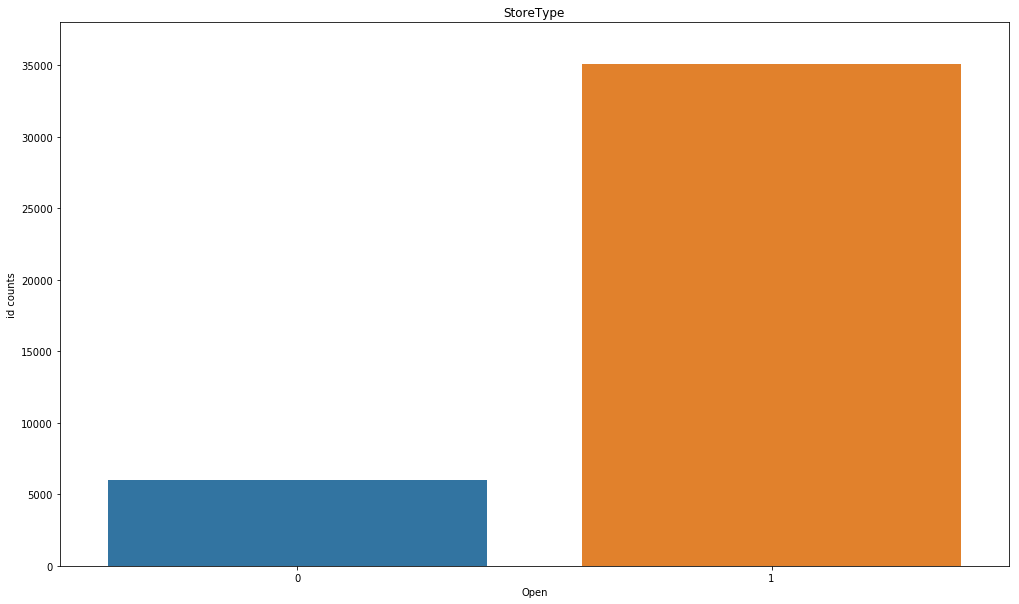

In [185]:
# 对open做可视化
po = test.groupby('Open')['Id'].count()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=38000)  
plt.title('StoreType')  
plt.ylabel('id counts')  
sns.barplot(po.index,po.values)
plt.show()

In [186]:
test.query('Open==0').count()

Id               5984
Store            5984
DayOfWeek        5984
Open             5984
Promo            5984
StateHoliday     5984
SchoolHoliday    5984
Year             5984
Month            5984
Day              5984
WeekOfYear       5984
dtype: int64

In [187]:
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,1,3,1,1,0,0,2015,9,17,38
1,2,3,3,1,1,0,0,2015,9,17,38
2,3,7,3,1,1,0,0,2015,9,17,38
3,4,8,3,1,1,0,0,2015,9,17,38
4,5,9,3,1,1,0,0,2015,9,17,38


#### 整理store数据

In [188]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [189]:
#处理缺失数据
#CompetitionDistance中缺失三条,缺失的数据里同时缺失CompetitionOpenSinceMonth和CompetitionOpenSinceYear，我将其认为在合理距离范围内无竞争对手。
print(store.query('CompetitionDistance=="NaN"')[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']])
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879

     Store  CompetitionDistance  CompetitionOpenSinceMonth  \
290    291                  nan                        nan   
621    622                  nan                        nan   
878    879                  nan                        nan   

     CompetitionOpenSinceYear  
290                       nan  
621                       nan  
878                       nan  


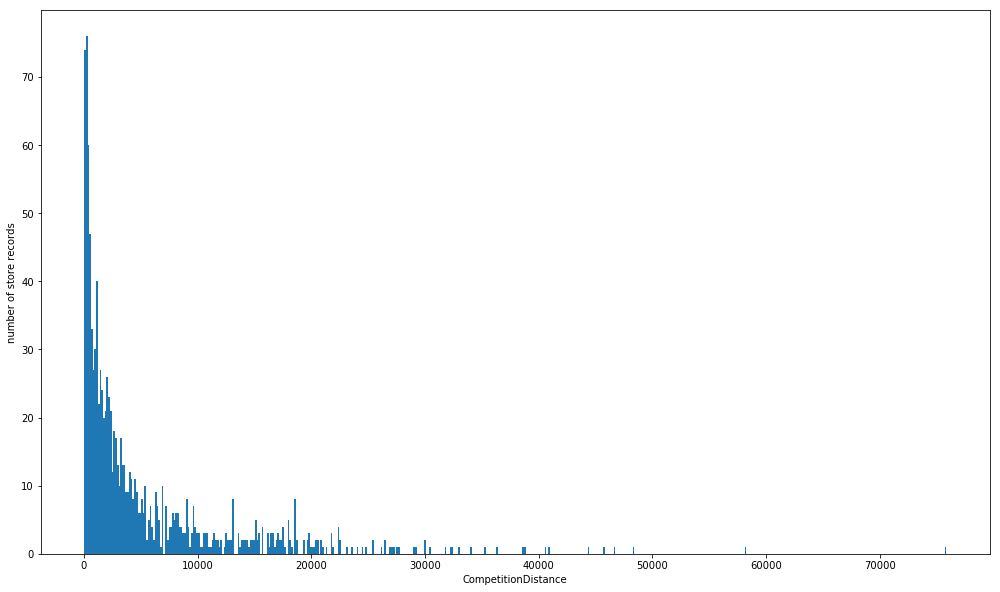

In [190]:
#查看CompetitionDistance的情况
store['CompetitionDistance'].describe()
#根据情况将291，622，879的CompetitionDistance距离改为99999
plt.subplots(1,1,figsize=(17,10))  
# plt.plot(store['CompetitionDistance'])
# plt.xlabel('Store')
# plt.ylabel('CompetitionDistance')
# plt.show()
# 对最重要的Sales做可视化
plt.hist(store['CompetitionDistance'].dropna(), bins=500)  
plt.xlabel('CompetitionDistance')  
plt.ylabel('number of store records')  
plt.show()

In [191]:
store.query('CompetitionDistance==0').count()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [192]:
store['CompetitionDistance'].describe()

count    1112.000
mean     5404.901
std      7663.175
min        20.000
25%       717.500
50%      2325.000
75%      6882.500
max     75860.000
Name: CompetitionDistance, dtype: float64

In [193]:
#根据情况将291，622，879的CompetitionDistance距离改为99999并转化为int型，将其CompetitionOpenSinceYear特征改为一个未来值
store['CompetitionDistance']=store['CompetitionDistance'].fillna(99999)
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
# store.query('Store in (291,622,879)')['CompetitionOpenSinceYear']=2030
store.loc[(store['Store']==291)|(store['Store']==622)|(store['Store']==879),'CompetitionOpenSinceYear']=2030

In [194]:
# 设置距离超过20km的CompetitionOpenSinceYear为2030
store.loc[store['CompetitionDistance']>30000,'CompetitionOpenSinceYear']=2030

In [195]:
# CompetitionOpenSinceMonth和CompetitionOpenSinceYear的缺失值
# 判断是否缺失的商店是同一个，输出同时为NaN的商店个数
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))

349


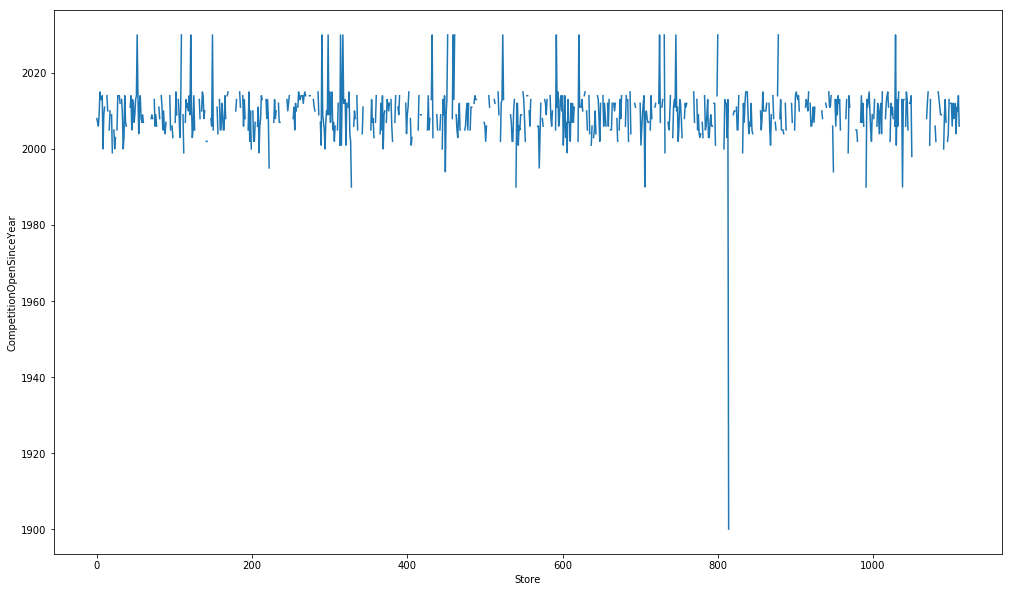

In [196]:
# 可视化CompetitionOpenSinceYear
# store['CompetitionOpenSinceYear'].describe()
plt.subplots(1,1,figsize=(17,10))  
plt.plot(store['CompetitionOpenSinceYear'])
plt.xlabel('Store')
plt.ylabel('CompetitionOpenSinceYear')
plt.show()

In [197]:
store['CompetitionOpenSinceYear'].describe()

count    766.000
mean    2009.242
std        7.115
min     1900.000
25%     2006.000
50%     2010.000
75%     2013.000
max     2030.000
Name: CompetitionOpenSinceYear, dtype: float64

In [198]:
# 1115-354=761所以均为同时为Nan，那就设置为一个较早的时间，认为是早已经开业的商店,并设置为int型
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(2010)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median())
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

In [199]:
# Promo2SinceWeek,Promo2SinceYear,PromoInterval的缺失值
# 确认他们缺失的是否是相同的store
nan = np.nan
print(len(store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')))

544


In [200]:
# 1115-544=571,571符合这三个特征的缺失数，得出结论就是这三个特征是同时缺失的，看看此时的Promo2的值是多少
store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')['Promo2'].value_counts()

0    544
Name: Promo2, dtype: int64

In [201]:
# 查看0的总总数量和Promo2SinceWeek,Promo2SinceYear,PromoInterval缺失值保持一致
store['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [202]:
# 将Promo2SinceYear设置为一个未来的时间，Promo2SinceWeek设置为1
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(2030)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

In [203]:
#处理PromoInterval,
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'0,3,6,9','Feb,May,Aug,Nov':'1,4,7,10','Mar,Jun,Sept,Dec':'2,5,8,11'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,0,2030,"0,0,0,0"
1,2,a,a,570,11,2007,1,13,2010,"0,3,6,9"
2,3,a,a,14130,12,2006,1,14,2011,"0,3,6,9"
3,4,c,c,620,9,2009,0,0,2030,"0,0,0,0"
4,5,a,a,29910,4,2015,0,0,2030,"0,0,0,0"


In [204]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
dtypes: int32(5), int64(2), object(3)
memory usage: 65.4+ KB


In [205]:
print(store['PromoInterval'].value_counts())

0,0,0,0     544
0,3,6,9     335
1,4,7,10    130
2,5,8,11    106
Name: PromoInterval, dtype: int64


In [206]:
# 将PromoInterval展开
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1,dtype='int32')
store['PromoInterval2']=pd.Series(PromoInterval2,dtype='int32')
store['PromoInterval3']=pd.Series(PromoInterval3,dtype='int32')
store['PromoInterval4']=pd.Series(PromoInterval4,dtype='int32')
store.drop('PromoInterval',axis=1, inplace=True)

In [207]:
#处理两个Object字段
#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

In [208]:
#针对Assortment，StoreType特征做one-hot
store= pd.concat([store,pd.get_dummies(store['Assortment'],prefix='Assortment')], axis=1)
store.drop('Assortment',axis=1, inplace=True)
store= pd.concat([store,pd.get_dummies(store['StoreType'],prefix='StoreType')], axis=1)
store.drop('StoreType',axis=1, inplace=True)
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,PromoInterval4,Assortment_1,Assortment_2,Assortment_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
0,1,1270,9,2008,0,0,2030,0,0,0,0,1,0,0,0,0,1,0
1,2,570,11,2007,1,13,2010,0,3,6,9,1,0,0,1,0,0,0
2,3,14130,12,2006,1,14,2011,0,3,6,9,1,0,0,1,0,0,0
3,4,620,9,2009,0,0,2030,0,0,0,0,0,0,1,0,0,1,0
4,5,29910,4,2015,0,0,2030,0,0,0,0,1,0,0,1,0,0,0


In [209]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 18 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval1               1115 non-null int32
PromoInterval2               1115 non-null int32
PromoInterval3               1115 non-null int32
PromoInterval4               1115 non-null int32
Assortment_1                 1115 non-null uint8
Assortment_2                 1115 non-null uint8
Assortment_3                 1115 non-null uint8
StoreType_1                  1115 non-null uint8
StoreType_2                  1115 non-null uint8
StoreType_3                  1115 non-null uint8
StoreType_4                  1115 non-null uint8
dtypes: int

In [210]:
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,PromoInterval4,Assortment_1,Assortment_2,Assortment_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
0,1,1270,9,2008,0,0,2030,0,0,0,0,1,0,0,0,0,1,0
1,2,570,11,2007,1,13,2010,0,3,6,9,1,0,0,1,0,0,0
2,3,14130,12,2006,1,14,2011,0,3,6,9,1,0,0,1,0,0,0
3,4,620,9,2009,0,0,2030,0,0,0,0,0,0,1,0,0,1,0
4,5,29910,4,2015,0,0,2030,0,0,0,0,1,0,0,1,0,0,0


#### 整理train数据

In [211]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


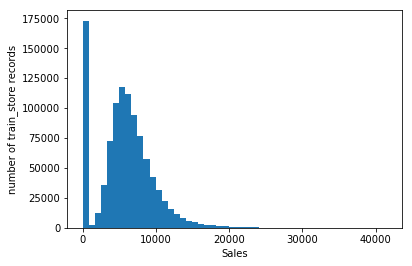

In [212]:
# 对最重要的Sales做可视化
plt.hist(train['Sales'], bins=50)  
plt.xlabel('Sales')  
plt.ylabel('number of train_store records')  
plt.show()

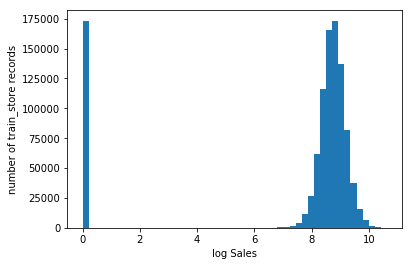

In [213]:
# 在预测的时候将对斜态分布的Sales做正态转换使用对数方式，做可视化
plt.hist(np.log1p(train['Sales']), bins=50)  
plt.xlabel('log Sales')  
plt.ylabel('number of train_store records')  
plt.show()

In [214]:
# 查看open为0的数据的Sales和Customers
print(train.query('Open=="0"')['Sales'].value_counts())
print(train.query('Open=="0"')['Customers'].value_counts())

0    172817
Name: Sales, dtype: int64
0    172817
Name: Customers, dtype: int64


In [215]:
#可以认为open为0对于训练没有什么帮助所以我们只训练open==1的
len(train.query('Open==1'))

844392

In [216]:
# 844392+172817=1017209 所以open==1作为训练对象
train=train.query('Open==1')

In [217]:
# 按照test的方式处理Data
train['Date']=pd.to_datetime(train['Date'])

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

In [218]:
#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)

In [219]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None


#### 合并数据

In [220]:
#合并test，先把test里open为0的数据提出来直接输出sales=0
result_0=pd.DataFrame({"Id": test.query('Open==0')['Id'], 'Sales':0})
result_0.head()

,Id,Sales
543,544,0
676,677,0
840,841,0
1399,1400,0
1532,1533,0


In [221]:
len(test.query('Open==1'))

35104

In [222]:
# 对于剩下test来跑predict再合并
test_data = pd.merge(test.query('Open==1'), store, on='Store')

In [223]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 35103
Data columns (total 28 columns):
Id                           35104 non-null int64
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-nu

In [224]:
print(train.info())
train_data = pd.merge(train, store, on='Store')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 29 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64

In [225]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,4,5263,555,1,1,0,1,2015,7,31,31
1,2,4,6064,625,1,1,0,1,2015,7,31,31
2,3,4,8314,821,1,1,0,1,2015,7,31,31
3,4,4,13995,1498,1,1,0,1,2015,7,31,31
4,5,4,4822,559,1,1,0,1,2015,7,31,31


In [226]:
test_data.set_index(['Id'],inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 1 to 40909
Data columns (total 27 columns):
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-null int32
PromoInterval2               35104 non-nu

#### 数据探索

将CompetitionOpenSinceMonth,CompetitionOpenSinceYear合并为一个特征CompetitionMonths，  
将Promo2SinceWeek Promo2SinceYear PromoInterval合并为一个特征IsPromo2

In [227]:
train_data['CompetitionOpenSinceMonth'].value_counts()    
train_data['Month'].value_counts()

1     86343
3     85980
7     85587
6     82576
4     81731
2     80243
5     80103
8     54413
10    53292
9     52330
11    51401
12    50393
Name: Month, dtype: int64

In [228]:
# 先处理train的
# 计算月份相差
train_data['CompetitionMonths']=(train_data['Year']-train_data['CompetitionOpenSinceYear'])*12+(train_data['Month']-train_data['CompetitionOpenSinceMonth'])


In [229]:
# 如果CompetitionMonths为负数则赋值为0
train_data['CompetitionMonths'].max()
train_data.loc[train_data['CompetitionMonths']==1386,'CompetitionOpenSinceYear']

615236    1900
615237    1900
615238    1900
615239    1900
615240    1900
615241    1900
615242    1900
615243    1900
615244    1900
615245    1900
615246    1900
615247    1900
615248    1900
615249    1900
615250    1900
615251    1900
615252    1900
615253    1900
615254    1900
615255    1900
615256    1900
615257    1900
615258    1900
615259    1900
615260    1900
615261    1900
615262    1900
Name: CompetitionOpenSinceYear, dtype: int32

In [230]:
train_data['CompetitionOpenSinceYear'].value_counts()

2010    304165
2012     60837
2013     58206
2014     52035
2005     46705
2011     41366
2009     40713
2008     37078
2007     36131
2006     35543
2015     28844
2002     19956
2030     17634
2004     16334
2003     13834
2001     12157
2000      7631
1999      6213
1990      3887
1994      1552
1995      1404
1961       779
1998       766
1900       622
Name: CompetitionOpenSinceYear, dtype: int64

In [231]:
train_data.loc[train_data['CompetitionMonths']<0,'CompetitionMonths']=0

In [232]:
# 去掉CompetitionOpenSinceMonth,CompetitionOpenSinceYear
train_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [233]:
# 对test_data做同样的操作
test_data['CompetitionMonths']=(test_data['Year']-test_data['CompetitionOpenSinceYear'])*12+(test_data['Month']-test_data['CompetitionOpenSinceMonth'])
test_data.loc[test_data['CompetitionMonths']<0,'CompetitionMonths']=0
test_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [234]:
train_data['Promo2SinceWeek'].value_counts()

0     423307
14     60541
40     51507
31     33238
10     32214
5      29722
37     27116
1      26873
13     24579
45     24072
22     23645
18     22456
35     18888
9      10293
27      7925
36      7620
48      7033
39      3889
23      3558
44      2182
26       782
50       780
28       779
6        771
49       622
Name: Promo2SinceWeek, dtype: int64

In [235]:
# 处理Promo2相关特征
# 先处理train_data
train_data['IsPromo2']=0
train_data.loc[(train_data['Promo2']==1)&((train_data['PromoInterval1']==train_data['Month'])|(train_data['PromoInterval2']==train_data['Month'])|(train_data['PromoInterval3']==train_data['Month'])|(train_data['PromoInterval4']==train_data['Month']))&(((train_data['Promo2SinceYear']==train_data['Year'])&(train_data['Promo2SinceWeek']<=train_data['WeekOfYear']))|train_data['Promo2SinceYear']<train_data['Year']),'IsPromo2']=1

In [236]:
train_data['IsPromo2'].value_counts()

0    718900
1    125492
Name: IsPromo2, dtype: int64

In [237]:
# 计算参加Promo2的时间按周计算，如果Promo2为0就为0
train_data['Promo2weeks']=train_data['Promo2']*((train_data['Year']-train_data['Promo2SinceYear'])*54+(train_data['WeekOfYear']-train_data['Promo2SinceWeek']))

In [238]:
# 如果为负数就设置为0
train_data.loc[train_data['Promo2weeks']<0,'Promo2weeks']=0

In [239]:
train_data['Promo2weeks'].value_counts()

0      481933
100      1820
101      1811
96       1779
105      1768
98       1738
95       1715
99       1709
106      1681
97       1677
102      1674
104      1667
103      1644
108      1619
128      1613
107      1608
129      1601
109      1599
110      1598
111      1589
33       1586
38       1586
41       1584
124      1578
133      1566
131      1561
132      1556
119      1549
187      1543
42       1541
        ...  
289       431
291       430
286       427
308       425
287       425
292       414
297       408
299       407
309       403
305       402
294       398
307       389
293       384
310       379
302       373
301       373
312       258
314       258
317       252
316       251
315       251
313       251
311       251
318       217
323        42
322        42
321        42
320        42
319        42
324        35
Name: Promo2weeks, Length: 325, dtype: int64

In [240]:
# 删除Promo2SinceWeek Promo2SinceYear PromoInterval
train_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [241]:
# 在test_data上也按照这个思路处理Promo2相关特征
test_data['IsPromo2']=0
test_data.loc[(test_data['Promo2']==1)&((test_data['PromoInterval1']==test_data['Month'])|(test_data['PromoInterval2']==test_data['Month'])|(test_data['PromoInterval3']==test_data['Month'])|(test_data['PromoInterval4']==test_data['Month']))&(((test_data['Promo2SinceYear']==test_data['Year'])&(test_data['Promo2SinceWeek']<=test_data['WeekOfYear']))|test_data['Promo2SinceYear']<test_data['Year']),'IsPromo2']=1

In [242]:
test_data['Promo2weeks']=test_data['Promo2']*((test_data['Year']-test_data['Promo2SinceYear'])*54+(test_data['WeekOfYear']-test_data['Promo2SinceWeek']))

In [243]:
test_data.loc[test_data['Promo2weeks']<0,'Promo2weeks']=0

In [244]:
test_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [245]:
# 对StateHoliday做one_hot
# 先对train_data
train_data= pd.concat([train_data,pd.get_dummies(train_data['StateHoliday'],prefix='StateHoliday')], axis=1)
train_data.drop('StateHoliday',axis=1, inplace=True)

In [246]:
# 再处理test_data
test_data= pd.concat([test_data,pd.get_dummies(test_data['StateHoliday'],prefix='StateHoliday')], axis=1)
test_data.drop('StateHoliday',axis=1, inplace=True)

In [247]:
print(train_data.columns)
print(test_data.columns)

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'CompetitionDistance', 'Promo2', 'Assortment_1', 'Assortment_2',
       'Assortment_3', 'StoreType_1', 'StoreType_2', 'StoreType_3',
       'StoreType_4', 'CompetitionMonths', 'IsPromo2', 'Promo2weeks',
       'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3'],
      dtype='object')
Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionDistance', 'Promo2', 'Assortment_1',
       'Assortment_2', 'Assortment_3', 'StoreType_1', 'StoreType_2',
       'StoreType_3', 'StoreType_4', 'CompetitionMonths', 'IsPromo2',
       'Promo2weeks', 'StateHoliday_0', 'StateHoliday_1'],
      dtype='object')


In [248]:
print(train_data['StateHoliday_2'].value_counts())

0    844247
1       145
Name: StateHoliday_2, dtype: int64


In [249]:
# 补充test_data相对于train_data少的两个特征
test_data['StateHoliday_2']=0
test_data['StateHoliday_3']=0

#### 建模预测

In [250]:
# Store字段转变为object
# train_data['Store']=train_data['Store'].astype(object)
# test_data['Store']=test_data['Store'].astype(object)

Year
2013    337943
2014    310417
2015    196032
Name: Open, dtype: int64


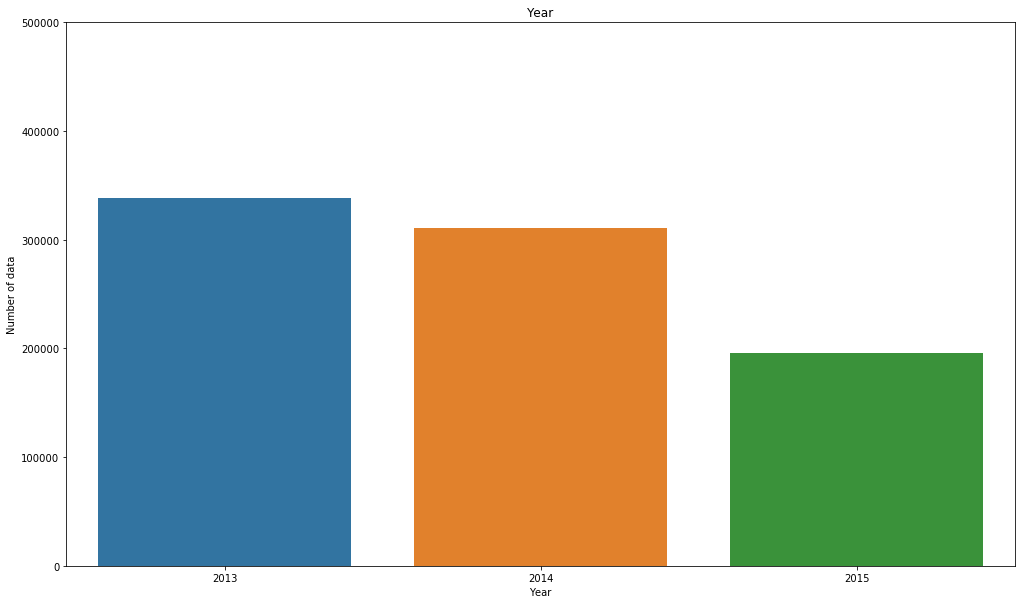

In [251]:
pt = train_data.groupby('Year')['Open'].count()
print(pt)
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=500000)  
plt.title('Year')  
plt.ylabel('Number of data')  
sns.barplot(pt.index,pt.values)
plt.show()
# 2015年数据有236380作为测试数据还是有点多的接下来看看月份数据分布

Month
1    28763
2    26767
3    29080
4    26931
5    25880
6    28423
7    30188
Name: Open, dtype: int64


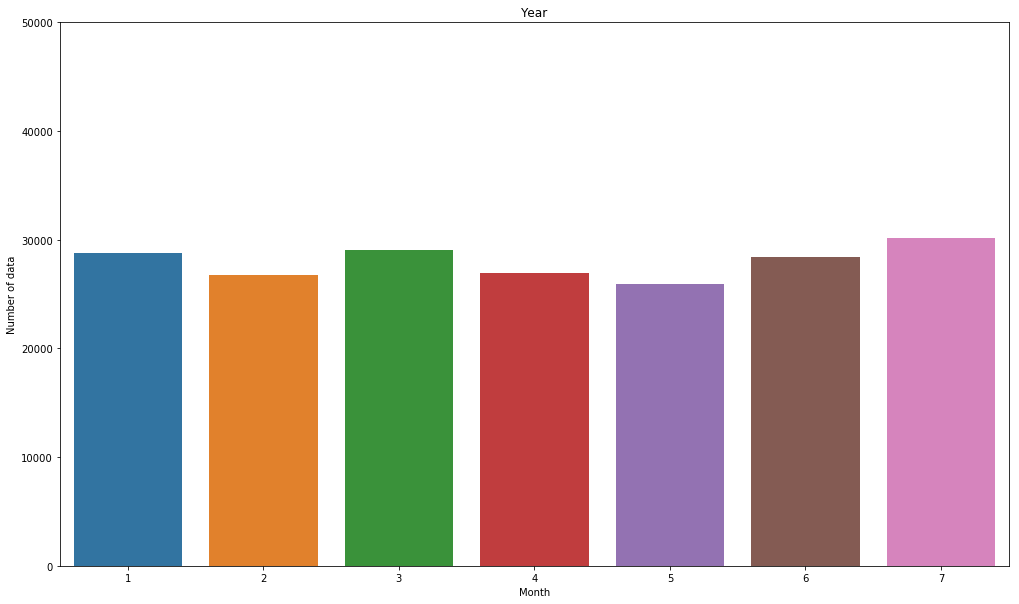

In [252]:
# 展现2015年各个月份的数据
pt = train_data.query('Year==2015').groupby('Month')['Open'].count()
print(pt)
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=50000)  
plt.title('Year')  
plt.ylabel('Number of data')  
sns.barplot(pt.index,pt.values)
plt.show()

In [253]:
# 展现test有哪些月数据
test_data['Year'].value_counts()
test_data['Month'].value_counts()

8    22228
9    12876
Name: Month, dtype: int64

In [254]:
print(train_data.query('Year==2015&Month==7')['Open'].count()/train_data['Open'].count())
print(train_data.query('Year==2015&Month==7')['Open'].count()+train_data.query('Year==2013|Year==2014|(Year==2015&Month!=7)')['Open'].count())
print(train_data['Open'].count())
train_a=train_data.query('Year==2015&Month==7')
train_b=train_data.query('Year==2013|Year==2014|(Year==2015&Month!=7)')
print(len(train_a)+len(train_b))

0.0357511677041
844392
844392
844392


In [255]:
# 确认训练特征和比对label
y_test=train_a['Sales']
X_test=train_a.drop(['Customers','Sales'],axis=1)

y_train=train_b['Sales']
X_train=train_b.drop(['Customers','Sales'],axis=1)

X_all=train_data.drop(['Customers','Sales'],axis=1)
y_all=train_data['Sales']

X_all_nor=X_all
test_data_nor=test_data

In [256]:
# 验证数据占训练数据百分比
len(y_test)/len(y_all)

0.035751167704099515

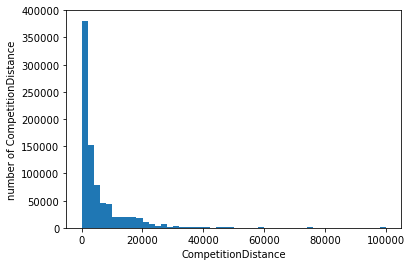

In [257]:
# CompetitionDistance,CompetitionMonths,Promo2weeks
# CompetitionDistance
plt.hist(X_all_nor['CompetitionDistance'], bins=50)  
plt.xlabel('CompetitionDistance')  
plt.ylabel('number of CompetitionDistance')  
plt.show()

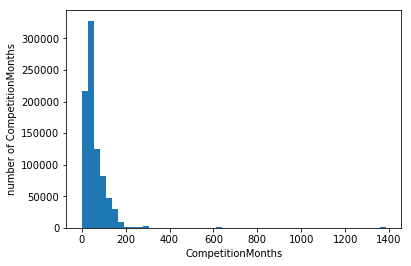

In [258]:
# CompetitionMonths
plt.hist(X_all_nor['CompetitionMonths'], bins=50)  
plt.xlabel('CompetitionMonths')  
plt.ylabel('number of CompetitionMonths')  
plt.show()

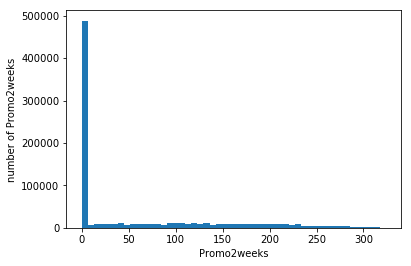

In [259]:
# Promo2weeks
plt.hist(X_all_nor['Promo2weeks'], bins=50)  
plt.xlabel('Promo2weeks')  
plt.ylabel('number of Promo2weeks')  
plt.show()

In [260]:
X_all_nor['CompetitionDistance']=np.log1p(X_all['CompetitionDistance'])
X_all_nor['CompetitionMonths']=np.log1p(X_all['CompetitionMonths'])
X_all_nor['Promo2weeks']=np.log1p(X_all['Promo2weeks'])

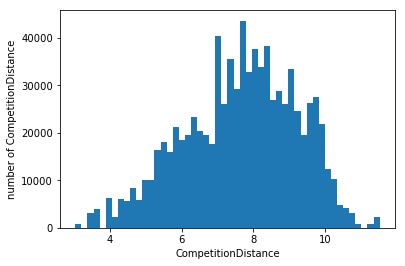

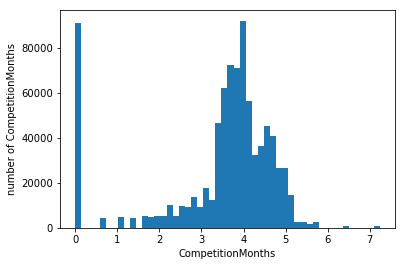

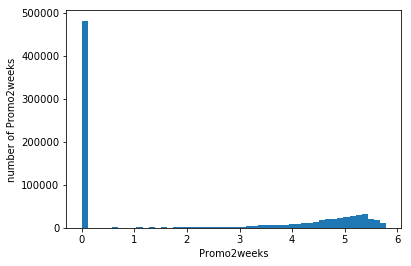

In [261]:
plt.hist(X_all_nor['CompetitionDistance'], bins=50)  
plt.xlabel('CompetitionDistance')  
plt.ylabel('number of CompetitionDistance')  
plt.show()
plt.hist(X_all_nor['CompetitionMonths'], bins=50)  
plt.xlabel('CompetitionMonths')  
plt.ylabel('number of CompetitionMonths')  
plt.show()
plt.hist(X_all_nor['Promo2weeks'], bins=50)  
plt.xlabel('Promo2weeks')  
plt.ylabel('number of Promo2weeks')  
plt.show()

In [262]:
test_data_nor['CompetitionDistance']=np.log1p(test_data['CompetitionDistance'])
test_data_nor['CompetitionMonths']=np.log1p(test_data['CompetitionMonths'])
test_data_nor['Promo2weeks']=np.log1p(test_data['Promo2weeks'])

In [263]:
# X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.1, random_state=0)

In [264]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def rmpse_estimator(estimator, X, y):
    yhat = estimator.predict(X)
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe

In [265]:
len(train_b.groupby('Store')['Sales'].mean())

1115

In [266]:
# 建立基准模型
train_mean=train_data.groupby('Store')[['Store','Sales']].mean()
train_mean=pd.merge(train_mean, test_data[['Store']], on='Store')

In [267]:
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': train_mean['Sales']})
result=result.append(result_0)
print(len(result))
result.to_csv("mean_submission.csv", index=False)

41088


kaggle 评分是0.45019

In [268]:
# RidgeCV参数优化
clf = RidgeCV(alphas=[0.1, 0.5, 1.0, 10.0], cv=10, fit_intercept=True,scoring=rmpse_estimator)
starttime = datetime.datetime.now()
clf.fit(X_all_nor,np.log1p(y_all))
endtime = datetime.datetime.now()
print (endtime - starttime)
print ('alpha: ', clf.alpha_)
print ('coef_：', clf.coef_)

0:00:25.431592
alpha:  0.1
coef_： [ -1.38565277e-06  -2.15802569e-02   0.00000000e+00   3.23806005e-01
   1.53565401e-02   3.48975291e-02   8.24733360e-03  -5.74556608e-04
   5.06698285e-04  -2.67233551e-02  -9.82869146e-02   4.41125432e-02
  -2.07363498e-01   1.63251005e-01  -1.42202762e-01   3.91452067e-01
  -1.33301809e-01  -1.15947509e-01  -7.76574632e-03  -4.40609986e-03
   6.59796618e-05   6.21091220e-02  -4.04594896e-02  -7.80892679e-02
   5.64396357e-02]


In [269]:
# Ridge结论输出
starttime = datetime.datetime.now()
test_probs = clf.predict(test_data_nor)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data_nor.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("ridge_submission.csv", index=False)

0:00:00.006015
41088


Kaggle进行评分是0.41781

In [272]:
# LassoCV参数优化
clf = LassoCV(cv=20)
starttime = datetime.datetime.now()
clf.fit(X_all_nor,np.log1p(y_all))
endtime = datetime.datetime.now()
print (endtime - starttime)
print ('alpha: ', clf.alpha_)
print ('coef：', clf.coef_)

0:00:16.025302
alpha:  0.00108598018931
coef： [ -3.95174526e-06  -2.16213894e-02   0.00000000e+00   3.19170160e-01
   8.62934658e-03   3.37717472e-02   7.59419540e-03  -5.89514526e-04
   6.65401989e-04  -2.59771451e-02  -8.89098138e-02  -0.00000000e+00
  -0.00000000e+00   1.14243884e-01  -2.12730434e-02   3.14946925e-01
  -5.12550065e-03   0.00000000e+00  -7.35229659e-03  -0.00000000e+00
  -1.96344759e-03   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00]


In [273]:
# Lasso结论输出
starttime = datetime.datetime.now()
test_probs = clf.predict(test_data_nor)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data_nor.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("lasso_submission.csv", index=False)

0:00:00.006015
41088


Kaggle进行评分是0.41467

In [98]:
print(X_train.info())
print(X_test.info())
print(y_train.describe())
print(y_test.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814204 entries, 27 to 844391
Data columns (total 25 columns):
Store                  814204 non-null int64
DayOfWeek              814204 non-null int64
Open                   814204 non-null int64
Promo                  814204 non-null int64
SchoolHoliday          814204 non-null int64
Year                   814204 non-null int64
Month                  814204 non-null int64
Day                    814204 non-null int64
WeekOfYear             814204 non-null int64
CompetitionDistance    814204 non-null int32
Promo2                 814204 non-null int64
Assortment_1           814204 non-null uint8
Assortment_2           814204 non-null uint8
Assortment_3           814204 non-null uint8
StoreType_1            814204 non-null uint8
StoreType_2            814204 non-null uint8
StoreType_3            814204 non-null uint8
StoreType_4            814204 non-null uint8
CompetitionMonths      814204 non-null int64
IsPromo2               814204 non

In [99]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_test, np.log1p(y_test))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.05
          }
num_trees = 2000

In [100]:
%%time
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:7.85522	eval-rmse:7.87633	train-rmspe:0.99971	eval-rmspe:0.999751
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.46331	eval-rmse:7.48388	train-rmspe:0.999506	eval-rmspe:0.999553
[2]	train-rmse:7.09101	eval-rmse:7.11173	train-rmspe:0.999223	eval-rmspe:0.999279
[3]	train-rmse:6.73734	eval-rmse:6.75768	train-rmspe:0.998837	eval-rmspe:0.998904
[4]	train-rmse:6.40143	eval-rmse:6.42117	train-rmspe:0.998321	eval-rmspe:0.998402
[5]	train-rmse:6.08242	eval-rmse:6.10103	train-rmspe:0.997641	eval-rmspe:0.997739
[6]	train-rmse:5.77932	eval-rmse:5.79752	train-rmspe:0.996763	eval-rmspe:0.996883
[7]	train-rmse:5.49142	eval-rmse:5.50964	train-rmspe:0.995644	eval-rmspe:0.995794
[8]	train-rmse:5.218	eval-rmse:5.23497	train-rmspe:0.994237	eval-rmspe:0.994418
[9]	train-rmse:4.95829	eval-rmse:4.97468	train-rmspe:0.992497	eval-rmspe:0.992715
[10]	train-rmse:4.71155	eval-rmse:4.7

[97]	train-rmse:0.25787	eval-rmse:0.256417	train-rmspe:0.283724	eval-rmspe:0.256606
[98]	train-rmse:0.257157	eval-rmse:0.25576	train-rmspe:0.284245	eval-rmspe:0.256989
[99]	train-rmse:0.255598	eval-rmse:0.254394	train-rmspe:0.283763	eval-rmspe:0.256559
[100]	train-rmse:0.254074	eval-rmse:0.253122	train-rmspe:0.283293	eval-rmspe:0.256194
[101]	train-rmse:0.252239	eval-rmse:0.251691	train-rmspe:0.282335	eval-rmspe:0.255641
[102]	train-rmse:0.251668	eval-rmse:0.251182	train-rmspe:0.282787	eval-rmspe:0.256016
[103]	train-rmse:0.250323	eval-rmse:0.25018	train-rmspe:0.280129	eval-rmspe:0.25583
[104]	train-rmse:0.249561	eval-rmse:0.249384	train-rmspe:0.280047	eval-rmspe:0.255892
[105]	train-rmse:0.247244	eval-rmse:0.247297	train-rmspe:0.278256	eval-rmspe:0.254349
[106]	train-rmse:0.246616	eval-rmse:0.246845	train-rmspe:0.278201	eval-rmspe:0.254473
[107]	train-rmse:0.246004	eval-rmse:0.246297	train-rmspe:0.278343	eval-rmspe:0.254511
[108]	train-rmse:0.245479	eval-rmse:0.245897	train-rmspe:0.27

[193]	train-rmse:0.183582	eval-rmse:0.193358	train-rmspe:0.225266	eval-rmspe:0.206753
[194]	train-rmse:0.182739	eval-rmse:0.192478	train-rmspe:0.224423	eval-rmspe:0.205737
[195]	train-rmse:0.182381	eval-rmse:0.192206	train-rmspe:0.22397	eval-rmspe:0.20547
[196]	train-rmse:0.181926	eval-rmse:0.191848	train-rmspe:0.223129	eval-rmspe:0.20508
[197]	train-rmse:0.181599	eval-rmse:0.191632	train-rmspe:0.222862	eval-rmspe:0.204819
[198]	train-rmse:0.180936	eval-rmse:0.191066	train-rmspe:0.222235	eval-rmspe:0.204225
[199]	train-rmse:0.180816	eval-rmse:0.190962	train-rmspe:0.221913	eval-rmspe:0.204116
[200]	train-rmse:0.1802	eval-rmse:0.190352	train-rmspe:0.22134	eval-rmspe:0.203441
[201]	train-rmse:0.180129	eval-rmse:0.190299	train-rmspe:0.22137	eval-rmspe:0.203393
[202]	train-rmse:0.179436	eval-rmse:0.189774	train-rmspe:0.220743	eval-rmspe:0.202841
[203]	train-rmse:0.178847	eval-rmse:0.189262	train-rmspe:0.220184	eval-rmspe:0.202266
[204]	train-rmse:0.178474	eval-rmse:0.189018	train-rmspe:0.21

[289]	train-rmse:0.150914	eval-rmse:0.167136	train-rmspe:0.185971	eval-rmspe:0.1778
[290]	train-rmse:0.150762	eval-rmse:0.166978	train-rmspe:0.185833	eval-rmspe:0.177636
[291]	train-rmse:0.150545	eval-rmse:0.166775	train-rmspe:0.185633	eval-rmspe:0.17741
[292]	train-rmse:0.150339	eval-rmse:0.166624	train-rmspe:0.185486	eval-rmspe:0.177264
[293]	train-rmse:0.150169	eval-rmse:0.166554	train-rmspe:0.18529	eval-rmspe:0.177112
[294]	train-rmse:0.149694	eval-rmse:0.166146	train-rmspe:0.18473	eval-rmspe:0.176706
[295]	train-rmse:0.149484	eval-rmse:0.16595	train-rmspe:0.184562	eval-rmspe:0.176521
[296]	train-rmse:0.149284	eval-rmse:0.165807	train-rmspe:0.184412	eval-rmspe:0.176365
[297]	train-rmse:0.148984	eval-rmse:0.165602	train-rmspe:0.18409	eval-rmspe:0.176158
[298]	train-rmse:0.148742	eval-rmse:0.165424	train-rmspe:0.18386	eval-rmspe:0.175965
[299]	train-rmse:0.14832	eval-rmse:0.165067	train-rmspe:0.183489	eval-rmspe:0.175558
[300]	train-rmse:0.147942	eval-rmse:0.164758	train-rmspe:0.1831

[385]	train-rmse:0.130738	eval-rmse:0.1527	train-rmspe:0.15956	eval-rmspe:0.161708
[386]	train-rmse:0.130594	eval-rmse:0.1526	train-rmspe:0.159458	eval-rmspe:0.16161
[387]	train-rmse:0.130422	eval-rmse:0.152497	train-rmspe:0.15932	eval-rmspe:0.161455
[388]	train-rmse:0.130316	eval-rmse:0.152428	train-rmspe:0.159123	eval-rmspe:0.16139
[389]	train-rmse:0.130109	eval-rmse:0.152333	train-rmspe:0.158988	eval-rmspe:0.161264
[390]	train-rmse:0.129908	eval-rmse:0.152173	train-rmspe:0.158772	eval-rmspe:0.161097
[391]	train-rmse:0.129673	eval-rmse:0.15206	train-rmspe:0.158537	eval-rmspe:0.160987
[392]	train-rmse:0.129502	eval-rmse:0.151951	train-rmspe:0.15838	eval-rmspe:0.160885
[393]	train-rmse:0.12937	eval-rmse:0.151919	train-rmspe:0.158173	eval-rmspe:0.160853
[394]	train-rmse:0.129218	eval-rmse:0.151895	train-rmspe:0.158102	eval-rmspe:0.160791
[395]	train-rmse:0.129081	eval-rmse:0.151757	train-rmspe:0.157963	eval-rmspe:0.160634
[396]	train-rmse:0.128978	eval-rmse:0.151723	train-rmspe:0.157879

[481]	train-rmse:0.118654	eval-rmse:0.146358	train-rmspe:0.142631	eval-rmspe:0.153358
[482]	train-rmse:0.118531	eval-rmse:0.146241	train-rmspe:0.142528	eval-rmspe:0.153223
[483]	train-rmse:0.118486	eval-rmse:0.14621	train-rmspe:0.142388	eval-rmspe:0.153193
[484]	train-rmse:0.118393	eval-rmse:0.146184	train-rmspe:0.142275	eval-rmspe:0.153145
[485]	train-rmse:0.118313	eval-rmse:0.146206	train-rmspe:0.142203	eval-rmspe:0.153142
[486]	train-rmse:0.118203	eval-rmse:0.146134	train-rmspe:0.142097	eval-rmspe:0.15307
[487]	train-rmse:0.118064	eval-rmse:0.146007	train-rmspe:0.141955	eval-rmspe:0.152931
[488]	train-rmse:0.117935	eval-rmse:0.145908	train-rmspe:0.141858	eval-rmspe:0.152815
[489]	train-rmse:0.11784	eval-rmse:0.145836	train-rmspe:0.141808	eval-rmspe:0.152747
[490]	train-rmse:0.117704	eval-rmse:0.145755	train-rmspe:0.141693	eval-rmspe:0.152615
[491]	train-rmse:0.117664	eval-rmse:0.145791	train-rmspe:0.141639	eval-rmspe:0.152642
[492]	train-rmse:0.117642	eval-rmse:0.145772	train-rmspe:

[577]	train-rmse:0.110726	eval-rmse:0.142842	train-rmspe:0.130831	eval-rmspe:0.14859
[578]	train-rmse:0.110693	eval-rmse:0.143003	train-rmspe:0.130793	eval-rmspe:0.148771
[579]	train-rmse:0.110595	eval-rmse:0.142965	train-rmspe:0.130719	eval-rmspe:0.148742
[580]	train-rmse:0.110495	eval-rmse:0.142885	train-rmspe:0.130642	eval-rmspe:0.148651
[581]	train-rmse:0.110443	eval-rmse:0.142825	train-rmspe:0.130415	eval-rmspe:0.148594
[582]	train-rmse:0.110319	eval-rmse:0.142755	train-rmspe:0.130294	eval-rmspe:0.148517
[583]	train-rmse:0.110271	eval-rmse:0.142721	train-rmspe:0.13002	eval-rmspe:0.148485
[584]	train-rmse:0.110201	eval-rmse:0.142547	train-rmspe:0.129948	eval-rmspe:0.148244
[585]	train-rmse:0.110163	eval-rmse:0.142534	train-rmspe:0.129901	eval-rmspe:0.148229
[586]	train-rmse:0.110133	eval-rmse:0.142509	train-rmspe:0.128496	eval-rmspe:0.148208
[587]	train-rmse:0.110046	eval-rmse:0.142458	train-rmspe:0.128412	eval-rmspe:0.148149
[588]	train-rmse:0.109998	eval-rmse:0.142415	train-rmspe

[673]	train-rmse:0.104142	eval-rmse:0.141109	train-rmspe:0.121031	eval-rmspe:0.145571
[674]	train-rmse:0.104117	eval-rmse:0.141105	train-rmspe:0.121009	eval-rmspe:0.145572
[675]	train-rmse:0.104083	eval-rmse:0.141089	train-rmspe:0.120985	eval-rmspe:0.145553
[676]	train-rmse:0.104021	eval-rmse:0.141037	train-rmspe:0.120933	eval-rmspe:0.145503
[677]	train-rmse:0.103993	eval-rmse:0.141023	train-rmspe:0.120909	eval-rmspe:0.14549
[678]	train-rmse:0.103914	eval-rmse:0.141013	train-rmspe:0.120866	eval-rmspe:0.145463
[679]	train-rmse:0.103822	eval-rmse:0.140975	train-rmspe:0.120807	eval-rmspe:0.145419
[680]	train-rmse:0.103736	eval-rmse:0.141066	train-rmspe:0.120369	eval-rmspe:0.145425
[681]	train-rmse:0.103674	eval-rmse:0.141025	train-rmspe:0.120325	eval-rmspe:0.145387
[682]	train-rmse:0.103599	eval-rmse:0.140996	train-rmspe:0.120262	eval-rmspe:0.145355
[683]	train-rmse:0.103539	eval-rmse:0.140946	train-rmspe:0.120204	eval-rmspe:0.145301
[684]	train-rmse:0.103487	eval-rmse:0.140908	train-rmsp

[769]	train-rmse:0.099444	eval-rmse:0.139623	train-rmspe:0.113664	eval-rmspe:0.14391
[770]	train-rmse:0.099336	eval-rmse:0.139632	train-rmspe:0.1132	eval-rmspe:0.143885
[771]	train-rmse:0.099228	eval-rmse:0.139581	train-rmspe:0.113099	eval-rmspe:0.143837
[772]	train-rmse:0.099129	eval-rmse:0.139545	train-rmspe:0.112984	eval-rmspe:0.143796
[773]	train-rmse:0.099048	eval-rmse:0.139545	train-rmspe:0.112899	eval-rmspe:0.14377
[774]	train-rmse:0.09897	eval-rmse:0.139517	train-rmspe:0.112829	eval-rmspe:0.143738
[775]	train-rmse:0.098904	eval-rmse:0.13948	train-rmspe:0.112757	eval-rmspe:0.143699
[776]	train-rmse:0.098856	eval-rmse:0.139405	train-rmspe:0.112705	eval-rmspe:0.1436
[777]	train-rmse:0.098837	eval-rmse:0.139398	train-rmspe:0.112683	eval-rmspe:0.143586
[778]	train-rmse:0.098798	eval-rmse:0.139387	train-rmspe:0.112655	eval-rmspe:0.143572
[779]	train-rmse:0.098751	eval-rmse:0.139393	train-rmspe:0.112617	eval-rmspe:0.143581
[780]	train-rmse:0.098711	eval-rmse:0.139377	train-rmspe:0.112

[865]	train-rmse:0.094806	eval-rmse:0.139351	train-rmspe:0.10883	eval-rmspe:0.143054
[866]	train-rmse:0.094772	eval-rmse:0.139339	train-rmspe:0.108796	eval-rmspe:0.143044
[867]	train-rmse:0.094726	eval-rmse:0.139314	train-rmspe:0.10871	eval-rmspe:0.143019
[868]	train-rmse:0.094671	eval-rmse:0.139287	train-rmspe:0.108673	eval-rmspe:0.142991
[869]	train-rmse:0.094596	eval-rmse:0.139299	train-rmspe:0.107608	eval-rmspe:0.143022
[870]	train-rmse:0.094537	eval-rmse:0.139332	train-rmspe:0.107573	eval-rmspe:0.143004
[871]	train-rmse:0.0945	eval-rmse:0.139348	train-rmspe:0.107552	eval-rmspe:0.143019
[872]	train-rmse:0.094441	eval-rmse:0.139328	train-rmspe:0.107511	eval-rmspe:0.143001
[873]	train-rmse:0.094386	eval-rmse:0.139298	train-rmspe:0.107453	eval-rmspe:0.142969
[874]	train-rmse:0.094348	eval-rmse:0.139284	train-rmspe:0.107422	eval-rmspe:0.142952
[875]	train-rmse:0.094292	eval-rmse:0.139266	train-rmspe:0.10737	eval-rmspe:0.142937
[876]	train-rmse:0.094258	eval-rmse:0.139232	train-rmspe:0.

[961]	train-rmse:0.091334	eval-rmse:0.138929	train-rmspe:0.10342	eval-rmspe:0.142329
[962]	train-rmse:0.091308	eval-rmse:0.138935	train-rmspe:0.103402	eval-rmspe:0.142338
[963]	train-rmse:0.091244	eval-rmse:0.138926	train-rmspe:0.103341	eval-rmspe:0.142347
[964]	train-rmse:0.09119	eval-rmse:0.138896	train-rmspe:0.103286	eval-rmspe:0.142317
[965]	train-rmse:0.091155	eval-rmse:0.138894	train-rmspe:0.103264	eval-rmspe:0.142307
[966]	train-rmse:0.091126	eval-rmse:0.138888	train-rmspe:0.103247	eval-rmspe:0.1423
[967]	train-rmse:0.091092	eval-rmse:0.138882	train-rmspe:0.103222	eval-rmspe:0.142296
[968]	train-rmse:0.091048	eval-rmse:0.1389	train-rmspe:0.103174	eval-rmspe:0.142324
[969]	train-rmse:0.091013	eval-rmse:0.138882	train-rmspe:0.103131	eval-rmspe:0.142307
[970]	train-rmse:0.090987	eval-rmse:0.13886	train-rmspe:0.103107	eval-rmspe:0.142286
[971]	train-rmse:0.090965	eval-rmse:0.138851	train-rmspe:0.10309	eval-rmspe:0.142272
[972]	train-rmse:0.090944	eval-rmse:0.138848	train-rmspe:0.103

[1057]	train-rmse:0.088396	eval-rmse:0.138466	train-rmspe:0.097587	eval-rmspe:0.141832
[1058]	train-rmse:0.088359	eval-rmse:0.138452	train-rmspe:0.097379	eval-rmspe:0.141811
[1059]	train-rmse:0.088328	eval-rmse:0.138449	train-rmspe:0.097353	eval-rmspe:0.141805
[1060]	train-rmse:0.088312	eval-rmse:0.138439	train-rmspe:0.097335	eval-rmspe:0.141787
[1061]	train-rmse:0.088279	eval-rmse:0.138439	train-rmspe:0.097308	eval-rmspe:0.141774
[1062]	train-rmse:0.088251	eval-rmse:0.138419	train-rmspe:0.097115	eval-rmspe:0.141749
[1063]	train-rmse:0.088232	eval-rmse:0.138412	train-rmspe:0.097093	eval-rmspe:0.141741
[1064]	train-rmse:0.088206	eval-rmse:0.138426	train-rmspe:0.097012	eval-rmspe:0.141732
[1065]	train-rmse:0.088164	eval-rmse:0.138417	train-rmspe:0.096994	eval-rmspe:0.141726
[1066]	train-rmse:0.088141	eval-rmse:0.138407	train-rmspe:0.096969	eval-rmspe:0.141718
[1067]	train-rmse:0.088127	eval-rmse:0.138431	train-rmspe:0.096954	eval-rmspe:0.141769
[1068]	train-rmse:0.088088	eval-rmse:0.1384

[1152]	train-rmse:0.085844	eval-rmse:0.138355	train-rmspe:0.094711	eval-rmspe:0.141645
[1153]	train-rmse:0.085815	eval-rmse:0.138356	train-rmspe:0.094693	eval-rmspe:0.141649
[1154]	train-rmse:0.085804	eval-rmse:0.13835	train-rmspe:0.094682	eval-rmspe:0.141653
[1155]	train-rmse:0.085768	eval-rmse:0.138337	train-rmspe:0.094654	eval-rmspe:0.141635
[1156]	train-rmse:0.085734	eval-rmse:0.138368	train-rmspe:0.094636	eval-rmspe:0.141643
[1157]	train-rmse:0.085709	eval-rmse:0.138369	train-rmspe:0.094613	eval-rmspe:0.14163
[1158]	train-rmse:0.085683	eval-rmse:0.138356	train-rmspe:0.094582	eval-rmspe:0.141617
[1159]	train-rmse:0.085671	eval-rmse:0.138348	train-rmspe:0.094568	eval-rmspe:0.141601
[1160]	train-rmse:0.085638	eval-rmse:0.138338	train-rmspe:0.09453	eval-rmspe:0.14159
[1161]	train-rmse:0.08561	eval-rmse:0.138342	train-rmspe:0.094499	eval-rmspe:0.141598
[1162]	train-rmse:0.085588	eval-rmse:0.138331	train-rmspe:0.094482	eval-rmspe:0.14159
[1163]	train-rmse:0.08556	eval-rmse:0.138412	trai

[1247]	train-rmse:0.083624	eval-rmse:0.138629	train-rmspe:0.091534	eval-rmspe:0.14158
[1248]	train-rmse:0.083606	eval-rmse:0.138623	train-rmspe:0.091508	eval-rmspe:0.141573
[1249]	train-rmse:0.083584	eval-rmse:0.138621	train-rmspe:0.091481	eval-rmspe:0.14157
[1250]	train-rmse:0.083568	eval-rmse:0.138623	train-rmspe:0.091465	eval-rmspe:0.141577
[1251]	train-rmse:0.083549	eval-rmse:0.13863	train-rmspe:0.091449	eval-rmspe:0.141579
[1252]	train-rmse:0.083522	eval-rmse:0.138624	train-rmspe:0.091435	eval-rmspe:0.141574
[1253]	train-rmse:0.083505	eval-rmse:0.138623	train-rmspe:0.091412	eval-rmspe:0.141578
[1254]	train-rmse:0.083489	eval-rmse:0.13862	train-rmspe:0.091389	eval-rmspe:0.141571
[1255]	train-rmse:0.083468	eval-rmse:0.138613	train-rmspe:0.091372	eval-rmspe:0.14156
[1256]	train-rmse:0.083462	eval-rmse:0.138606	train-rmspe:0.091364	eval-rmspe:0.141555
[1257]	train-rmse:0.083441	eval-rmse:0.138598	train-rmspe:0.091348	eval-rmspe:0.141545
[1258]	train-rmse:0.08342	eval-rmse:0.138624	tra

[1342]	train-rmse:0.081505	eval-rmse:0.138836	train-rmspe:0.088496	eval-rmspe:0.140896
[1343]	train-rmse:0.081477	eval-rmse:0.138835	train-rmspe:0.08848	eval-rmspe:0.140899
[1344]	train-rmse:0.081453	eval-rmse:0.138831	train-rmspe:0.088455	eval-rmspe:0.140895
[1345]	train-rmse:0.081425	eval-rmse:0.138828	train-rmspe:0.088437	eval-rmspe:0.140889
[1346]	train-rmse:0.081381	eval-rmse:0.138837	train-rmspe:0.088414	eval-rmspe:0.140901
[1347]	train-rmse:0.08136	eval-rmse:0.138828	train-rmspe:0.088387	eval-rmspe:0.140894
[1348]	train-rmse:0.081341	eval-rmse:0.138842	train-rmspe:0.088268	eval-rmspe:0.140929
[1349]	train-rmse:0.081324	eval-rmse:0.13885	train-rmspe:0.088251	eval-rmspe:0.140946
[1350]	train-rmse:0.081315	eval-rmse:0.13885	train-rmspe:0.088241	eval-rmspe:0.140943
[1351]	train-rmse:0.081309	eval-rmse:0.138849	train-rmspe:0.088235	eval-rmspe:0.140941
[1352]	train-rmse:0.081292	eval-rmse:0.138842	train-rmspe:0.088218	eval-rmspe:0.140936
[1353]	train-rmse:0.081282	eval-rmse:0.138869	t

[1437]	train-rmse:0.079685	eval-rmse:0.138995	train-rmspe:0.086156	eval-rmspe:0.140837
[1438]	train-rmse:0.07965	eval-rmse:0.138988	train-rmspe:0.086129	eval-rmspe:0.140826
[1439]	train-rmse:0.079642	eval-rmse:0.138976	train-rmspe:0.086119	eval-rmspe:0.140822
[1440]	train-rmse:0.079611	eval-rmse:0.138969	train-rmspe:0.086098	eval-rmspe:0.140819
[1441]	train-rmse:0.079598	eval-rmse:0.138978	train-rmspe:0.086081	eval-rmspe:0.140831
[1442]	train-rmse:0.079581	eval-rmse:0.138973	train-rmspe:0.086061	eval-rmspe:0.140825
[1443]	train-rmse:0.079568	eval-rmse:0.138969	train-rmspe:0.086049	eval-rmspe:0.140823
[1444]	train-rmse:0.079553	eval-rmse:0.138961	train-rmspe:0.086029	eval-rmspe:0.140812
[1445]	train-rmse:0.079529	eval-rmse:0.138953	train-rmspe:0.086008	eval-rmspe:0.140803
[1446]	train-rmse:0.079524	eval-rmse:0.138952	train-rmspe:0.086003	eval-rmspe:0.140804
[1447]	train-rmse:0.079504	eval-rmse:0.138972	train-rmspe:0.085986	eval-rmspe:0.140822
[1448]	train-rmse:0.079486	eval-rmse:0.13896

[1532]	train-rmse:0.078024	eval-rmse:0.139312	train-rmspe:0.083415	eval-rmspe:0.14089
[1533]	train-rmse:0.078014	eval-rmse:0.139319	train-rmspe:0.083405	eval-rmspe:0.140898
[1534]	train-rmse:0.077995	eval-rmse:0.139324	train-rmspe:0.083391	eval-rmspe:0.140907
[1535]	train-rmse:0.077979	eval-rmse:0.139321	train-rmspe:0.083374	eval-rmspe:0.140905
[1536]	train-rmse:0.077958	eval-rmse:0.139306	train-rmspe:0.08336	eval-rmspe:0.140897
[1537]	train-rmse:0.077943	eval-rmse:0.139304	train-rmspe:0.083346	eval-rmspe:0.140895
[1538]	train-rmse:0.077924	eval-rmse:0.139298	train-rmspe:0.083337	eval-rmspe:0.140886
[1539]	train-rmse:0.077911	eval-rmse:0.139299	train-rmspe:0.083323	eval-rmspe:0.140887
[1540]	train-rmse:0.077896	eval-rmse:0.139311	train-rmspe:0.083308	eval-rmspe:0.140884
[1541]	train-rmse:0.077884	eval-rmse:0.139308	train-rmspe:0.083297	eval-rmspe:0.14088
[1542]	train-rmse:0.077865	eval-rmse:0.139305	train-rmspe:0.083274	eval-rmspe:0.140876
[1543]	train-rmse:0.077854	eval-rmse:0.139303	

In [104]:
# 测试XGBoost模型结果
dtest = xgb.DMatrix(X_test)
yhat = gbm.predict(dtest)
error = rmspe(y_test, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.194368


In [115]:
# 将所有数据做训练提交kaggle检查分数
dtrain = xgb.DMatrix(X_all, np.log1p(y_all))
watchlist = [(dtrain, 'train')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.01
          }
num_trees = 8000
starttime = datetime.datetime.now()
bst = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)

[0]	train-rmse:8.18588	train-rmspe:0.999832
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.1042	train-rmspe:0.999806
[2]	train-rmse:8.02332	train-rmspe:0.999778
[3]	train-rmse:7.94327	train-rmspe:0.999748
[4]	train-rmse:7.864	train-rmspe:0.999715
[5]	train-rmse:7.78553	train-rmspe:0.999681
[6]	train-rmse:7.70785	train-rmspe:0.999644
[7]	train-rmse:7.63094	train-rmspe:0.999605
[8]	train-rmse:7.5548	train-rmspe:0.999562
[9]	train-rmse:7.47944	train-rmspe:0.999517
[10]	train-rmse:7.40482	train-rmspe:0.99947
[11]	train-rmse:7.33094	train-rmspe:0.999418
[12]	train-rmse:7.25781	train-rmspe:0.999364
[13]	train-rmse:7.18543	train-rmspe:0.999306
[14]	train-rmse:7.11375	train-rmspe:0.999244
[15]	train-rmse:7.04278	train-rmspe:0.999179
[16]	train-rmse:6.97255	train-rmspe:0.99911
[17]	train-rmse:6.90303	train-rmspe:0.999036
[18]	train-rmse:6.83419	train-rmspe:0.998957
[19]	train-rm

[179]	train-rmse:1.38839	train-rmspe:0.73552
[180]	train-rmse:1.37514	train-rmspe:0.732047
[181]	train-rmse:1.36201	train-rmspe:0.728568
[182]	train-rmse:1.34905	train-rmspe:0.725074
[183]	train-rmse:1.33612	train-rmspe:0.721592
[184]	train-rmse:1.3234	train-rmspe:0.718086
[185]	train-rmse:1.31081	train-rmspe:0.714574
[186]	train-rmse:1.29838	train-rmspe:0.711055
[187]	train-rmse:1.28608	train-rmspe:0.70753
[188]	train-rmse:1.27389	train-rmspe:0.704007
[189]	train-rmse:1.26181	train-rmspe:0.700481
[190]	train-rmse:1.24986	train-rmspe:0.696954
[191]	train-rmse:1.23806	train-rmspe:0.693419
[192]	train-rmse:1.22635	train-rmspe:0.68988
[193]	train-rmse:1.21466	train-rmspe:0.686359
[194]	train-rmse:1.20322	train-rmspe:0.682818
[195]	train-rmse:1.1919	train-rmspe:0.679276
[196]	train-rmse:1.18068	train-rmspe:0.675738
[197]	train-rmse:1.16957	train-rmspe:0.672196
[198]	train-rmse:1.15861	train-rmspe:0.668654
[199]	train-rmse:1.14774	train-rmspe:0.665117
[200]	train-rmse:1.13695	train-rmspe:0.

[355]	train-rmse:0.354714	train-rmspe:0.308217
[356]	train-rmse:0.353032	train-rmspe:0.307438
[357]	train-rmse:0.351422	train-rmspe:0.306698
[358]	train-rmse:0.34987	train-rmspe:0.306034
[359]	train-rmse:0.348389	train-rmspe:0.305412
[360]	train-rmse:0.346873	train-rmspe:0.304769
[361]	train-rmse:0.34527	train-rmspe:0.304023
[362]	train-rmse:0.343813	train-rmspe:0.303386
[363]	train-rmse:0.342329	train-rmspe:0.302754
[364]	train-rmse:0.340897	train-rmspe:0.30212
[365]	train-rmse:0.339514	train-rmspe:0.301558
[366]	train-rmse:0.338024	train-rmspe:0.300903
[367]	train-rmse:0.336703	train-rmspe:0.300416
[368]	train-rmse:0.335296	train-rmspe:0.29984
[369]	train-rmse:0.334029	train-rmspe:0.299368
[370]	train-rmse:0.332761	train-rmspe:0.298886
[371]	train-rmse:0.331432	train-rmspe:0.298353
[372]	train-rmse:0.330154	train-rmspe:0.297855
[373]	train-rmse:0.328749	train-rmspe:0.297246
[374]	train-rmse:0.327563	train-rmspe:0.29682
[375]	train-rmse:0.326332	train-rmspe:0.296299
[376]	train-rmse:0

[531]	train-rmse:0.242344	train-rmspe:0.272084
[532]	train-rmse:0.242173	train-rmspe:0.272077
[533]	train-rmse:0.241992	train-rmspe:0.272056
[534]	train-rmse:0.241864	train-rmspe:0.272108
[535]	train-rmse:0.241548	train-rmspe:0.271936
[536]	train-rmse:0.241225	train-rmspe:0.271767
[537]	train-rmse:0.241123	train-rmspe:0.271802
[538]	train-rmse:0.240954	train-rmspe:0.271789
[539]	train-rmse:0.240874	train-rmspe:0.271874
[540]	train-rmse:0.24057	train-rmspe:0.271634
[541]	train-rmse:0.240402	train-rmspe:0.271616
[542]	train-rmse:0.240288	train-rmspe:0.271649
[543]	train-rmse:0.24011	train-rmspe:0.271626
[544]	train-rmse:0.239947	train-rmspe:0.271604
[545]	train-rmse:0.239743	train-rmspe:0.271541
[546]	train-rmse:0.239628	train-rmspe:0.271557
[547]	train-rmse:0.239468	train-rmspe:0.271492
[548]	train-rmse:0.239159	train-rmspe:0.271295
[549]	train-rmse:0.238792	train-rmspe:0.270995
[550]	train-rmse:0.238308	train-rmspe:0.270656
[551]	train-rmse:0.238163	train-rmspe:0.270645
[552]	train-rms

[707]	train-rmse:0.215531	train-rmspe:0.255577
[708]	train-rmse:0.215457	train-rmspe:0.255551
[709]	train-rmse:0.215435	train-rmspe:0.255576
[710]	train-rmse:0.215392	train-rmspe:0.255561
[711]	train-rmse:0.215253	train-rmspe:0.255325
[712]	train-rmse:0.215188	train-rmspe:0.255289
[713]	train-rmse:0.215077	train-rmspe:0.255211
[714]	train-rmse:0.215057	train-rmspe:0.255236
[715]	train-rmse:0.215013	train-rmspe:0.255219
[716]	train-rmse:0.214698	train-rmspe:0.254935
[717]	train-rmse:0.214643	train-rmspe:0.254905
[718]	train-rmse:0.214591	train-rmspe:0.254877
[719]	train-rmse:0.214571	train-rmspe:0.254898
[720]	train-rmse:0.214509	train-rmspe:0.254862
[721]	train-rmse:0.214472	train-rmspe:0.254853
[722]	train-rmse:0.214296	train-rmspe:0.254292
[723]	train-rmse:0.214187	train-rmspe:0.254197
[724]	train-rmse:0.213829	train-rmspe:0.253878
[725]	train-rmse:0.213767	train-rmspe:0.25381
[726]	train-rmse:0.213662	train-rmspe:0.25374
[727]	train-rmse:0.213579	train-rmspe:0.253678
[728]	train-rms

[882]	train-rmse:0.193733	train-rmspe:0.233019
[883]	train-rmse:0.193526	train-rmspe:0.23269
[884]	train-rmse:0.193348	train-rmspe:0.232524
[885]	train-rmse:0.19332	train-rmspe:0.232509
[886]	train-rmse:0.193041	train-rmspe:0.232239
[887]	train-rmse:0.192999	train-rmspe:0.232207
[888]	train-rmse:0.19297	train-rmspe:0.232179
[889]	train-rmse:0.192936	train-rmspe:0.232145
[890]	train-rmse:0.192712	train-rmspe:0.231939
[891]	train-rmse:0.192685	train-rmspe:0.231883
[892]	train-rmse:0.192662	train-rmspe:0.231785
[893]	train-rmse:0.192598	train-rmspe:0.23171
[894]	train-rmse:0.192557	train-rmspe:0.231645
[895]	train-rmse:0.192499	train-rmspe:0.23159
[896]	train-rmse:0.192461	train-rmspe:0.231539
[897]	train-rmse:0.192319	train-rmspe:0.231392
[898]	train-rmse:0.192172	train-rmspe:0.231246
[899]	train-rmse:0.192032	train-rmspe:0.23111
[900]	train-rmse:0.191931	train-rmspe:0.231011
[901]	train-rmse:0.191697	train-rmspe:0.230767
[902]	train-rmse:0.19151	train-rmspe:0.230595
[903]	train-rmse:0.1

[1057]	train-rmse:0.176417	train-rmspe:0.213644
[1058]	train-rmse:0.176377	train-rmspe:0.213593
[1059]	train-rmse:0.176253	train-rmspe:0.213492
[1060]	train-rmse:0.176142	train-rmspe:0.213381
[1061]	train-rmse:0.176079	train-rmspe:0.213287
[1062]	train-rmse:0.176025	train-rmspe:0.213205
[1063]	train-rmse:0.176004	train-rmspe:0.213186
[1064]	train-rmse:0.175888	train-rmspe:0.213072
[1065]	train-rmse:0.175809	train-rmspe:0.212996
[1066]	train-rmse:0.175579	train-rmspe:0.21278
[1067]	train-rmse:0.175456	train-rmspe:0.212658
[1068]	train-rmse:0.175315	train-rmspe:0.212549
[1069]	train-rmse:0.175284	train-rmspe:0.212515
[1070]	train-rmse:0.175198	train-rmspe:0.212425
[1071]	train-rmse:0.17509	train-rmspe:0.21232
[1072]	train-rmse:0.175049	train-rmspe:0.21228
[1073]	train-rmse:0.175	train-rmspe:0.212244
[1074]	train-rmse:0.174906	train-rmspe:0.212164
[1075]	train-rmse:0.17478	train-rmspe:0.212069
[1076]	train-rmse:0.174716	train-rmspe:0.212021
[1077]	train-rmse:0.174615	train-rmspe:0.21192
[

[1229]	train-rmse:0.163562	train-rmspe:0.199785
[1230]	train-rmse:0.163491	train-rmspe:0.199713
[1231]	train-rmse:0.163409	train-rmspe:0.199637
[1232]	train-rmse:0.163371	train-rmspe:0.199605
[1233]	train-rmse:0.163264	train-rmspe:0.199497
[1234]	train-rmse:0.163197	train-rmspe:0.199429
[1235]	train-rmse:0.163117	train-rmspe:0.19936
[1236]	train-rmse:0.163076	train-rmspe:0.199319
[1237]	train-rmse:0.162987	train-rmspe:0.199234
[1238]	train-rmse:0.162958	train-rmspe:0.199208
[1239]	train-rmse:0.162903	train-rmspe:0.199137
[1240]	train-rmse:0.162871	train-rmspe:0.199105
[1241]	train-rmse:0.162858	train-rmspe:0.199087
[1242]	train-rmse:0.162741	train-rmspe:0.198974
[1243]	train-rmse:0.162673	train-rmspe:0.198901
[1244]	train-rmse:0.162623	train-rmspe:0.198863
[1245]	train-rmse:0.162566	train-rmspe:0.198816
[1246]	train-rmse:0.162496	train-rmspe:0.198762
[1247]	train-rmse:0.162457	train-rmspe:0.198734
[1248]	train-rmse:0.162398	train-rmspe:0.198692
[1249]	train-rmse:0.162259	train-rmspe:0.

[1401]	train-rmse:0.152483	train-rmspe:0.183919
[1402]	train-rmse:0.152456	train-rmspe:0.183892
[1403]	train-rmse:0.152404	train-rmspe:0.183844
[1404]	train-rmse:0.152363	train-rmspe:0.183556
[1405]	train-rmse:0.152321	train-rmspe:0.183521
[1406]	train-rmse:0.152293	train-rmspe:0.18328
[1407]	train-rmse:0.152254	train-rmspe:0.183248
[1408]	train-rmse:0.152229	train-rmspe:0.183213
[1409]	train-rmse:0.152186	train-rmspe:0.183174
[1410]	train-rmse:0.152124	train-rmspe:0.183115
[1411]	train-rmse:0.152031	train-rmspe:0.18302
[1412]	train-rmse:0.151928	train-rmspe:0.182934
[1413]	train-rmse:0.151911	train-rmspe:0.182919
[1414]	train-rmse:0.151852	train-rmspe:0.18287
[1415]	train-rmse:0.151798	train-rmspe:0.182816
[1416]	train-rmse:0.151753	train-rmspe:0.182774
[1417]	train-rmse:0.151656	train-rmspe:0.182683
[1418]	train-rmse:0.151613	train-rmspe:0.181881
[1419]	train-rmse:0.151581	train-rmspe:0.181665
[1420]	train-rmse:0.15146	train-rmspe:0.181534
[1421]	train-rmse:0.151405	train-rmspe:0.181

[1573]	train-rmse:0.143971	train-rmspe:0.168029
[1574]	train-rmse:0.143911	train-rmspe:0.167972
[1575]	train-rmse:0.143865	train-rmspe:0.167799
[1576]	train-rmse:0.143834	train-rmspe:0.167779
[1577]	train-rmse:0.143789	train-rmspe:0.167736
[1578]	train-rmse:0.14375	train-rmspe:0.167696
[1579]	train-rmse:0.143643	train-rmspe:0.167575
[1580]	train-rmse:0.143581	train-rmspe:0.167511
[1581]	train-rmse:0.1435	train-rmspe:0.167432
[1582]	train-rmse:0.143415	train-rmspe:0.167349
[1583]	train-rmse:0.143387	train-rmspe:0.167324
[1584]	train-rmse:0.143287	train-rmspe:0.167223
[1585]	train-rmse:0.143232	train-rmspe:0.167183
[1586]	train-rmse:0.143153	train-rmspe:0.167133
[1587]	train-rmse:0.143119	train-rmspe:0.167103
[1588]	train-rmse:0.143094	train-rmspe:0.167078
[1589]	train-rmse:0.143069	train-rmspe:0.167036
[1590]	train-rmse:0.143037	train-rmspe:0.167017
[1591]	train-rmse:0.142984	train-rmspe:0.166972
[1592]	train-rmse:0.142927	train-rmspe:0.166911
[1593]	train-rmse:0.142885	train-rmspe:0.16

[1745]	train-rmse:0.136776	train-rmspe:0.157877
[1746]	train-rmse:0.136745	train-rmspe:0.157852
[1747]	train-rmse:0.136673	train-rmspe:0.157779
[1748]	train-rmse:0.136628	train-rmspe:0.157702
[1749]	train-rmse:0.136541	train-rmspe:0.157615
[1750]	train-rmse:0.136517	train-rmspe:0.157594
[1751]	train-rmse:0.136496	train-rmspe:0.157556
[1752]	train-rmse:0.136457	train-rmspe:0.157508
[1753]	train-rmse:0.136417	train-rmspe:0.157473
[1754]	train-rmse:0.136397	train-rmspe:0.157457
[1755]	train-rmse:0.136369	train-rmspe:0.157447
[1756]	train-rmse:0.136316	train-rmspe:0.157394
[1757]	train-rmse:0.13627	train-rmspe:0.157357
[1758]	train-rmse:0.136217	train-rmspe:0.157307
[1759]	train-rmse:0.136188	train-rmspe:0.157285
[1760]	train-rmse:0.136139	train-rmspe:0.156806
[1761]	train-rmse:0.136071	train-rmspe:0.156741
[1762]	train-rmse:0.136009	train-rmspe:0.156682
[1763]	train-rmse:0.135976	train-rmspe:0.15665
[1764]	train-rmse:0.135941	train-rmspe:0.156618
[1765]	train-rmse:0.135909	train-rmspe:0.1

[1917]	train-rmse:0.130237	train-rmspe:0.149661
[1918]	train-rmse:0.130205	train-rmspe:0.149469
[1919]	train-rmse:0.130174	train-rmspe:0.149443
[1920]	train-rmse:0.130103	train-rmspe:0.149379
[1921]	train-rmse:0.13008	train-rmspe:0.149357
[1922]	train-rmse:0.13002	train-rmspe:0.149297
[1923]	train-rmse:0.129999	train-rmspe:0.148871
[1924]	train-rmse:0.129985	train-rmspe:0.148767
[1925]	train-rmse:0.129959	train-rmspe:0.148751
[1926]	train-rmse:0.129943	train-rmspe:0.148732
[1927]	train-rmse:0.129905	train-rmspe:0.148695
[1928]	train-rmse:0.129888	train-rmspe:0.148679
[1929]	train-rmse:0.129842	train-rmspe:0.148641
[1930]	train-rmse:0.129815	train-rmspe:0.148511
[1931]	train-rmse:0.129777	train-rmspe:0.148454
[1932]	train-rmse:0.129746	train-rmspe:0.148398
[1933]	train-rmse:0.129695	train-rmspe:0.148329
[1934]	train-rmse:0.129672	train-rmspe:0.148303
[1935]	train-rmse:0.129655	train-rmspe:0.14829
[1936]	train-rmse:0.129624	train-rmspe:0.148262
[1937]	train-rmse:0.129599	train-rmspe:0.14

[2089]	train-rmse:0.124905	train-rmspe:0.142616
[2090]	train-rmse:0.124881	train-rmspe:0.142591
[2091]	train-rmse:0.124857	train-rmspe:0.142557
[2092]	train-rmse:0.124841	train-rmspe:0.142548
[2093]	train-rmse:0.124817	train-rmspe:0.142524
[2094]	train-rmse:0.124789	train-rmspe:0.142491
[2095]	train-rmse:0.124767	train-rmspe:0.142467
[2096]	train-rmse:0.124744	train-rmspe:0.142443
[2097]	train-rmse:0.124733	train-rmspe:0.142432
[2098]	train-rmse:0.12471	train-rmspe:0.14241
[2099]	train-rmse:0.124688	train-rmspe:0.142393
[2100]	train-rmse:0.124674	train-rmspe:0.142377
[2101]	train-rmse:0.12466	train-rmspe:0.142017
[2102]	train-rmse:0.124652	train-rmspe:0.142008
[2103]	train-rmse:0.124641	train-rmspe:0.141997
[2104]	train-rmse:0.124625	train-rmspe:0.141982
[2105]	train-rmse:0.12459	train-rmspe:0.14195
[2106]	train-rmse:0.124578	train-rmspe:0.141939
[2107]	train-rmse:0.124562	train-rmspe:0.141923
[2108]	train-rmse:0.124545	train-rmspe:0.141905
[2109]	train-rmse:0.124537	train-rmspe:0.1418

[2261]	train-rmse:0.121097	train-rmspe:0.137862
[2262]	train-rmse:0.121081	train-rmspe:0.137847
[2263]	train-rmse:0.121072	train-rmspe:0.137839
[2264]	train-rmse:0.121059	train-rmspe:0.137829
[2265]	train-rmse:0.121035	train-rmspe:0.137806
[2266]	train-rmse:0.121013	train-rmspe:0.137786
[2267]	train-rmse:0.120982	train-rmspe:0.137758
[2268]	train-rmse:0.120959	train-rmspe:0.13773
[2269]	train-rmse:0.12092	train-rmspe:0.137694
[2270]	train-rmse:0.120911	train-rmspe:0.137687
[2271]	train-rmse:0.120898	train-rmspe:0.13767
[2272]	train-rmse:0.120881	train-rmspe:0.137658
[2273]	train-rmse:0.12085	train-rmspe:0.137638
[2274]	train-rmse:0.120831	train-rmspe:0.137618
[2275]	train-rmse:0.120826	train-rmspe:0.137614
[2276]	train-rmse:0.120817	train-rmspe:0.137577
[2277]	train-rmse:0.120805	train-rmspe:0.137565
[2278]	train-rmse:0.120798	train-rmspe:0.137422
[2279]	train-rmse:0.120785	train-rmspe:0.137411
[2280]	train-rmse:0.12075	train-rmspe:0.137379
[2281]	train-rmse:0.120733	train-rmspe:0.1373

[2433]	train-rmse:0.1177	train-rmspe:0.134152
[2434]	train-rmse:0.117687	train-rmspe:0.134135
[2435]	train-rmse:0.117659	train-rmspe:0.134112
[2436]	train-rmse:0.117627	train-rmspe:0.134064
[2437]	train-rmse:0.117599	train-rmspe:0.13404
[2438]	train-rmse:0.117577	train-rmspe:0.13403
[2439]	train-rmse:0.117566	train-rmspe:0.134014
[2440]	train-rmse:0.117545	train-rmspe:0.133973
[2441]	train-rmse:0.117528	train-rmspe:0.133957
[2442]	train-rmse:0.117512	train-rmspe:0.133941
[2443]	train-rmse:0.117492	train-rmspe:0.133918
[2444]	train-rmse:0.117478	train-rmspe:0.133905
[2445]	train-rmse:0.11746	train-rmspe:0.133885
[2446]	train-rmse:0.117449	train-rmspe:0.133856
[2447]	train-rmse:0.117423	train-rmspe:0.133832
[2448]	train-rmse:0.117418	train-rmspe:0.133826
[2449]	train-rmse:0.117394	train-rmspe:0.1338
[2450]	train-rmse:0.117391	train-rmspe:0.133798
[2451]	train-rmse:0.117374	train-rmspe:0.133743
[2452]	train-rmse:0.11737	train-rmspe:0.133741
[2453]	train-rmse:0.117335	train-rmspe:0.13371
[

[2605]	train-rmse:0.114319	train-rmspe:0.129984
[2606]	train-rmse:0.114308	train-rmspe:0.129971
[2607]	train-rmse:0.11429	train-rmspe:0.129951
[2608]	train-rmse:0.11428	train-rmspe:0.12994
[2609]	train-rmse:0.114263	train-rmspe:0.129915
[2610]	train-rmse:0.114236	train-rmspe:0.129892
[2611]	train-rmse:0.114224	train-rmspe:0.129878
[2612]	train-rmse:0.114221	train-rmspe:0.129859
[2613]	train-rmse:0.114207	train-rmspe:0.129795
[2614]	train-rmse:0.114198	train-rmspe:0.129699
[2615]	train-rmse:0.114172	train-rmspe:0.129679
[2616]	train-rmse:0.114164	train-rmspe:0.129673
[2617]	train-rmse:0.114154	train-rmspe:0.129664
[2618]	train-rmse:0.114144	train-rmspe:0.129658
[2619]	train-rmse:0.11413	train-rmspe:0.129639
[2620]	train-rmse:0.114119	train-rmspe:0.129622
[2621]	train-rmse:0.114098	train-rmspe:0.129601
[2622]	train-rmse:0.114075	train-rmspe:0.12958
[2623]	train-rmse:0.114055	train-rmspe:0.129565
[2624]	train-rmse:0.114033	train-rmspe:0.129551
[2625]	train-rmse:0.114016	train-rmspe:0.1295

[2777]	train-rmse:0.111561	train-rmspe:0.125627
[2778]	train-rmse:0.111549	train-rmspe:0.125616
[2779]	train-rmse:0.111538	train-rmspe:0.125612
[2780]	train-rmse:0.11152	train-rmspe:0.125596
[2781]	train-rmse:0.111497	train-rmspe:0.125576
[2782]	train-rmse:0.111466	train-rmspe:0.125554
[2783]	train-rmse:0.111444	train-rmspe:0.125533
[2784]	train-rmse:0.111418	train-rmspe:0.12551
[2785]	train-rmse:0.11141	train-rmspe:0.125504
[2786]	train-rmse:0.111397	train-rmspe:0.125476
[2787]	train-rmse:0.111369	train-rmspe:0.125457
[2788]	train-rmse:0.111354	train-rmspe:0.125444
[2789]	train-rmse:0.111338	train-rmspe:0.125435
[2790]	train-rmse:0.111331	train-rmspe:0.125424
[2791]	train-rmse:0.111315	train-rmspe:0.125403
[2792]	train-rmse:0.111307	train-rmspe:0.125395
[2793]	train-rmse:0.111295	train-rmspe:0.125377
[2794]	train-rmse:0.111287	train-rmspe:0.125369
[2795]	train-rmse:0.111264	train-rmspe:0.125354
[2796]	train-rmse:0.111248	train-rmspe:0.125342
[2797]	train-rmse:0.111225	train-rmspe:0.12

[2949]	train-rmse:0.108842	train-rmspe:0.122859
[2950]	train-rmse:0.108831	train-rmspe:0.122848
[2951]	train-rmse:0.108801	train-rmspe:0.122825
[2952]	train-rmse:0.108798	train-rmspe:0.122822
[2953]	train-rmse:0.108791	train-rmspe:0.122813
[2954]	train-rmse:0.108778	train-rmspe:0.122792
[2955]	train-rmse:0.108762	train-rmspe:0.122779
[2956]	train-rmse:0.108755	train-rmspe:0.12277
[2957]	train-rmse:0.10874	train-rmspe:0.122757
[2958]	train-rmse:0.108723	train-rmspe:0.122735
[2959]	train-rmse:0.108715	train-rmspe:0.122728
[2960]	train-rmse:0.108691	train-rmspe:0.122702
[2961]	train-rmse:0.108672	train-rmspe:0.122686
[2962]	train-rmse:0.108659	train-rmspe:0.122663
[2963]	train-rmse:0.108655	train-rmspe:0.122658
[2964]	train-rmse:0.108642	train-rmspe:0.122648
[2965]	train-rmse:0.108619	train-rmspe:0.122637
[2966]	train-rmse:0.108598	train-rmspe:0.122612
[2967]	train-rmse:0.108584	train-rmspe:0.122606
[2968]	train-rmse:0.108558	train-rmspe:0.122579
[2969]	train-rmse:0.10855	train-rmspe:0.12

[3121]	train-rmse:0.106518	train-rmspe:0.11988
[3122]	train-rmse:0.106514	train-rmspe:0.119815
[3123]	train-rmse:0.106495	train-rmspe:0.119804
[3124]	train-rmse:0.106478	train-rmspe:0.119788
[3125]	train-rmse:0.106461	train-rmspe:0.11978
[3126]	train-rmse:0.106446	train-rmspe:0.119768
[3127]	train-rmse:0.106426	train-rmspe:0.119753
[3128]	train-rmse:0.106407	train-rmspe:0.119733
[3129]	train-rmse:0.106391	train-rmspe:0.119703
[3130]	train-rmse:0.106378	train-rmspe:0.11969
[3131]	train-rmse:0.106368	train-rmspe:0.119676
[3132]	train-rmse:0.106362	train-rmspe:0.119661
[3133]	train-rmse:0.106353	train-rmspe:0.119654
[3134]	train-rmse:0.106346	train-rmspe:0.119651
[3135]	train-rmse:0.106341	train-rmspe:0.119644
[3136]	train-rmse:0.10632	train-rmspe:0.119625
[3137]	train-rmse:0.106303	train-rmspe:0.11961
[3138]	train-rmse:0.10628	train-rmspe:0.119595
[3139]	train-rmse:0.10627	train-rmspe:0.119586
[3140]	train-rmse:0.106253	train-rmspe:0.119574
[3141]	train-rmse:0.106244	train-rmspe:0.119565

[3293]	train-rmse:0.104205	train-rmspe:0.117486
[3294]	train-rmse:0.104202	train-rmspe:0.117484
[3295]	train-rmse:0.104194	train-rmspe:0.11748
[3296]	train-rmse:0.104187	train-rmspe:0.117472
[3297]	train-rmse:0.104172	train-rmspe:0.117458
[3298]	train-rmse:0.104159	train-rmspe:0.117446
[3299]	train-rmse:0.104147	train-rmspe:0.117436
[3300]	train-rmse:0.104137	train-rmspe:0.117427
[3301]	train-rmse:0.104132	train-rmspe:0.117421
[3302]	train-rmse:0.104126	train-rmspe:0.117417
[3303]	train-rmse:0.104102	train-rmspe:0.117403
[3304]	train-rmse:0.104085	train-rmspe:0.11739
[3305]	train-rmse:0.104068	train-rmspe:0.117366
[3306]	train-rmse:0.104063	train-rmspe:0.11727
[3307]	train-rmse:0.104054	train-rmspe:0.117262
[3308]	train-rmse:0.10404	train-rmspe:0.117249
[3309]	train-rmse:0.104035	train-rmspe:0.117242
[3310]	train-rmse:0.104021	train-rmspe:0.117232
[3311]	train-rmse:0.104013	train-rmspe:0.117224
[3312]	train-rmse:0.104004	train-rmspe:0.117216
[3313]	train-rmse:0.103993	train-rmspe:0.117

[3465]	train-rmse:0.102171	train-rmspe:0.115387
[3466]	train-rmse:0.102164	train-rmspe:0.115258
[3467]	train-rmse:0.102152	train-rmspe:0.115247
[3468]	train-rmse:0.102142	train-rmspe:0.11524
[3469]	train-rmse:0.102127	train-rmspe:0.115225
[3470]	train-rmse:0.102111	train-rmspe:0.115213
[3471]	train-rmse:0.102096	train-rmspe:0.115203
[3472]	train-rmse:0.102092	train-rmspe:0.115201
[3473]	train-rmse:0.102078	train-rmspe:0.11519
[3474]	train-rmse:0.102047	train-rmspe:0.115169
[3475]	train-rmse:0.102026	train-rmspe:0.11515
[3476]	train-rmse:0.102022	train-rmspe:0.115148
[3477]	train-rmse:0.102018	train-rmspe:0.115058
[3478]	train-rmse:0.102007	train-rmspe:0.115041
[3479]	train-rmse:0.102	train-rmspe:0.115033
[3480]	train-rmse:0.101997	train-rmspe:0.115031
[3481]	train-rmse:0.101993	train-rmspe:0.115027
[3482]	train-rmse:0.101979	train-rmspe:0.115016
[3483]	train-rmse:0.101969	train-rmspe:0.115006
[3484]	train-rmse:0.101949	train-rmspe:0.114995
[3485]	train-rmse:0.101937	train-rmspe:0.11498

[3637]	train-rmse:0.100385	train-rmspe:0.113327
[3638]	train-rmse:0.10037	train-rmspe:0.113321
[3639]	train-rmse:0.100368	train-rmspe:0.113318
[3640]	train-rmse:0.100345	train-rmspe:0.113299
[3641]	train-rmse:0.100334	train-rmspe:0.11329
[3642]	train-rmse:0.100323	train-rmspe:0.113281
[3643]	train-rmse:0.100299	train-rmspe:0.113267
[3644]	train-rmse:0.100294	train-rmspe:0.113262
[3645]	train-rmse:0.100284	train-rmspe:0.113252
[3646]	train-rmse:0.10028	train-rmspe:0.113245
[3647]	train-rmse:0.100278	train-rmspe:0.113247
[3648]	train-rmse:0.10027	train-rmspe:0.113242
[3649]	train-rmse:0.100263	train-rmspe:0.113234
[3650]	train-rmse:0.100255	train-rmspe:0.113221
[3651]	train-rmse:0.100247	train-rmspe:0.1132
[3652]	train-rmse:0.100242	train-rmspe:0.113196
[3653]	train-rmse:0.100224	train-rmspe:0.113172
[3654]	train-rmse:0.100221	train-rmspe:0.113168
[3655]	train-rmse:0.100213	train-rmspe:0.113164
[3656]	train-rmse:0.100201	train-rmspe:0.11315
[3657]	train-rmse:0.100197	train-rmspe:0.113147

[3809]	train-rmse:0.098687	train-rmspe:0.111572
[3810]	train-rmse:0.09867	train-rmspe:0.111554
[3811]	train-rmse:0.098665	train-rmspe:0.111549
[3812]	train-rmse:0.098656	train-rmspe:0.111536
[3813]	train-rmse:0.098647	train-rmspe:0.111526
[3814]	train-rmse:0.098636	train-rmspe:0.111518
[3815]	train-rmse:0.09863	train-rmspe:0.11151
[3816]	train-rmse:0.098625	train-rmspe:0.111506
[3817]	train-rmse:0.098611	train-rmspe:0.111484
[3818]	train-rmse:0.098598	train-rmspe:0.111469
[3819]	train-rmse:0.098593	train-rmspe:0.111463
[3820]	train-rmse:0.098579	train-rmspe:0.111449
[3821]	train-rmse:0.098565	train-rmspe:0.111441
[3822]	train-rmse:0.09856	train-rmspe:0.111435
[3823]	train-rmse:0.098551	train-rmspe:0.111431
[3824]	train-rmse:0.098549	train-rmspe:0.111427
[3825]	train-rmse:0.09853	train-rmspe:0.111412
[3826]	train-rmse:0.098521	train-rmspe:0.111401
[3827]	train-rmse:0.098513	train-rmspe:0.111393
[3828]	train-rmse:0.098503	train-rmspe:0.111384
[3829]	train-rmse:0.098495	train-rmspe:0.1113

[3981]	train-rmse:0.09712	train-rmspe:0.109881
[3982]	train-rmse:0.09711	train-rmspe:0.109871
[3983]	train-rmse:0.097092	train-rmspe:0.109862
[3984]	train-rmse:0.097087	train-rmspe:0.109857
[3985]	train-rmse:0.097081	train-rmspe:0.109851
[3986]	train-rmse:0.097067	train-rmspe:0.109831
[3987]	train-rmse:0.09705	train-rmspe:0.109811
[3988]	train-rmse:0.097041	train-rmspe:0.109756
[3989]	train-rmse:0.097037	train-rmspe:0.109753
[3990]	train-rmse:0.097031	train-rmspe:0.109747
[3991]	train-rmse:0.097027	train-rmspe:0.109731
[3992]	train-rmse:0.097022	train-rmspe:0.109728
[3993]	train-rmse:0.097017	train-rmspe:0.109723
[3994]	train-rmse:0.097008	train-rmspe:0.10972
[3995]	train-rmse:0.097004	train-rmspe:0.109716
[3996]	train-rmse:0.097	train-rmspe:0.109713
[3997]	train-rmse:0.096994	train-rmspe:0.109707
[3998]	train-rmse:0.096979	train-rmspe:0.109698
[3999]	train-rmse:0.096976	train-rmspe:0.109695
[4000]	train-rmse:0.096955	train-rmspe:0.109682
[4001]	train-rmse:0.09694	train-rmspe:0.109665


[4153]	train-rmse:0.095618	train-rmspe:0.107744
[4154]	train-rmse:0.095608	train-rmspe:0.107727
[4155]	train-rmse:0.095603	train-rmspe:0.107723
[4156]	train-rmse:0.095591	train-rmspe:0.10771
[4157]	train-rmse:0.095589	train-rmspe:0.107709
[4158]	train-rmse:0.095582	train-rmspe:0.107699
[4159]	train-rmse:0.095573	train-rmspe:0.107695
[4160]	train-rmse:0.095562	train-rmspe:0.107686
[4161]	train-rmse:0.095546	train-rmspe:0.107673
[4162]	train-rmse:0.095539	train-rmspe:0.107663
[4163]	train-rmse:0.095525	train-rmspe:0.107653
[4164]	train-rmse:0.095523	train-rmspe:0.107652
[4165]	train-rmse:0.09552	train-rmspe:0.10765
[4166]	train-rmse:0.095517	train-rmspe:0.107647
[4167]	train-rmse:0.095509	train-rmspe:0.107643
[4168]	train-rmse:0.095506	train-rmspe:0.107641
[4169]	train-rmse:0.095494	train-rmspe:0.107631
[4170]	train-rmse:0.095479	train-rmspe:0.107619
[4171]	train-rmse:0.095473	train-rmspe:0.107611
[4172]	train-rmse:0.095465	train-rmspe:0.107604
[4173]	train-rmse:0.095464	train-rmspe:0.10

[4325]	train-rmse:0.094328	train-rmspe:0.106302
[4326]	train-rmse:0.09432	train-rmspe:0.106294
[4327]	train-rmse:0.094317	train-rmspe:0.10629
[4328]	train-rmse:0.094309	train-rmspe:0.10628
[4329]	train-rmse:0.094301	train-rmspe:0.106275
[4330]	train-rmse:0.094295	train-rmspe:0.10627
[4331]	train-rmse:0.094286	train-rmspe:0.106261
[4332]	train-rmse:0.094276	train-rmspe:0.106254
[4333]	train-rmse:0.094271	train-rmspe:0.106219
[4334]	train-rmse:0.094266	train-rmspe:0.106216
[4335]	train-rmse:0.094258	train-rmspe:0.106207
[4336]	train-rmse:0.094251	train-rmspe:0.106199
[4337]	train-rmse:0.094245	train-rmspe:0.106194
[4338]	train-rmse:0.094235	train-rmspe:0.106165
[4339]	train-rmse:0.094221	train-rmspe:0.106149
[4340]	train-rmse:0.094216	train-rmspe:0.106143
[4341]	train-rmse:0.094204	train-rmspe:0.106132
[4342]	train-rmse:0.09419	train-rmspe:0.106115
[4343]	train-rmse:0.094183	train-rmspe:0.106109
[4344]	train-rmse:0.094175	train-rmspe:0.106102
[4345]	train-rmse:0.094173	train-rmspe:0.1060

[4497]	train-rmse:0.093084	train-rmspe:0.104272
[4498]	train-rmse:0.093081	train-rmspe:0.104267
[4499]	train-rmse:0.093071	train-rmspe:0.104255
[4500]	train-rmse:0.09306	train-rmspe:0.104243
[4501]	train-rmse:0.093057	train-rmspe:0.104239
[4502]	train-rmse:0.093054	train-rmspe:0.104236
[4503]	train-rmse:0.093049	train-rmspe:0.104232
[4504]	train-rmse:0.093036	train-rmspe:0.104223
[4505]	train-rmse:0.093025	train-rmspe:0.104213
[4506]	train-rmse:0.093019	train-rmspe:0.104196
[4507]	train-rmse:0.093014	train-rmspe:0.10419
[4508]	train-rmse:0.09301	train-rmspe:0.104185
[4509]	train-rmse:0.093006	train-rmspe:0.10418
[4510]	train-rmse:0.092999	train-rmspe:0.104172
[4511]	train-rmse:0.092996	train-rmspe:0.104167
[4512]	train-rmse:0.092983	train-rmspe:0.104159
[4513]	train-rmse:0.09298	train-rmspe:0.10415
[4514]	train-rmse:0.092972	train-rmspe:0.104141
[4515]	train-rmse:0.092965	train-rmspe:0.104133
[4516]	train-rmse:0.092958	train-rmspe:0.104128
[4517]	train-rmse:0.092956	train-rmspe:0.10412

[4669]	train-rmse:0.091908	train-rmspe:0.102746
[4670]	train-rmse:0.091895	train-rmspe:0.102736
[4671]	train-rmse:0.091888	train-rmspe:0.102724
[4672]	train-rmse:0.091878	train-rmspe:0.102718
[4673]	train-rmse:0.091872	train-rmspe:0.102712
[4674]	train-rmse:0.091862	train-rmspe:0.1027
[4675]	train-rmse:0.09186	train-rmspe:0.102698
[4676]	train-rmse:0.091856	train-rmspe:0.102694
[4677]	train-rmse:0.091855	train-rmspe:0.102693
[4678]	train-rmse:0.091841	train-rmspe:0.102682
[4679]	train-rmse:0.091827	train-rmspe:0.102652
[4680]	train-rmse:0.091813	train-rmspe:0.102642
[4681]	train-rmse:0.091807	train-rmspe:0.102636
[4682]	train-rmse:0.091804	train-rmspe:0.102629
[4683]	train-rmse:0.091802	train-rmspe:0.102627
[4684]	train-rmse:0.091797	train-rmspe:0.102623
[4685]	train-rmse:0.091793	train-rmspe:0.102619
[4686]	train-rmse:0.091787	train-rmspe:0.102614
[4687]	train-rmse:0.09178	train-rmspe:0.102607
[4688]	train-rmse:0.091777	train-rmspe:0.102605
[4689]	train-rmse:0.091775	train-rmspe:0.102

[4841]	train-rmse:0.090825	train-rmspe:0.101301
[4842]	train-rmse:0.090819	train-rmspe:0.101295
[4843]	train-rmse:0.090814	train-rmspe:0.101287
[4844]	train-rmse:0.090808	train-rmspe:0.101281
[4845]	train-rmse:0.0908	train-rmspe:0.101266
[4846]	train-rmse:0.090794	train-rmspe:0.101262
[4847]	train-rmse:0.090792	train-rmspe:0.101251
[4848]	train-rmse:0.09078	train-rmspe:0.101239
[4849]	train-rmse:0.090768	train-rmspe:0.101223
[4850]	train-rmse:0.090763	train-rmspe:0.101221
[4851]	train-rmse:0.090758	train-rmspe:0.101217
[4852]	train-rmse:0.090754	train-rmspe:0.101215
[4853]	train-rmse:0.090748	train-rmspe:0.10121
[4854]	train-rmse:0.090744	train-rmspe:0.101208
[4855]	train-rmse:0.090734	train-rmspe:0.101201
[4856]	train-rmse:0.090729	train-rmspe:0.101193
[4857]	train-rmse:0.090723	train-rmspe:0.101189
[4858]	train-rmse:0.09072	train-rmspe:0.101185
[4859]	train-rmse:0.090716	train-rmspe:0.101181
[4860]	train-rmse:0.090709	train-rmspe:0.101175
[4861]	train-rmse:0.0907	train-rmspe:0.101167

[5013]	train-rmse:0.089744	train-rmspe:0.099374
[5014]	train-rmse:0.089737	train-rmspe:0.099369
[5015]	train-rmse:0.089735	train-rmspe:0.099367
[5016]	train-rmse:0.089732	train-rmspe:0.099364
[5017]	train-rmse:0.089729	train-rmspe:0.099362
[5018]	train-rmse:0.089724	train-rmspe:0.099353
[5019]	train-rmse:0.089718	train-rmspe:0.099348
[5020]	train-rmse:0.089713	train-rmspe:0.099345
[5021]	train-rmse:0.089706	train-rmspe:0.099337
[5022]	train-rmse:0.089701	train-rmspe:0.099333
[5023]	train-rmse:0.089695	train-rmspe:0.099327
[5024]	train-rmse:0.089693	train-rmspe:0.099325
[5025]	train-rmse:0.089688	train-rmspe:0.099319
[5026]	train-rmse:0.089685	train-rmspe:0.099317
[5027]	train-rmse:0.089675	train-rmspe:0.099309
[5028]	train-rmse:0.089668	train-rmspe:0.099267
[5029]	train-rmse:0.089663	train-rmspe:0.09926
[5030]	train-rmse:0.08966	train-rmspe:0.099258
[5031]	train-rmse:0.089649	train-rmspe:0.09924
[5032]	train-rmse:0.089642	train-rmspe:0.099232
[5033]	train-rmse:0.089634	train-rmspe:0.09

[5185]	train-rmse:0.088786	train-rmspe:0.098239
[5186]	train-rmse:0.088778	train-rmspe:0.098232
[5187]	train-rmse:0.088774	train-rmspe:0.098229
[5188]	train-rmse:0.088769	train-rmspe:0.09821
[5189]	train-rmse:0.088764	train-rmspe:0.098207
[5190]	train-rmse:0.08876	train-rmspe:0.098203
[5191]	train-rmse:0.088755	train-rmspe:0.098196
[5192]	train-rmse:0.088752	train-rmspe:0.098193
[5193]	train-rmse:0.088742	train-rmspe:0.098185
[5194]	train-rmse:0.088736	train-rmspe:0.09818
[5195]	train-rmse:0.088729	train-rmspe:0.098174
[5196]	train-rmse:0.088719	train-rmspe:0.098159
[5197]	train-rmse:0.088714	train-rmspe:0.098122
[5198]	train-rmse:0.088703	train-rmspe:0.098117
[5199]	train-rmse:0.088696	train-rmspe:0.098115
[5200]	train-rmse:0.088687	train-rmspe:0.098085
[5201]	train-rmse:0.088682	train-rmspe:0.098082
[5202]	train-rmse:0.088677	train-rmspe:0.098077
[5203]	train-rmse:0.088669	train-rmspe:0.098072
[5204]	train-rmse:0.088663	train-rmspe:0.098067
[5205]	train-rmse:0.088659	train-rmspe:0.09

[5357]	train-rmse:0.087811	train-rmspe:0.09709
[5358]	train-rmse:0.08781	train-rmspe:0.097089
[5359]	train-rmse:0.087802	train-rmspe:0.097083
[5360]	train-rmse:0.087799	train-rmspe:0.09708
[5361]	train-rmse:0.087793	train-rmspe:0.097071
[5362]	train-rmse:0.087787	train-rmspe:0.097062
[5363]	train-rmse:0.087778	train-rmspe:0.097049
[5364]	train-rmse:0.087772	train-rmspe:0.097044
[5365]	train-rmse:0.087767	train-rmspe:0.097038
[5366]	train-rmse:0.087753	train-rmspe:0.097017
[5367]	train-rmse:0.087744	train-rmspe:0.097004
[5368]	train-rmse:0.087738	train-rmspe:0.096999
[5369]	train-rmse:0.087727	train-rmspe:0.096963
[5370]	train-rmse:0.087722	train-rmspe:0.096961
[5371]	train-rmse:0.087719	train-rmspe:0.096958
[5372]	train-rmse:0.087712	train-rmspe:0.096952
[5373]	train-rmse:0.087699	train-rmspe:0.096947
[5374]	train-rmse:0.087695	train-rmspe:0.096943
[5375]	train-rmse:0.087688	train-rmspe:0.09694
[5376]	train-rmse:0.087685	train-rmspe:0.096936
[5377]	train-rmse:0.087681	train-rmspe:0.096

[5529]	train-rmse:0.08683	train-rmspe:0.095977
[5530]	train-rmse:0.086825	train-rmspe:0.095972
[5531]	train-rmse:0.086816	train-rmspe:0.095968
[5532]	train-rmse:0.086812	train-rmspe:0.095933
[5533]	train-rmse:0.086807	train-rmspe:0.095929
[5534]	train-rmse:0.086799	train-rmspe:0.095919
[5535]	train-rmse:0.086788	train-rmspe:0.095912
[5536]	train-rmse:0.086786	train-rmspe:0.095904
[5537]	train-rmse:0.08678	train-rmspe:0.095901
[5538]	train-rmse:0.086768	train-rmspe:0.095868
[5539]	train-rmse:0.08676	train-rmspe:0.095862
[5540]	train-rmse:0.086754	train-rmspe:0.095858
[5541]	train-rmse:0.086749	train-rmspe:0.09585
[5542]	train-rmse:0.086739	train-rmspe:0.095843
[5543]	train-rmse:0.086733	train-rmspe:0.09584
[5544]	train-rmse:0.086728	train-rmspe:0.095833
[5545]	train-rmse:0.086721	train-rmspe:0.095823
[5546]	train-rmse:0.086716	train-rmspe:0.095818
[5547]	train-rmse:0.086711	train-rmspe:0.095811
[5548]	train-rmse:0.086709	train-rmspe:0.095806
[5549]	train-rmse:0.086703	train-rmspe:0.0958

[5701]	train-rmse:0.085947	train-rmspe:0.094933
[5702]	train-rmse:0.085943	train-rmspe:0.09493
[5703]	train-rmse:0.085939	train-rmspe:0.094926
[5704]	train-rmse:0.085933	train-rmspe:0.094921
[5705]	train-rmse:0.085932	train-rmspe:0.09492
[5706]	train-rmse:0.085924	train-rmspe:0.094914
[5707]	train-rmse:0.085915	train-rmspe:0.094923
[5708]	train-rmse:0.085908	train-rmspe:0.094917
[5709]	train-rmse:0.085901	train-rmspe:0.094887
[5710]	train-rmse:0.085891	train-rmspe:0.094881
[5711]	train-rmse:0.085887	train-rmspe:0.094877
[5712]	train-rmse:0.085883	train-rmspe:0.094874
[5713]	train-rmse:0.08588	train-rmspe:0.094883
[5714]	train-rmse:0.085875	train-rmspe:0.094879
[5715]	train-rmse:0.085869	train-rmspe:0.094877
[5716]	train-rmse:0.085866	train-rmspe:0.094873
[5717]	train-rmse:0.085864	train-rmspe:0.09487
[5718]	train-rmse:0.085859	train-rmspe:0.094786
[5719]	train-rmse:0.085855	train-rmspe:0.094781
[5720]	train-rmse:0.085854	train-rmspe:0.094779
[5721]	train-rmse:0.08585	train-rmspe:0.0947

[5873]	train-rmse:0.085092	train-rmspe:0.093791
[5874]	train-rmse:0.085086	train-rmspe:0.093786
[5875]	train-rmse:0.085081	train-rmspe:0.093771
[5876]	train-rmse:0.085077	train-rmspe:0.093761
[5877]	train-rmse:0.085074	train-rmspe:0.093759
[5878]	train-rmse:0.085069	train-rmspe:0.093755
[5879]	train-rmse:0.085064	train-rmspe:0.093751
[5880]	train-rmse:0.085057	train-rmspe:0.093748
[5881]	train-rmse:0.085044	train-rmspe:0.09374
[5882]	train-rmse:0.085042	train-rmspe:0.093737
[5883]	train-rmse:0.08504	train-rmspe:0.093736
[5884]	train-rmse:0.085036	train-rmspe:0.093733
[5885]	train-rmse:0.08503	train-rmspe:0.093728
[5886]	train-rmse:0.085026	train-rmspe:0.093724
[5887]	train-rmse:0.085018	train-rmspe:0.093718
[5888]	train-rmse:0.085014	train-rmspe:0.093695
[5889]	train-rmse:0.085011	train-rmspe:0.093691
[5890]	train-rmse:0.085005	train-rmspe:0.093687
[5891]	train-rmse:0.085002	train-rmspe:0.093684
[5892]	train-rmse:0.084992	train-rmspe:0.093677
[5893]	train-rmse:0.084983	train-rmspe:0.09

[6045]	train-rmse:0.08429	train-rmspe:0.092778
[6046]	train-rmse:0.084287	train-rmspe:0.092773
[6047]	train-rmse:0.084284	train-rmspe:0.09277
[6048]	train-rmse:0.084281	train-rmspe:0.092766
[6049]	train-rmse:0.084276	train-rmspe:0.092763
[6050]	train-rmse:0.084272	train-rmspe:0.092748
[6051]	train-rmse:0.084266	train-rmspe:0.092744
[6052]	train-rmse:0.084261	train-rmspe:0.09274
[6053]	train-rmse:0.084258	train-rmspe:0.092737
[6054]	train-rmse:0.084255	train-rmspe:0.092734
[6055]	train-rmse:0.084252	train-rmspe:0.092731
[6056]	train-rmse:0.084242	train-rmspe:0.092725
[6057]	train-rmse:0.084236	train-rmspe:0.092719
[6058]	train-rmse:0.084229	train-rmspe:0.09271
[6059]	train-rmse:0.084226	train-rmspe:0.092708
[6060]	train-rmse:0.084221	train-rmspe:0.092703
[6061]	train-rmse:0.084219	train-rmspe:0.092701
[6062]	train-rmse:0.084216	train-rmspe:0.09269
[6063]	train-rmse:0.084208	train-rmspe:0.092683
[6064]	train-rmse:0.0842	train-rmspe:0.092678
[6065]	train-rmse:0.084197	train-rmspe:0.092675

[6217]	train-rmse:0.083523	train-rmspe:0.09165
[6218]	train-rmse:0.083516	train-rmspe:0.091644
[6219]	train-rmse:0.083511	train-rmspe:0.091641
[6220]	train-rmse:0.083504	train-rmspe:0.091635
[6221]	train-rmse:0.083502	train-rmspe:0.091634
[6222]	train-rmse:0.083494	train-rmspe:0.091622
[6223]	train-rmse:0.083486	train-rmspe:0.091617
[6224]	train-rmse:0.083481	train-rmspe:0.091612
[6225]	train-rmse:0.083478	train-rmspe:0.091608
[6226]	train-rmse:0.083474	train-rmspe:0.091593
[6227]	train-rmse:0.083471	train-rmspe:0.09159
[6228]	train-rmse:0.083469	train-rmspe:0.091588
[6229]	train-rmse:0.083464	train-rmspe:0.091585
[6230]	train-rmse:0.08346	train-rmspe:0.091581
[6231]	train-rmse:0.083455	train-rmspe:0.091578
[6232]	train-rmse:0.083451	train-rmspe:0.091564
[6233]	train-rmse:0.083445	train-rmspe:0.091559
[6234]	train-rmse:0.083441	train-rmspe:0.091555
[6235]	train-rmse:0.083435	train-rmspe:0.091552
[6236]	train-rmse:0.083432	train-rmspe:0.091548
[6237]	train-rmse:0.083426	train-rmspe:0.09

[6389]	train-rmse:0.082801	train-rmspe:0.090785
[6390]	train-rmse:0.082797	train-rmspe:0.090781
[6391]	train-rmse:0.08279	train-rmspe:0.090772
[6392]	train-rmse:0.082787	train-rmspe:0.09077
[6393]	train-rmse:0.082775	train-rmspe:0.090765
[6394]	train-rmse:0.082768	train-rmspe:0.090596
[6395]	train-rmse:0.082763	train-rmspe:0.090589
[6396]	train-rmse:0.08276	train-rmspe:0.090585
[6397]	train-rmse:0.082759	train-rmspe:0.090584
[6398]	train-rmse:0.082755	train-rmspe:0.090575
[6399]	train-rmse:0.082751	train-rmspe:0.090569
[6400]	train-rmse:0.082746	train-rmspe:0.090561
[6401]	train-rmse:0.082741	train-rmspe:0.090555
[6402]	train-rmse:0.082739	train-rmspe:0.090553
[6403]	train-rmse:0.082735	train-rmspe:0.090548
[6404]	train-rmse:0.082731	train-rmspe:0.090543
[6405]	train-rmse:0.082726	train-rmspe:0.09053
[6406]	train-rmse:0.082719	train-rmspe:0.090524
[6407]	train-rmse:0.082714	train-rmspe:0.090499
[6408]	train-rmse:0.08271	train-rmspe:0.090496
[6409]	train-rmse:0.082704	train-rmspe:0.0904

[6561]	train-rmse:0.082051	train-rmspe:0.089294
[6562]	train-rmse:0.082048	train-rmspe:0.089291
[6563]	train-rmse:0.08204	train-rmspe:0.089278
[6564]	train-rmse:0.082034	train-rmspe:0.08927
[6565]	train-rmse:0.08203	train-rmspe:0.089268
[6566]	train-rmse:0.082027	train-rmspe:0.089263
[6567]	train-rmse:0.08202	train-rmspe:0.089261
[6568]	train-rmse:0.082018	train-rmspe:0.089232
[6569]	train-rmse:0.082014	train-rmspe:0.089226
[6570]	train-rmse:0.08201	train-rmspe:0.089223
[6571]	train-rmse:0.082007	train-rmspe:0.089219
[6572]	train-rmse:0.082003	train-rmspe:0.089216
[6573]	train-rmse:0.082001	train-rmspe:0.089213
[6574]	train-rmse:0.081994	train-rmspe:0.089209
[6575]	train-rmse:0.08199	train-rmspe:0.089192
[6576]	train-rmse:0.081983	train-rmspe:0.089187
[6577]	train-rmse:0.081981	train-rmspe:0.089186
[6578]	train-rmse:0.081975	train-rmspe:0.089179
[6579]	train-rmse:0.081971	train-rmspe:0.089172
[6580]	train-rmse:0.08197	train-rmspe:0.089171
[6581]	train-rmse:0.081963	train-rmspe:0.089161

[6733]	train-rmse:0.081367	train-rmspe:0.088107
[6734]	train-rmse:0.081363	train-rmspe:0.088101
[6735]	train-rmse:0.081358	train-rmspe:0.088081
[6736]	train-rmse:0.081355	train-rmspe:0.088078
[6737]	train-rmse:0.081352	train-rmspe:0.088068
[6738]	train-rmse:0.08135	train-rmspe:0.088066
[6739]	train-rmse:0.081348	train-rmspe:0.088065
[6740]	train-rmse:0.08134	train-rmspe:0.088058
[6741]	train-rmse:0.081335	train-rmspe:0.088053
[6742]	train-rmse:0.081332	train-rmspe:0.088051
[6743]	train-rmse:0.081326	train-rmspe:0.08804
[6744]	train-rmse:0.08132	train-rmspe:0.088033
[6745]	train-rmse:0.081318	train-rmspe:0.088031
[6746]	train-rmse:0.081314	train-rmspe:0.088027
[6747]	train-rmse:0.081313	train-rmspe:0.088024
[6748]	train-rmse:0.081304	train-rmspe:0.08802
[6749]	train-rmse:0.081302	train-rmspe:0.088016
[6750]	train-rmse:0.081296	train-rmspe:0.088012
[6751]	train-rmse:0.081289	train-rmspe:0.088006
[6752]	train-rmse:0.081285	train-rmspe:0.088003
[6753]	train-rmse:0.081283	train-rmspe:0.0880

[6905]	train-rmse:0.080689	train-rmspe:0.087058
[6906]	train-rmse:0.080687	train-rmspe:0.087054
[6907]	train-rmse:0.080678	train-rmspe:0.087048
[6908]	train-rmse:0.080674	train-rmspe:0.087044
[6909]	train-rmse:0.080672	train-rmspe:0.087041
[6910]	train-rmse:0.080666	train-rmspe:0.087036
[6911]	train-rmse:0.080663	train-rmspe:0.087032
[6912]	train-rmse:0.08066	train-rmspe:0.087029
[6913]	train-rmse:0.080653	train-rmspe:0.087018
[6914]	train-rmse:0.080651	train-rmspe:0.087015
[6915]	train-rmse:0.080647	train-rmspe:0.087011
[6916]	train-rmse:0.08064	train-rmspe:0.087005
[6917]	train-rmse:0.080633	train-rmspe:0.087002
[6918]	train-rmse:0.080628	train-rmspe:0.087
[6919]	train-rmse:0.080626	train-rmspe:0.086998
[6920]	train-rmse:0.080623	train-rmspe:0.086994
[6921]	train-rmse:0.080618	train-rmspe:0.086991
[6922]	train-rmse:0.080616	train-rmspe:0.08699
[6923]	train-rmse:0.08061	train-rmspe:0.086985
[6924]	train-rmse:0.080606	train-rmspe:0.086983
[6925]	train-rmse:0.080603	train-rmspe:0.086964

[7077]	train-rmse:0.080003	train-rmspe:0.086037
[7078]	train-rmse:0.080002	train-rmspe:0.086035
[7079]	train-rmse:0.079999	train-rmspe:0.086032
[7080]	train-rmse:0.079997	train-rmspe:0.086031
[7081]	train-rmse:0.079994	train-rmspe:0.086028
[7082]	train-rmse:0.079989	train-rmspe:0.086022
[7083]	train-rmse:0.079981	train-rmspe:0.086017
[7084]	train-rmse:0.079977	train-rmspe:0.086013
[7085]	train-rmse:0.079975	train-rmspe:0.086012
[7086]	train-rmse:0.07997	train-rmspe:0.086008
[7087]	train-rmse:0.079967	train-rmspe:0.086006
[7088]	train-rmse:0.079966	train-rmspe:0.086004
[7089]	train-rmse:0.079965	train-rmspe:0.086003
[7090]	train-rmse:0.079962	train-rmspe:0.086
[7091]	train-rmse:0.079958	train-rmspe:0.085996
[7092]	train-rmse:0.079955	train-rmspe:0.085995
[7093]	train-rmse:0.079948	train-rmspe:0.085985
[7094]	train-rmse:0.079946	train-rmspe:0.085983
[7095]	train-rmse:0.079943	train-rmspe:0.08598
[7096]	train-rmse:0.07994	train-rmspe:0.085978
[7097]	train-rmse:0.079936	train-rmspe:0.08597

[7249]	train-rmse:0.079387	train-rmspe:0.085232
[7250]	train-rmse:0.079384	train-rmspe:0.08522
[7251]	train-rmse:0.07938	train-rmspe:0.085217
[7252]	train-rmse:0.079375	train-rmspe:0.085208
[7253]	train-rmse:0.079369	train-rmspe:0.085102
[7254]	train-rmse:0.079366	train-rmspe:0.085099
[7255]	train-rmse:0.079363	train-rmspe:0.085092
[7256]	train-rmse:0.079358	train-rmspe:0.085086
[7257]	train-rmse:0.079354	train-rmspe:0.085082
[7258]	train-rmse:0.079351	train-rmspe:0.085077
[7259]	train-rmse:0.079345	train-rmspe:0.085071
[7260]	train-rmse:0.079342	train-rmspe:0.085069
[7261]	train-rmse:0.079337	train-rmspe:0.085055
[7262]	train-rmse:0.079332	train-rmspe:0.085044
[7263]	train-rmse:0.079329	train-rmspe:0.085041
[7264]	train-rmse:0.079328	train-rmspe:0.085039
[7265]	train-rmse:0.079326	train-rmspe:0.085037
[7266]	train-rmse:0.079322	train-rmspe:0.085034
[7267]	train-rmse:0.079319	train-rmspe:0.085033
[7268]	train-rmse:0.079314	train-rmspe:0.08503
[7269]	train-rmse:0.07931	train-rmspe:0.085

[7421]	train-rmse:0.07878	train-rmspe:0.084309
[7422]	train-rmse:0.078775	train-rmspe:0.084302
[7423]	train-rmse:0.078768	train-rmspe:0.084294
[7424]	train-rmse:0.078766	train-rmspe:0.084292
[7425]	train-rmse:0.07876	train-rmspe:0.084287
[7426]	train-rmse:0.078757	train-rmspe:0.084283
[7427]	train-rmse:0.078752	train-rmspe:0.084279
[7428]	train-rmse:0.07875	train-rmspe:0.084268
[7429]	train-rmse:0.078747	train-rmspe:0.084266
[7430]	train-rmse:0.07874	train-rmspe:0.084263
[7431]	train-rmse:0.078737	train-rmspe:0.08426
[7432]	train-rmse:0.078733	train-rmspe:0.084255
[7433]	train-rmse:0.07873	train-rmspe:0.084252
[7434]	train-rmse:0.078726	train-rmspe:0.084248
[7435]	train-rmse:0.078723	train-rmspe:0.084245
[7436]	train-rmse:0.078719	train-rmspe:0.084241
[7437]	train-rmse:0.078713	train-rmspe:0.084236
[7438]	train-rmse:0.078711	train-rmspe:0.08423
[7439]	train-rmse:0.078706	train-rmspe:0.084228
[7440]	train-rmse:0.0787	train-rmspe:0.084126
[7441]	train-rmse:0.078696	train-rmspe:0.084122
[

[7593]	train-rmse:0.078161	train-rmspe:0.083489
[7594]	train-rmse:0.078158	train-rmspe:0.083486
[7595]	train-rmse:0.078155	train-rmspe:0.083483
[7596]	train-rmse:0.078153	train-rmspe:0.08348
[7597]	train-rmse:0.078145	train-rmspe:0.083474
[7598]	train-rmse:0.078144	train-rmspe:0.083473
[7599]	train-rmse:0.07814	train-rmspe:0.083466
[7600]	train-rmse:0.078138	train-rmspe:0.083465
[7601]	train-rmse:0.078136	train-rmspe:0.083462
[7602]	train-rmse:0.078131	train-rmspe:0.083454
[7603]	train-rmse:0.078128	train-rmspe:0.083452
[7604]	train-rmse:0.078125	train-rmspe:0.083449
[7605]	train-rmse:0.078122	train-rmspe:0.083446
[7606]	train-rmse:0.078116	train-rmspe:0.083439
[7607]	train-rmse:0.078113	train-rmspe:0.083437
[7608]	train-rmse:0.07811	train-rmspe:0.083433
[7609]	train-rmse:0.078108	train-rmspe:0.08343
[7610]	train-rmse:0.078102	train-rmspe:0.083426
[7611]	train-rmse:0.078098	train-rmspe:0.083421
[7612]	train-rmse:0.078092	train-rmspe:0.083419
[7613]	train-rmse:0.07809	train-rmspe:0.0834

[7765]	train-rmse:0.077585	train-rmspe:0.082793
[7766]	train-rmse:0.077582	train-rmspe:0.082786
[7767]	train-rmse:0.07758	train-rmspe:0.082784
[7768]	train-rmse:0.077578	train-rmspe:0.082782
[7769]	train-rmse:0.077574	train-rmspe:0.082776
[7770]	train-rmse:0.07757	train-rmspe:0.082771
[7771]	train-rmse:0.077567	train-rmspe:0.082769
[7772]	train-rmse:0.077564	train-rmspe:0.082765
[7773]	train-rmse:0.077557	train-rmspe:0.08276
[7774]	train-rmse:0.07755	train-rmspe:0.082756
[7775]	train-rmse:0.077547	train-rmspe:0.082751
[7776]	train-rmse:0.077542	train-rmspe:0.082745
[7777]	train-rmse:0.07754	train-rmspe:0.082742
[7778]	train-rmse:0.077536	train-rmspe:0.082739
[7779]	train-rmse:0.077534	train-rmspe:0.082737
[7780]	train-rmse:0.077529	train-rmspe:0.082736
[7781]	train-rmse:0.077526	train-rmspe:0.082728
[7782]	train-rmse:0.077524	train-rmspe:0.082726
[7783]	train-rmse:0.077517	train-rmspe:0.082721
[7784]	train-rmse:0.077514	train-rmspe:0.082717
[7785]	train-rmse:0.077513	train-rmspe:0.0827

[7937]	train-rmse:0.077045	train-rmspe:0.082229
[7938]	train-rmse:0.07704	train-rmspe:0.082224
[7939]	train-rmse:0.077037	train-rmspe:0.082221
[7940]	train-rmse:0.077034	train-rmspe:0.082214
[7941]	train-rmse:0.077032	train-rmspe:0.082211
[7942]	train-rmse:0.077027	train-rmspe:0.082207
[7943]	train-rmse:0.077026	train-rmspe:0.082205
[7944]	train-rmse:0.07702	train-rmspe:0.082203
[7945]	train-rmse:0.077017	train-rmspe:0.082201
[7946]	train-rmse:0.077014	train-rmspe:0.082193
[7947]	train-rmse:0.07701	train-rmspe:0.08219
[7948]	train-rmse:0.077005	train-rmspe:0.082187
[7949]	train-rmse:0.077002	train-rmspe:0.082185
[7950]	train-rmse:0.076999	train-rmspe:0.082181
[7951]	train-rmse:0.076995	train-rmspe:0.082174
[7952]	train-rmse:0.076991	train-rmspe:0.082168
[7953]	train-rmse:0.076989	train-rmspe:0.082166
[7954]	train-rmse:0.076987	train-rmspe:0.082163
[7955]	train-rmse:0.076984	train-rmspe:0.082149
[7956]	train-rmse:0.076979	train-rmspe:0.082145
[7957]	train-rmse:0.076975	train-rmspe:0.082

In [116]:
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = bst.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission.csv", index=False)

0:00:17.964746
41088


8000棵树 kaggle进行评分0.11572

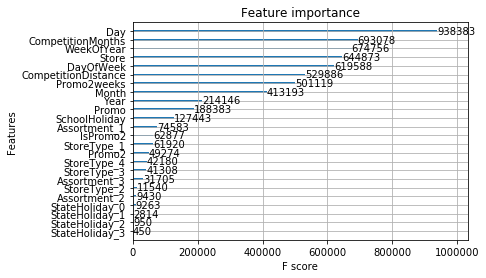

In [118]:
xgb.plot_importance(bst)
plt.show()

In [119]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

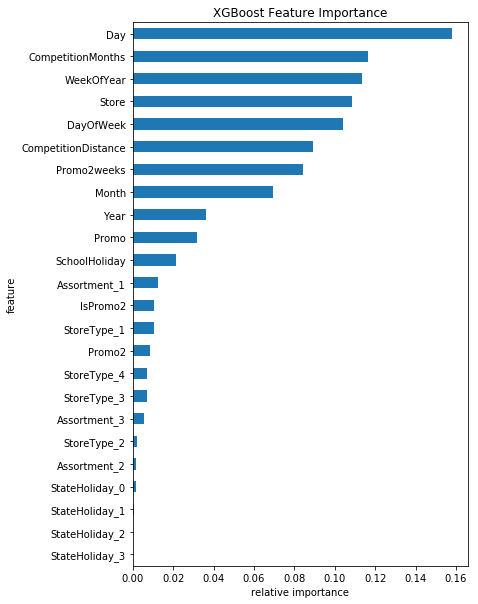

In [120]:
create_feature_map(X_train.columns)
importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
plt.show()

#### 模型及参数优化

In [123]:
# 提升树的数量
dtrain = xgb.DMatrix(X_all, np.log1p(y_all))
watchlist = [(dtrain, 'train')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.01
          }
num_trees = 20000

In [124]:
%%time
# 将所有数据做训练提交kaggle检查分数
bst_20000 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.18588	train-rmspe:0.999832
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.1042	train-rmspe:0.999806
[2]	train-rmse:8.02332	train-rmspe:0.999778
[3]	train-rmse:7.94327	train-rmspe:0.999748
[4]	train-rmse:7.864	train-rmspe:0.999715
[5]	train-rmse:7.78553	train-rmspe:0.999681
[6]	train-rmse:7.70785	train-rmspe:0.999644
[7]	train-rmse:7.63094	train-rmspe:0.999605
[8]	train-rmse:7.5548	train-rmspe:0.999562
[9]	train-rmse:7.47944	train-rmspe:0.999517
[10]	train-rmse:7.40482	train-rmspe:0.99947
[11]	train-rmse:7.33094	train-rmspe:0.999418
[12]	train-rmse:7.25781	train-rmspe:0.999364
[13]	train-rmse:7.18543	train-rmspe:0.999306
[14]	train-rmse:7.11375	train-rmspe:0.999244
[15]	train-rmse:7.04278	train-rmspe:0.999179
[16]	train-rmse:6.97255	train-rmspe:0.99911
[17]	train-rmse:6.90303	train-rmspe:0.999036
[18]	train-rmse:6.83419	train-rmspe:0.998957
[19]	train-rm

[179]	train-rmse:1.38839	train-rmspe:0.73552
[180]	train-rmse:1.37514	train-rmspe:0.732047
[181]	train-rmse:1.36201	train-rmspe:0.728568
[182]	train-rmse:1.34905	train-rmspe:0.725074
[183]	train-rmse:1.33612	train-rmspe:0.721592
[184]	train-rmse:1.3234	train-rmspe:0.718086
[185]	train-rmse:1.31081	train-rmspe:0.714574
[186]	train-rmse:1.29838	train-rmspe:0.711055
[187]	train-rmse:1.28608	train-rmspe:0.70753
[188]	train-rmse:1.27389	train-rmspe:0.704007
[189]	train-rmse:1.26181	train-rmspe:0.700481
[190]	train-rmse:1.24986	train-rmspe:0.696954
[191]	train-rmse:1.23806	train-rmspe:0.693419
[192]	train-rmse:1.22635	train-rmspe:0.68988
[193]	train-rmse:1.21466	train-rmspe:0.686359
[194]	train-rmse:1.20322	train-rmspe:0.682818
[195]	train-rmse:1.1919	train-rmspe:0.679276
[196]	train-rmse:1.18068	train-rmspe:0.675738
[197]	train-rmse:1.16957	train-rmspe:0.672196
[198]	train-rmse:1.15861	train-rmspe:0.668654
[199]	train-rmse:1.14774	train-rmspe:0.665117
[200]	train-rmse:1.13695	train-rmspe:0.

[355]	train-rmse:0.354714	train-rmspe:0.308217
[356]	train-rmse:0.353032	train-rmspe:0.307438
[357]	train-rmse:0.351422	train-rmspe:0.306698
[358]	train-rmse:0.34987	train-rmspe:0.306034
[359]	train-rmse:0.348389	train-rmspe:0.305412
[360]	train-rmse:0.346873	train-rmspe:0.304769
[361]	train-rmse:0.34527	train-rmspe:0.304023
[362]	train-rmse:0.343813	train-rmspe:0.303386
[363]	train-rmse:0.342329	train-rmspe:0.302754
[364]	train-rmse:0.340897	train-rmspe:0.30212
[365]	train-rmse:0.339514	train-rmspe:0.301558
[366]	train-rmse:0.338024	train-rmspe:0.300903
[367]	train-rmse:0.336703	train-rmspe:0.300416
[368]	train-rmse:0.335296	train-rmspe:0.29984
[369]	train-rmse:0.334029	train-rmspe:0.299368
[370]	train-rmse:0.332761	train-rmspe:0.298886
[371]	train-rmse:0.331432	train-rmspe:0.298353
[372]	train-rmse:0.330154	train-rmspe:0.297855
[373]	train-rmse:0.328749	train-rmspe:0.297246
[374]	train-rmse:0.327563	train-rmspe:0.29682
[375]	train-rmse:0.326332	train-rmspe:0.296299
[376]	train-rmse:0

[531]	train-rmse:0.242344	train-rmspe:0.272084
[532]	train-rmse:0.242173	train-rmspe:0.272077
[533]	train-rmse:0.241992	train-rmspe:0.272056
[534]	train-rmse:0.241864	train-rmspe:0.272108
[535]	train-rmse:0.241548	train-rmspe:0.271936
[536]	train-rmse:0.241225	train-rmspe:0.271767
[537]	train-rmse:0.241123	train-rmspe:0.271802
[538]	train-rmse:0.240954	train-rmspe:0.271789
[539]	train-rmse:0.240874	train-rmspe:0.271874
[540]	train-rmse:0.24057	train-rmspe:0.271634
[541]	train-rmse:0.240402	train-rmspe:0.271616
[542]	train-rmse:0.240288	train-rmspe:0.271649
[543]	train-rmse:0.24011	train-rmspe:0.271626
[544]	train-rmse:0.239947	train-rmspe:0.271604
[545]	train-rmse:0.239743	train-rmspe:0.271541
[546]	train-rmse:0.239628	train-rmspe:0.271557
[547]	train-rmse:0.239468	train-rmspe:0.271492
[548]	train-rmse:0.239159	train-rmspe:0.271295
[549]	train-rmse:0.238792	train-rmspe:0.270995
[550]	train-rmse:0.238308	train-rmspe:0.270656
[551]	train-rmse:0.238163	train-rmspe:0.270645
[552]	train-rms

[707]	train-rmse:0.215531	train-rmspe:0.255577
[708]	train-rmse:0.215457	train-rmspe:0.255551
[709]	train-rmse:0.215435	train-rmspe:0.255576
[710]	train-rmse:0.215392	train-rmspe:0.255561
[711]	train-rmse:0.215253	train-rmspe:0.255325
[712]	train-rmse:0.215188	train-rmspe:0.255289
[713]	train-rmse:0.215077	train-rmspe:0.255211
[714]	train-rmse:0.215057	train-rmspe:0.255236
[715]	train-rmse:0.215013	train-rmspe:0.255219
[716]	train-rmse:0.214698	train-rmspe:0.254935
[717]	train-rmse:0.214643	train-rmspe:0.254905
[718]	train-rmse:0.214591	train-rmspe:0.254877
[719]	train-rmse:0.214571	train-rmspe:0.254898
[720]	train-rmse:0.214509	train-rmspe:0.254862
[721]	train-rmse:0.214472	train-rmspe:0.254853
[722]	train-rmse:0.214296	train-rmspe:0.254292
[723]	train-rmse:0.214187	train-rmspe:0.254197
[724]	train-rmse:0.213829	train-rmspe:0.253878
[725]	train-rmse:0.213767	train-rmspe:0.25381
[726]	train-rmse:0.213662	train-rmspe:0.25374
[727]	train-rmse:0.213579	train-rmspe:0.253678
[728]	train-rms

[882]	train-rmse:0.193733	train-rmspe:0.233019
[883]	train-rmse:0.193526	train-rmspe:0.23269
[884]	train-rmse:0.193348	train-rmspe:0.232524
[885]	train-rmse:0.19332	train-rmspe:0.232509
[886]	train-rmse:0.193041	train-rmspe:0.232239
[887]	train-rmse:0.192999	train-rmspe:0.232207
[888]	train-rmse:0.19297	train-rmspe:0.232179
[889]	train-rmse:0.192936	train-rmspe:0.232145
[890]	train-rmse:0.192712	train-rmspe:0.231939
[891]	train-rmse:0.192685	train-rmspe:0.231883
[892]	train-rmse:0.192662	train-rmspe:0.231785
[893]	train-rmse:0.192598	train-rmspe:0.23171
[894]	train-rmse:0.192557	train-rmspe:0.231645
[895]	train-rmse:0.192499	train-rmspe:0.23159
[896]	train-rmse:0.192461	train-rmspe:0.231539
[897]	train-rmse:0.192319	train-rmspe:0.231392
[898]	train-rmse:0.192172	train-rmspe:0.231246
[899]	train-rmse:0.192032	train-rmspe:0.23111
[900]	train-rmse:0.191931	train-rmspe:0.231011
[901]	train-rmse:0.191697	train-rmspe:0.230767
[902]	train-rmse:0.19151	train-rmspe:0.230595
[903]	train-rmse:0.1

[1057]	train-rmse:0.176417	train-rmspe:0.213644
[1058]	train-rmse:0.176377	train-rmspe:0.213593
[1059]	train-rmse:0.176253	train-rmspe:0.213492
[1060]	train-rmse:0.176142	train-rmspe:0.213381
[1061]	train-rmse:0.176079	train-rmspe:0.213287
[1062]	train-rmse:0.176025	train-rmspe:0.213205
[1063]	train-rmse:0.176004	train-rmspe:0.213186
[1064]	train-rmse:0.175888	train-rmspe:0.213072
[1065]	train-rmse:0.175809	train-rmspe:0.212996
[1066]	train-rmse:0.175579	train-rmspe:0.21278
[1067]	train-rmse:0.175456	train-rmspe:0.212658
[1068]	train-rmse:0.175315	train-rmspe:0.212549
[1069]	train-rmse:0.175284	train-rmspe:0.212515
[1070]	train-rmse:0.175198	train-rmspe:0.212425
[1071]	train-rmse:0.17509	train-rmspe:0.21232
[1072]	train-rmse:0.175049	train-rmspe:0.21228
[1073]	train-rmse:0.175	train-rmspe:0.212244
[1074]	train-rmse:0.174906	train-rmspe:0.212164
[1075]	train-rmse:0.17478	train-rmspe:0.212069
[1076]	train-rmse:0.174716	train-rmspe:0.212021
[1077]	train-rmse:0.174615	train-rmspe:0.21192
[

[1229]	train-rmse:0.163562	train-rmspe:0.199785
[1230]	train-rmse:0.163491	train-rmspe:0.199713
[1231]	train-rmse:0.163409	train-rmspe:0.199637
[1232]	train-rmse:0.163371	train-rmspe:0.199605
[1233]	train-rmse:0.163264	train-rmspe:0.199497
[1234]	train-rmse:0.163197	train-rmspe:0.199429
[1235]	train-rmse:0.163117	train-rmspe:0.19936
[1236]	train-rmse:0.163076	train-rmspe:0.199319
[1237]	train-rmse:0.162987	train-rmspe:0.199234
[1238]	train-rmse:0.162958	train-rmspe:0.199208
[1239]	train-rmse:0.162903	train-rmspe:0.199137
[1240]	train-rmse:0.162871	train-rmspe:0.199105
[1241]	train-rmse:0.162858	train-rmspe:0.199087
[1242]	train-rmse:0.162741	train-rmspe:0.198974
[1243]	train-rmse:0.162673	train-rmspe:0.198901
[1244]	train-rmse:0.162623	train-rmspe:0.198863
[1245]	train-rmse:0.162566	train-rmspe:0.198816
[1246]	train-rmse:0.162496	train-rmspe:0.198762
[1247]	train-rmse:0.162457	train-rmspe:0.198734
[1248]	train-rmse:0.162398	train-rmspe:0.198692
[1249]	train-rmse:0.162259	train-rmspe:0.

[1401]	train-rmse:0.152483	train-rmspe:0.183919
[1402]	train-rmse:0.152456	train-rmspe:0.183892
[1403]	train-rmse:0.152404	train-rmspe:0.183844
[1404]	train-rmse:0.152363	train-rmspe:0.183556
[1405]	train-rmse:0.152321	train-rmspe:0.183521
[1406]	train-rmse:0.152293	train-rmspe:0.18328
[1407]	train-rmse:0.152254	train-rmspe:0.183248
[1408]	train-rmse:0.152229	train-rmspe:0.183213
[1409]	train-rmse:0.152186	train-rmspe:0.183174
[1410]	train-rmse:0.152124	train-rmspe:0.183115
[1411]	train-rmse:0.152031	train-rmspe:0.18302
[1412]	train-rmse:0.151928	train-rmspe:0.182934
[1413]	train-rmse:0.151911	train-rmspe:0.182919
[1414]	train-rmse:0.151852	train-rmspe:0.18287
[1415]	train-rmse:0.151798	train-rmspe:0.182816
[1416]	train-rmse:0.151753	train-rmspe:0.182774
[1417]	train-rmse:0.151656	train-rmspe:0.182683
[1418]	train-rmse:0.151613	train-rmspe:0.181881
[1419]	train-rmse:0.151581	train-rmspe:0.181665
[1420]	train-rmse:0.15146	train-rmspe:0.181534
[1421]	train-rmse:0.151405	train-rmspe:0.181

[1573]	train-rmse:0.143971	train-rmspe:0.168029
[1574]	train-rmse:0.143911	train-rmspe:0.167972
[1575]	train-rmse:0.143865	train-rmspe:0.167799
[1576]	train-rmse:0.143834	train-rmspe:0.167779
[1577]	train-rmse:0.143789	train-rmspe:0.167736
[1578]	train-rmse:0.14375	train-rmspe:0.167696
[1579]	train-rmse:0.143643	train-rmspe:0.167575
[1580]	train-rmse:0.143581	train-rmspe:0.167511
[1581]	train-rmse:0.1435	train-rmspe:0.167432
[1582]	train-rmse:0.143415	train-rmspe:0.167349
[1583]	train-rmse:0.143387	train-rmspe:0.167324
[1584]	train-rmse:0.143287	train-rmspe:0.167223
[1585]	train-rmse:0.143232	train-rmspe:0.167183
[1586]	train-rmse:0.143153	train-rmspe:0.167133
[1587]	train-rmse:0.143119	train-rmspe:0.167103
[1588]	train-rmse:0.143094	train-rmspe:0.167078
[1589]	train-rmse:0.143069	train-rmspe:0.167036
[1590]	train-rmse:0.143037	train-rmspe:0.167017
[1591]	train-rmse:0.142984	train-rmspe:0.166972
[1592]	train-rmse:0.142927	train-rmspe:0.166911
[1593]	train-rmse:0.142885	train-rmspe:0.16

[1745]	train-rmse:0.136776	train-rmspe:0.157877
[1746]	train-rmse:0.136745	train-rmspe:0.157852
[1747]	train-rmse:0.136673	train-rmspe:0.157779
[1748]	train-rmse:0.136628	train-rmspe:0.157702
[1749]	train-rmse:0.136541	train-rmspe:0.157615
[1750]	train-rmse:0.136517	train-rmspe:0.157594
[1751]	train-rmse:0.136496	train-rmspe:0.157556
[1752]	train-rmse:0.136457	train-rmspe:0.157508
[1753]	train-rmse:0.136417	train-rmspe:0.157473
[1754]	train-rmse:0.136397	train-rmspe:0.157457
[1755]	train-rmse:0.136369	train-rmspe:0.157447
[1756]	train-rmse:0.136316	train-rmspe:0.157394
[1757]	train-rmse:0.13627	train-rmspe:0.157357
[1758]	train-rmse:0.136217	train-rmspe:0.157307
[1759]	train-rmse:0.136188	train-rmspe:0.157285
[1760]	train-rmse:0.136139	train-rmspe:0.156806
[1761]	train-rmse:0.136071	train-rmspe:0.156741
[1762]	train-rmse:0.136009	train-rmspe:0.156682
[1763]	train-rmse:0.135976	train-rmspe:0.15665
[1764]	train-rmse:0.135941	train-rmspe:0.156618
[1765]	train-rmse:0.135909	train-rmspe:0.1

[1917]	train-rmse:0.130237	train-rmspe:0.149661
[1918]	train-rmse:0.130205	train-rmspe:0.149469
[1919]	train-rmse:0.130174	train-rmspe:0.149443
[1920]	train-rmse:0.130103	train-rmspe:0.149379
[1921]	train-rmse:0.13008	train-rmspe:0.149357
[1922]	train-rmse:0.13002	train-rmspe:0.149297
[1923]	train-rmse:0.129999	train-rmspe:0.148871
[1924]	train-rmse:0.129985	train-rmspe:0.148767
[1925]	train-rmse:0.129959	train-rmspe:0.148751
[1926]	train-rmse:0.129943	train-rmspe:0.148732
[1927]	train-rmse:0.129905	train-rmspe:0.148695
[1928]	train-rmse:0.129888	train-rmspe:0.148679
[1929]	train-rmse:0.129842	train-rmspe:0.148641
[1930]	train-rmse:0.129815	train-rmspe:0.148511
[1931]	train-rmse:0.129777	train-rmspe:0.148454
[1932]	train-rmse:0.129746	train-rmspe:0.148398
[1933]	train-rmse:0.129695	train-rmspe:0.148329
[1934]	train-rmse:0.129672	train-rmspe:0.148303
[1935]	train-rmse:0.129655	train-rmspe:0.14829
[1936]	train-rmse:0.129624	train-rmspe:0.148262
[1937]	train-rmse:0.129599	train-rmspe:0.14

[2089]	train-rmse:0.124905	train-rmspe:0.142616
[2090]	train-rmse:0.124881	train-rmspe:0.142591
[2091]	train-rmse:0.124857	train-rmspe:0.142557
[2092]	train-rmse:0.124841	train-rmspe:0.142548
[2093]	train-rmse:0.124817	train-rmspe:0.142524
[2094]	train-rmse:0.124789	train-rmspe:0.142491
[2095]	train-rmse:0.124767	train-rmspe:0.142467
[2096]	train-rmse:0.124744	train-rmspe:0.142443
[2097]	train-rmse:0.124733	train-rmspe:0.142432
[2098]	train-rmse:0.12471	train-rmspe:0.14241
[2099]	train-rmse:0.124688	train-rmspe:0.142393
[2100]	train-rmse:0.124674	train-rmspe:0.142377
[2101]	train-rmse:0.12466	train-rmspe:0.142017
[2102]	train-rmse:0.124652	train-rmspe:0.142008
[2103]	train-rmse:0.124641	train-rmspe:0.141997
[2104]	train-rmse:0.124625	train-rmspe:0.141982
[2105]	train-rmse:0.12459	train-rmspe:0.14195
[2106]	train-rmse:0.124578	train-rmspe:0.141939
[2107]	train-rmse:0.124562	train-rmspe:0.141923
[2108]	train-rmse:0.124545	train-rmspe:0.141905
[2109]	train-rmse:0.124537	train-rmspe:0.1418

[2261]	train-rmse:0.121097	train-rmspe:0.137862
[2262]	train-rmse:0.121081	train-rmspe:0.137847
[2263]	train-rmse:0.121072	train-rmspe:0.137839
[2264]	train-rmse:0.121059	train-rmspe:0.137829
[2265]	train-rmse:0.121035	train-rmspe:0.137806
[2266]	train-rmse:0.121013	train-rmspe:0.137786
[2267]	train-rmse:0.120982	train-rmspe:0.137758
[2268]	train-rmse:0.120959	train-rmspe:0.13773
[2269]	train-rmse:0.12092	train-rmspe:0.137694
[2270]	train-rmse:0.120911	train-rmspe:0.137687
[2271]	train-rmse:0.120898	train-rmspe:0.13767
[2272]	train-rmse:0.120881	train-rmspe:0.137658
[2273]	train-rmse:0.12085	train-rmspe:0.137638
[2274]	train-rmse:0.120831	train-rmspe:0.137618
[2275]	train-rmse:0.120826	train-rmspe:0.137614
[2276]	train-rmse:0.120817	train-rmspe:0.137577
[2277]	train-rmse:0.120805	train-rmspe:0.137565
[2278]	train-rmse:0.120798	train-rmspe:0.137422
[2279]	train-rmse:0.120785	train-rmspe:0.137411
[2280]	train-rmse:0.12075	train-rmspe:0.137379
[2281]	train-rmse:0.120733	train-rmspe:0.1373

[2433]	train-rmse:0.1177	train-rmspe:0.134152
[2434]	train-rmse:0.117687	train-rmspe:0.134135
[2435]	train-rmse:0.117659	train-rmspe:0.134112
[2436]	train-rmse:0.117627	train-rmspe:0.134064
[2437]	train-rmse:0.117599	train-rmspe:0.13404
[2438]	train-rmse:0.117577	train-rmspe:0.13403
[2439]	train-rmse:0.117566	train-rmspe:0.134014
[2440]	train-rmse:0.117545	train-rmspe:0.133973
[2441]	train-rmse:0.117528	train-rmspe:0.133957
[2442]	train-rmse:0.117512	train-rmspe:0.133941
[2443]	train-rmse:0.117492	train-rmspe:0.133918
[2444]	train-rmse:0.117478	train-rmspe:0.133905
[2445]	train-rmse:0.11746	train-rmspe:0.133885
[2446]	train-rmse:0.117449	train-rmspe:0.133856
[2447]	train-rmse:0.117423	train-rmspe:0.133832
[2448]	train-rmse:0.117418	train-rmspe:0.133826
[2449]	train-rmse:0.117394	train-rmspe:0.1338
[2450]	train-rmse:0.117391	train-rmspe:0.133798
[2451]	train-rmse:0.117374	train-rmspe:0.133743
[2452]	train-rmse:0.11737	train-rmspe:0.133741
[2453]	train-rmse:0.117335	train-rmspe:0.13371
[

[2605]	train-rmse:0.114319	train-rmspe:0.129984
[2606]	train-rmse:0.114308	train-rmspe:0.129971
[2607]	train-rmse:0.11429	train-rmspe:0.129951
[2608]	train-rmse:0.11428	train-rmspe:0.12994
[2609]	train-rmse:0.114263	train-rmspe:0.129915
[2610]	train-rmse:0.114236	train-rmspe:0.129892
[2611]	train-rmse:0.114224	train-rmspe:0.129878
[2612]	train-rmse:0.114221	train-rmspe:0.129859
[2613]	train-rmse:0.114207	train-rmspe:0.129795
[2614]	train-rmse:0.114198	train-rmspe:0.129699
[2615]	train-rmse:0.114172	train-rmspe:0.129679
[2616]	train-rmse:0.114164	train-rmspe:0.129673
[2617]	train-rmse:0.114154	train-rmspe:0.129664
[2618]	train-rmse:0.114144	train-rmspe:0.129658
[2619]	train-rmse:0.11413	train-rmspe:0.129639
[2620]	train-rmse:0.114119	train-rmspe:0.129622
[2621]	train-rmse:0.114098	train-rmspe:0.129601
[2622]	train-rmse:0.114075	train-rmspe:0.12958
[2623]	train-rmse:0.114055	train-rmspe:0.129565
[2624]	train-rmse:0.114033	train-rmspe:0.129551
[2625]	train-rmse:0.114016	train-rmspe:0.1295

[2777]	train-rmse:0.111561	train-rmspe:0.125627
[2778]	train-rmse:0.111549	train-rmspe:0.125616
[2779]	train-rmse:0.111538	train-rmspe:0.125612
[2780]	train-rmse:0.11152	train-rmspe:0.125596
[2781]	train-rmse:0.111497	train-rmspe:0.125576
[2782]	train-rmse:0.111466	train-rmspe:0.125554
[2783]	train-rmse:0.111444	train-rmspe:0.125533
[2784]	train-rmse:0.111418	train-rmspe:0.12551
[2785]	train-rmse:0.11141	train-rmspe:0.125504
[2786]	train-rmse:0.111397	train-rmspe:0.125476
[2787]	train-rmse:0.111369	train-rmspe:0.125457
[2788]	train-rmse:0.111354	train-rmspe:0.125444
[2789]	train-rmse:0.111338	train-rmspe:0.125435
[2790]	train-rmse:0.111331	train-rmspe:0.125424
[2791]	train-rmse:0.111315	train-rmspe:0.125403
[2792]	train-rmse:0.111307	train-rmspe:0.125395
[2793]	train-rmse:0.111295	train-rmspe:0.125377
[2794]	train-rmse:0.111287	train-rmspe:0.125369
[2795]	train-rmse:0.111264	train-rmspe:0.125354
[2796]	train-rmse:0.111248	train-rmspe:0.125342
[2797]	train-rmse:0.111225	train-rmspe:0.12

[2949]	train-rmse:0.108842	train-rmspe:0.122859
[2950]	train-rmse:0.108831	train-rmspe:0.122848
[2951]	train-rmse:0.108801	train-rmspe:0.122825
[2952]	train-rmse:0.108798	train-rmspe:0.122822
[2953]	train-rmse:0.108791	train-rmspe:0.122813
[2954]	train-rmse:0.108778	train-rmspe:0.122792
[2955]	train-rmse:0.108762	train-rmspe:0.122779
[2956]	train-rmse:0.108755	train-rmspe:0.12277
[2957]	train-rmse:0.10874	train-rmspe:0.122757
[2958]	train-rmse:0.108723	train-rmspe:0.122735
[2959]	train-rmse:0.108715	train-rmspe:0.122728
[2960]	train-rmse:0.108691	train-rmspe:0.122702
[2961]	train-rmse:0.108672	train-rmspe:0.122686
[2962]	train-rmse:0.108659	train-rmspe:0.122663
[2963]	train-rmse:0.108655	train-rmspe:0.122658
[2964]	train-rmse:0.108642	train-rmspe:0.122648
[2965]	train-rmse:0.108619	train-rmspe:0.122637
[2966]	train-rmse:0.108598	train-rmspe:0.122612
[2967]	train-rmse:0.108584	train-rmspe:0.122606
[2968]	train-rmse:0.108558	train-rmspe:0.122579
[2969]	train-rmse:0.10855	train-rmspe:0.12

[3121]	train-rmse:0.106518	train-rmspe:0.11988
[3122]	train-rmse:0.106514	train-rmspe:0.119815
[3123]	train-rmse:0.106495	train-rmspe:0.119804
[3124]	train-rmse:0.106478	train-rmspe:0.119788
[3125]	train-rmse:0.106461	train-rmspe:0.11978
[3126]	train-rmse:0.106446	train-rmspe:0.119768
[3127]	train-rmse:0.106426	train-rmspe:0.119753
[3128]	train-rmse:0.106407	train-rmspe:0.119733
[3129]	train-rmse:0.106391	train-rmspe:0.119703
[3130]	train-rmse:0.106378	train-rmspe:0.11969
[3131]	train-rmse:0.106368	train-rmspe:0.119676
[3132]	train-rmse:0.106362	train-rmspe:0.119661
[3133]	train-rmse:0.106353	train-rmspe:0.119654
[3134]	train-rmse:0.106346	train-rmspe:0.119651
[3135]	train-rmse:0.106341	train-rmspe:0.119644
[3136]	train-rmse:0.10632	train-rmspe:0.119625
[3137]	train-rmse:0.106303	train-rmspe:0.11961
[3138]	train-rmse:0.10628	train-rmspe:0.119595
[3139]	train-rmse:0.10627	train-rmspe:0.119586
[3140]	train-rmse:0.106253	train-rmspe:0.119574
[3141]	train-rmse:0.106244	train-rmspe:0.119565

[3293]	train-rmse:0.104205	train-rmspe:0.117486
[3294]	train-rmse:0.104202	train-rmspe:0.117484
[3295]	train-rmse:0.104194	train-rmspe:0.11748
[3296]	train-rmse:0.104187	train-rmspe:0.117472
[3297]	train-rmse:0.104172	train-rmspe:0.117458
[3298]	train-rmse:0.104159	train-rmspe:0.117446
[3299]	train-rmse:0.104147	train-rmspe:0.117436
[3300]	train-rmse:0.104137	train-rmspe:0.117427
[3301]	train-rmse:0.104132	train-rmspe:0.117421
[3302]	train-rmse:0.104126	train-rmspe:0.117417
[3303]	train-rmse:0.104102	train-rmspe:0.117403
[3304]	train-rmse:0.104085	train-rmspe:0.11739
[3305]	train-rmse:0.104068	train-rmspe:0.117366
[3306]	train-rmse:0.104063	train-rmspe:0.11727
[3307]	train-rmse:0.104054	train-rmspe:0.117262
[3308]	train-rmse:0.10404	train-rmspe:0.117249
[3309]	train-rmse:0.104035	train-rmspe:0.117242
[3310]	train-rmse:0.104021	train-rmspe:0.117232
[3311]	train-rmse:0.104013	train-rmspe:0.117224
[3312]	train-rmse:0.104004	train-rmspe:0.117216
[3313]	train-rmse:0.103993	train-rmspe:0.117

[3465]	train-rmse:0.102171	train-rmspe:0.115387
[3466]	train-rmse:0.102164	train-rmspe:0.115258
[3467]	train-rmse:0.102152	train-rmspe:0.115247
[3468]	train-rmse:0.102142	train-rmspe:0.11524
[3469]	train-rmse:0.102127	train-rmspe:0.115225
[3470]	train-rmse:0.102111	train-rmspe:0.115213
[3471]	train-rmse:0.102096	train-rmspe:0.115203
[3472]	train-rmse:0.102092	train-rmspe:0.115201
[3473]	train-rmse:0.102078	train-rmspe:0.11519
[3474]	train-rmse:0.102047	train-rmspe:0.115169
[3475]	train-rmse:0.102026	train-rmspe:0.11515
[3476]	train-rmse:0.102022	train-rmspe:0.115148
[3477]	train-rmse:0.102018	train-rmspe:0.115058
[3478]	train-rmse:0.102007	train-rmspe:0.115041
[3479]	train-rmse:0.102	train-rmspe:0.115033
[3480]	train-rmse:0.101997	train-rmspe:0.115031
[3481]	train-rmse:0.101993	train-rmspe:0.115027
[3482]	train-rmse:0.101979	train-rmspe:0.115016
[3483]	train-rmse:0.101969	train-rmspe:0.115006
[3484]	train-rmse:0.101949	train-rmspe:0.114995
[3485]	train-rmse:0.101937	train-rmspe:0.11498

[3637]	train-rmse:0.100385	train-rmspe:0.113327
[3638]	train-rmse:0.10037	train-rmspe:0.113321
[3639]	train-rmse:0.100368	train-rmspe:0.113318
[3640]	train-rmse:0.100345	train-rmspe:0.113299
[3641]	train-rmse:0.100334	train-rmspe:0.11329
[3642]	train-rmse:0.100323	train-rmspe:0.113281
[3643]	train-rmse:0.100299	train-rmspe:0.113267
[3644]	train-rmse:0.100294	train-rmspe:0.113262
[3645]	train-rmse:0.100284	train-rmspe:0.113252
[3646]	train-rmse:0.10028	train-rmspe:0.113245
[3647]	train-rmse:0.100278	train-rmspe:0.113247
[3648]	train-rmse:0.10027	train-rmspe:0.113242
[3649]	train-rmse:0.100263	train-rmspe:0.113234
[3650]	train-rmse:0.100255	train-rmspe:0.113221
[3651]	train-rmse:0.100247	train-rmspe:0.1132
[3652]	train-rmse:0.100242	train-rmspe:0.113196
[3653]	train-rmse:0.100224	train-rmspe:0.113172
[3654]	train-rmse:0.100221	train-rmspe:0.113168
[3655]	train-rmse:0.100213	train-rmspe:0.113164
[3656]	train-rmse:0.100201	train-rmspe:0.11315
[3657]	train-rmse:0.100197	train-rmspe:0.113147

[3809]	train-rmse:0.098687	train-rmspe:0.111572
[3810]	train-rmse:0.09867	train-rmspe:0.111554
[3811]	train-rmse:0.098665	train-rmspe:0.111549
[3812]	train-rmse:0.098656	train-rmspe:0.111536
[3813]	train-rmse:0.098647	train-rmspe:0.111526
[3814]	train-rmse:0.098636	train-rmspe:0.111518
[3815]	train-rmse:0.09863	train-rmspe:0.11151
[3816]	train-rmse:0.098625	train-rmspe:0.111506
[3817]	train-rmse:0.098611	train-rmspe:0.111484
[3818]	train-rmse:0.098598	train-rmspe:0.111469
[3819]	train-rmse:0.098593	train-rmspe:0.111463
[3820]	train-rmse:0.098579	train-rmspe:0.111449
[3821]	train-rmse:0.098565	train-rmspe:0.111441
[3822]	train-rmse:0.09856	train-rmspe:0.111435
[3823]	train-rmse:0.098551	train-rmspe:0.111431
[3824]	train-rmse:0.098549	train-rmspe:0.111427
[3825]	train-rmse:0.09853	train-rmspe:0.111412
[3826]	train-rmse:0.098521	train-rmspe:0.111401
[3827]	train-rmse:0.098513	train-rmspe:0.111393
[3828]	train-rmse:0.098503	train-rmspe:0.111384
[3829]	train-rmse:0.098495	train-rmspe:0.1113

[3981]	train-rmse:0.09712	train-rmspe:0.109881
[3982]	train-rmse:0.09711	train-rmspe:0.109871
[3983]	train-rmse:0.097092	train-rmspe:0.109862
[3984]	train-rmse:0.097087	train-rmspe:0.109857
[3985]	train-rmse:0.097081	train-rmspe:0.109851
[3986]	train-rmse:0.097067	train-rmspe:0.109831
[3987]	train-rmse:0.09705	train-rmspe:0.109811
[3988]	train-rmse:0.097041	train-rmspe:0.109756
[3989]	train-rmse:0.097037	train-rmspe:0.109753
[3990]	train-rmse:0.097031	train-rmspe:0.109747
[3991]	train-rmse:0.097027	train-rmspe:0.109731
[3992]	train-rmse:0.097022	train-rmspe:0.109728
[3993]	train-rmse:0.097017	train-rmspe:0.109723
[3994]	train-rmse:0.097008	train-rmspe:0.10972
[3995]	train-rmse:0.097004	train-rmspe:0.109716
[3996]	train-rmse:0.097	train-rmspe:0.109713
[3997]	train-rmse:0.096994	train-rmspe:0.109707
[3998]	train-rmse:0.096979	train-rmspe:0.109698
[3999]	train-rmse:0.096976	train-rmspe:0.109695
[4000]	train-rmse:0.096955	train-rmspe:0.109682
[4001]	train-rmse:0.09694	train-rmspe:0.109665


[4153]	train-rmse:0.095618	train-rmspe:0.107744
[4154]	train-rmse:0.095608	train-rmspe:0.107727
[4155]	train-rmse:0.095603	train-rmspe:0.107723
[4156]	train-rmse:0.095591	train-rmspe:0.10771
[4157]	train-rmse:0.095589	train-rmspe:0.107709
[4158]	train-rmse:0.095582	train-rmspe:0.107699
[4159]	train-rmse:0.095573	train-rmspe:0.107695
[4160]	train-rmse:0.095562	train-rmspe:0.107686
[4161]	train-rmse:0.095546	train-rmspe:0.107673
[4162]	train-rmse:0.095539	train-rmspe:0.107663
[4163]	train-rmse:0.095525	train-rmspe:0.107653
[4164]	train-rmse:0.095523	train-rmspe:0.107652
[4165]	train-rmse:0.09552	train-rmspe:0.10765
[4166]	train-rmse:0.095517	train-rmspe:0.107647
[4167]	train-rmse:0.095509	train-rmspe:0.107643
[4168]	train-rmse:0.095506	train-rmspe:0.107641
[4169]	train-rmse:0.095494	train-rmspe:0.107631
[4170]	train-rmse:0.095479	train-rmspe:0.107619
[4171]	train-rmse:0.095473	train-rmspe:0.107611
[4172]	train-rmse:0.095465	train-rmspe:0.107604
[4173]	train-rmse:0.095464	train-rmspe:0.10

[4325]	train-rmse:0.094328	train-rmspe:0.106302
[4326]	train-rmse:0.09432	train-rmspe:0.106294
[4327]	train-rmse:0.094317	train-rmspe:0.10629
[4328]	train-rmse:0.094309	train-rmspe:0.10628
[4329]	train-rmse:0.094301	train-rmspe:0.106275
[4330]	train-rmse:0.094295	train-rmspe:0.10627
[4331]	train-rmse:0.094286	train-rmspe:0.106261
[4332]	train-rmse:0.094276	train-rmspe:0.106254
[4333]	train-rmse:0.094271	train-rmspe:0.106219
[4334]	train-rmse:0.094266	train-rmspe:0.106216
[4335]	train-rmse:0.094258	train-rmspe:0.106207
[4336]	train-rmse:0.094251	train-rmspe:0.106199
[4337]	train-rmse:0.094245	train-rmspe:0.106194
[4338]	train-rmse:0.094235	train-rmspe:0.106165
[4339]	train-rmse:0.094221	train-rmspe:0.106149
[4340]	train-rmse:0.094216	train-rmspe:0.106143
[4341]	train-rmse:0.094204	train-rmspe:0.106132
[4342]	train-rmse:0.09419	train-rmspe:0.106115
[4343]	train-rmse:0.094183	train-rmspe:0.106109
[4344]	train-rmse:0.094175	train-rmspe:0.106102
[4345]	train-rmse:0.094173	train-rmspe:0.1060

[4497]	train-rmse:0.093084	train-rmspe:0.104272
[4498]	train-rmse:0.093081	train-rmspe:0.104267
[4499]	train-rmse:0.093071	train-rmspe:0.104255
[4500]	train-rmse:0.09306	train-rmspe:0.104243
[4501]	train-rmse:0.093057	train-rmspe:0.104239
[4502]	train-rmse:0.093054	train-rmspe:0.104236
[4503]	train-rmse:0.093049	train-rmspe:0.104232
[4504]	train-rmse:0.093036	train-rmspe:0.104223
[4505]	train-rmse:0.093025	train-rmspe:0.104213
[4506]	train-rmse:0.093019	train-rmspe:0.104196
[4507]	train-rmse:0.093014	train-rmspe:0.10419
[4508]	train-rmse:0.09301	train-rmspe:0.104185
[4509]	train-rmse:0.093006	train-rmspe:0.10418
[4510]	train-rmse:0.092999	train-rmspe:0.104172
[4511]	train-rmse:0.092996	train-rmspe:0.104167
[4512]	train-rmse:0.092983	train-rmspe:0.104159
[4513]	train-rmse:0.09298	train-rmspe:0.10415
[4514]	train-rmse:0.092972	train-rmspe:0.104141
[4515]	train-rmse:0.092965	train-rmspe:0.104133
[4516]	train-rmse:0.092958	train-rmspe:0.104128
[4517]	train-rmse:0.092956	train-rmspe:0.10412

[4669]	train-rmse:0.091908	train-rmspe:0.102746
[4670]	train-rmse:0.091895	train-rmspe:0.102736
[4671]	train-rmse:0.091888	train-rmspe:0.102724
[4672]	train-rmse:0.091878	train-rmspe:0.102718
[4673]	train-rmse:0.091872	train-rmspe:0.102712
[4674]	train-rmse:0.091862	train-rmspe:0.1027
[4675]	train-rmse:0.09186	train-rmspe:0.102698
[4676]	train-rmse:0.091856	train-rmspe:0.102694
[4677]	train-rmse:0.091855	train-rmspe:0.102693
[4678]	train-rmse:0.091841	train-rmspe:0.102682
[4679]	train-rmse:0.091827	train-rmspe:0.102652
[4680]	train-rmse:0.091813	train-rmspe:0.102642
[4681]	train-rmse:0.091807	train-rmspe:0.102636
[4682]	train-rmse:0.091804	train-rmspe:0.102629
[4683]	train-rmse:0.091802	train-rmspe:0.102627
[4684]	train-rmse:0.091797	train-rmspe:0.102623
[4685]	train-rmse:0.091793	train-rmspe:0.102619
[4686]	train-rmse:0.091787	train-rmspe:0.102614
[4687]	train-rmse:0.09178	train-rmspe:0.102607
[4688]	train-rmse:0.091777	train-rmspe:0.102605
[4689]	train-rmse:0.091775	train-rmspe:0.102

[4841]	train-rmse:0.090825	train-rmspe:0.101301
[4842]	train-rmse:0.090819	train-rmspe:0.101295
[4843]	train-rmse:0.090814	train-rmspe:0.101287
[4844]	train-rmse:0.090808	train-rmspe:0.101281
[4845]	train-rmse:0.0908	train-rmspe:0.101266
[4846]	train-rmse:0.090794	train-rmspe:0.101262
[4847]	train-rmse:0.090792	train-rmspe:0.101251
[4848]	train-rmse:0.09078	train-rmspe:0.101239
[4849]	train-rmse:0.090768	train-rmspe:0.101223
[4850]	train-rmse:0.090763	train-rmspe:0.101221
[4851]	train-rmse:0.090758	train-rmspe:0.101217
[4852]	train-rmse:0.090754	train-rmspe:0.101215
[4853]	train-rmse:0.090748	train-rmspe:0.10121
[4854]	train-rmse:0.090744	train-rmspe:0.101208
[4855]	train-rmse:0.090734	train-rmspe:0.101201
[4856]	train-rmse:0.090729	train-rmspe:0.101193
[4857]	train-rmse:0.090723	train-rmspe:0.101189
[4858]	train-rmse:0.09072	train-rmspe:0.101185
[4859]	train-rmse:0.090716	train-rmspe:0.101181
[4860]	train-rmse:0.090709	train-rmspe:0.101175
[4861]	train-rmse:0.0907	train-rmspe:0.101167

[5013]	train-rmse:0.089744	train-rmspe:0.099374
[5014]	train-rmse:0.089737	train-rmspe:0.099369
[5015]	train-rmse:0.089735	train-rmspe:0.099367
[5016]	train-rmse:0.089732	train-rmspe:0.099364
[5017]	train-rmse:0.089729	train-rmspe:0.099362
[5018]	train-rmse:0.089724	train-rmspe:0.099353
[5019]	train-rmse:0.089718	train-rmspe:0.099348
[5020]	train-rmse:0.089713	train-rmspe:0.099345
[5021]	train-rmse:0.089706	train-rmspe:0.099337
[5022]	train-rmse:0.089701	train-rmspe:0.099333
[5023]	train-rmse:0.089695	train-rmspe:0.099327
[5024]	train-rmse:0.089693	train-rmspe:0.099325
[5025]	train-rmse:0.089688	train-rmspe:0.099319
[5026]	train-rmse:0.089685	train-rmspe:0.099317
[5027]	train-rmse:0.089675	train-rmspe:0.099309
[5028]	train-rmse:0.089668	train-rmspe:0.099267
[5029]	train-rmse:0.089663	train-rmspe:0.09926
[5030]	train-rmse:0.08966	train-rmspe:0.099258
[5031]	train-rmse:0.089649	train-rmspe:0.09924
[5032]	train-rmse:0.089642	train-rmspe:0.099232
[5033]	train-rmse:0.089634	train-rmspe:0.09

[5185]	train-rmse:0.088786	train-rmspe:0.098239
[5186]	train-rmse:0.088778	train-rmspe:0.098232
[5187]	train-rmse:0.088774	train-rmspe:0.098229
[5188]	train-rmse:0.088769	train-rmspe:0.09821
[5189]	train-rmse:0.088764	train-rmspe:0.098207
[5190]	train-rmse:0.08876	train-rmspe:0.098203
[5191]	train-rmse:0.088755	train-rmspe:0.098196
[5192]	train-rmse:0.088752	train-rmspe:0.098193
[5193]	train-rmse:0.088742	train-rmspe:0.098185
[5194]	train-rmse:0.088736	train-rmspe:0.09818
[5195]	train-rmse:0.088729	train-rmspe:0.098174
[5196]	train-rmse:0.088719	train-rmspe:0.098159
[5197]	train-rmse:0.088714	train-rmspe:0.098122
[5198]	train-rmse:0.088703	train-rmspe:0.098117
[5199]	train-rmse:0.088696	train-rmspe:0.098115
[5200]	train-rmse:0.088687	train-rmspe:0.098085
[5201]	train-rmse:0.088682	train-rmspe:0.098082
[5202]	train-rmse:0.088677	train-rmspe:0.098077
[5203]	train-rmse:0.088669	train-rmspe:0.098072
[5204]	train-rmse:0.088663	train-rmspe:0.098067
[5205]	train-rmse:0.088659	train-rmspe:0.09

[5357]	train-rmse:0.087811	train-rmspe:0.09709
[5358]	train-rmse:0.08781	train-rmspe:0.097089
[5359]	train-rmse:0.087802	train-rmspe:0.097083
[5360]	train-rmse:0.087799	train-rmspe:0.09708
[5361]	train-rmse:0.087793	train-rmspe:0.097071
[5362]	train-rmse:0.087787	train-rmspe:0.097062
[5363]	train-rmse:0.087778	train-rmspe:0.097049
[5364]	train-rmse:0.087772	train-rmspe:0.097044
[5365]	train-rmse:0.087767	train-rmspe:0.097038
[5366]	train-rmse:0.087753	train-rmspe:0.097017
[5367]	train-rmse:0.087744	train-rmspe:0.097004
[5368]	train-rmse:0.087738	train-rmspe:0.096999
[5369]	train-rmse:0.087727	train-rmspe:0.096963
[5370]	train-rmse:0.087722	train-rmspe:0.096961
[5371]	train-rmse:0.087719	train-rmspe:0.096958
[5372]	train-rmse:0.087712	train-rmspe:0.096952
[5373]	train-rmse:0.087699	train-rmspe:0.096947
[5374]	train-rmse:0.087695	train-rmspe:0.096943
[5375]	train-rmse:0.087688	train-rmspe:0.09694
[5376]	train-rmse:0.087685	train-rmspe:0.096936
[5377]	train-rmse:0.087681	train-rmspe:0.096

[5529]	train-rmse:0.08683	train-rmspe:0.095977
[5530]	train-rmse:0.086825	train-rmspe:0.095972
[5531]	train-rmse:0.086816	train-rmspe:0.095968
[5532]	train-rmse:0.086812	train-rmspe:0.095933
[5533]	train-rmse:0.086807	train-rmspe:0.095929
[5534]	train-rmse:0.086799	train-rmspe:0.095919
[5535]	train-rmse:0.086788	train-rmspe:0.095912
[5536]	train-rmse:0.086786	train-rmspe:0.095904
[5537]	train-rmse:0.08678	train-rmspe:0.095901
[5538]	train-rmse:0.086768	train-rmspe:0.095868
[5539]	train-rmse:0.08676	train-rmspe:0.095862
[5540]	train-rmse:0.086754	train-rmspe:0.095858
[5541]	train-rmse:0.086749	train-rmspe:0.09585
[5542]	train-rmse:0.086739	train-rmspe:0.095843
[5543]	train-rmse:0.086733	train-rmspe:0.09584
[5544]	train-rmse:0.086728	train-rmspe:0.095833
[5545]	train-rmse:0.086721	train-rmspe:0.095823
[5546]	train-rmse:0.086716	train-rmspe:0.095818
[5547]	train-rmse:0.086711	train-rmspe:0.095811
[5548]	train-rmse:0.086709	train-rmspe:0.095806
[5549]	train-rmse:0.086703	train-rmspe:0.0958

[5701]	train-rmse:0.085947	train-rmspe:0.094933
[5702]	train-rmse:0.085943	train-rmspe:0.09493
[5703]	train-rmse:0.085939	train-rmspe:0.094926
[5704]	train-rmse:0.085933	train-rmspe:0.094921
[5705]	train-rmse:0.085932	train-rmspe:0.09492
[5706]	train-rmse:0.085924	train-rmspe:0.094914
[5707]	train-rmse:0.085915	train-rmspe:0.094923
[5708]	train-rmse:0.085908	train-rmspe:0.094917
[5709]	train-rmse:0.085901	train-rmspe:0.094887
[5710]	train-rmse:0.085891	train-rmspe:0.094881
[5711]	train-rmse:0.085887	train-rmspe:0.094877
[5712]	train-rmse:0.085883	train-rmspe:0.094874
[5713]	train-rmse:0.08588	train-rmspe:0.094883
[5714]	train-rmse:0.085875	train-rmspe:0.094879
[5715]	train-rmse:0.085869	train-rmspe:0.094877
[5716]	train-rmse:0.085866	train-rmspe:0.094873
[5717]	train-rmse:0.085864	train-rmspe:0.09487
[5718]	train-rmse:0.085859	train-rmspe:0.094786
[5719]	train-rmse:0.085855	train-rmspe:0.094781
[5720]	train-rmse:0.085854	train-rmspe:0.094779
[5721]	train-rmse:0.08585	train-rmspe:0.0947

[5873]	train-rmse:0.085092	train-rmspe:0.093791
[5874]	train-rmse:0.085086	train-rmspe:0.093786
[5875]	train-rmse:0.085081	train-rmspe:0.093771
[5876]	train-rmse:0.085077	train-rmspe:0.093761
[5877]	train-rmse:0.085074	train-rmspe:0.093759
[5878]	train-rmse:0.085069	train-rmspe:0.093755
[5879]	train-rmse:0.085064	train-rmspe:0.093751
[5880]	train-rmse:0.085057	train-rmspe:0.093748
[5881]	train-rmse:0.085044	train-rmspe:0.09374
[5882]	train-rmse:0.085042	train-rmspe:0.093737
[5883]	train-rmse:0.08504	train-rmspe:0.093736
[5884]	train-rmse:0.085036	train-rmspe:0.093733
[5885]	train-rmse:0.08503	train-rmspe:0.093728
[5886]	train-rmse:0.085026	train-rmspe:0.093724
[5887]	train-rmse:0.085018	train-rmspe:0.093718
[5888]	train-rmse:0.085014	train-rmspe:0.093695
[5889]	train-rmse:0.085011	train-rmspe:0.093691
[5890]	train-rmse:0.085005	train-rmspe:0.093687
[5891]	train-rmse:0.085002	train-rmspe:0.093684
[5892]	train-rmse:0.084992	train-rmspe:0.093677
[5893]	train-rmse:0.084983	train-rmspe:0.09

[6045]	train-rmse:0.08429	train-rmspe:0.092778
[6046]	train-rmse:0.084287	train-rmspe:0.092773
[6047]	train-rmse:0.084284	train-rmspe:0.09277
[6048]	train-rmse:0.084281	train-rmspe:0.092766
[6049]	train-rmse:0.084276	train-rmspe:0.092763
[6050]	train-rmse:0.084272	train-rmspe:0.092748
[6051]	train-rmse:0.084266	train-rmspe:0.092744
[6052]	train-rmse:0.084261	train-rmspe:0.09274
[6053]	train-rmse:0.084258	train-rmspe:0.092737
[6054]	train-rmse:0.084255	train-rmspe:0.092734
[6055]	train-rmse:0.084252	train-rmspe:0.092731
[6056]	train-rmse:0.084242	train-rmspe:0.092725
[6057]	train-rmse:0.084236	train-rmspe:0.092719
[6058]	train-rmse:0.084229	train-rmspe:0.09271
[6059]	train-rmse:0.084226	train-rmspe:0.092708
[6060]	train-rmse:0.084221	train-rmspe:0.092703
[6061]	train-rmse:0.084219	train-rmspe:0.092701
[6062]	train-rmse:0.084216	train-rmspe:0.09269
[6063]	train-rmse:0.084208	train-rmspe:0.092683
[6064]	train-rmse:0.0842	train-rmspe:0.092678
[6065]	train-rmse:0.084197	train-rmspe:0.092675

[6217]	train-rmse:0.083523	train-rmspe:0.09165
[6218]	train-rmse:0.083516	train-rmspe:0.091644
[6219]	train-rmse:0.083511	train-rmspe:0.091641
[6220]	train-rmse:0.083504	train-rmspe:0.091635
[6221]	train-rmse:0.083502	train-rmspe:0.091634
[6222]	train-rmse:0.083494	train-rmspe:0.091622
[6223]	train-rmse:0.083486	train-rmspe:0.091617
[6224]	train-rmse:0.083481	train-rmspe:0.091612
[6225]	train-rmse:0.083478	train-rmspe:0.091608
[6226]	train-rmse:0.083474	train-rmspe:0.091593
[6227]	train-rmse:0.083471	train-rmspe:0.09159
[6228]	train-rmse:0.083469	train-rmspe:0.091588
[6229]	train-rmse:0.083464	train-rmspe:0.091585
[6230]	train-rmse:0.08346	train-rmspe:0.091581
[6231]	train-rmse:0.083455	train-rmspe:0.091578
[6232]	train-rmse:0.083451	train-rmspe:0.091564
[6233]	train-rmse:0.083445	train-rmspe:0.091559
[6234]	train-rmse:0.083441	train-rmspe:0.091555
[6235]	train-rmse:0.083435	train-rmspe:0.091552
[6236]	train-rmse:0.083432	train-rmspe:0.091548
[6237]	train-rmse:0.083426	train-rmspe:0.09

[6389]	train-rmse:0.082801	train-rmspe:0.090785
[6390]	train-rmse:0.082797	train-rmspe:0.090781
[6391]	train-rmse:0.08279	train-rmspe:0.090772
[6392]	train-rmse:0.082787	train-rmspe:0.09077
[6393]	train-rmse:0.082775	train-rmspe:0.090765
[6394]	train-rmse:0.082768	train-rmspe:0.090596
[6395]	train-rmse:0.082763	train-rmspe:0.090589
[6396]	train-rmse:0.08276	train-rmspe:0.090585
[6397]	train-rmse:0.082759	train-rmspe:0.090584
[6398]	train-rmse:0.082755	train-rmspe:0.090575
[6399]	train-rmse:0.082751	train-rmspe:0.090569
[6400]	train-rmse:0.082746	train-rmspe:0.090561
[6401]	train-rmse:0.082741	train-rmspe:0.090555
[6402]	train-rmse:0.082739	train-rmspe:0.090553
[6403]	train-rmse:0.082735	train-rmspe:0.090548
[6404]	train-rmse:0.082731	train-rmspe:0.090543
[6405]	train-rmse:0.082726	train-rmspe:0.09053
[6406]	train-rmse:0.082719	train-rmspe:0.090524
[6407]	train-rmse:0.082714	train-rmspe:0.090499
[6408]	train-rmse:0.08271	train-rmspe:0.090496
[6409]	train-rmse:0.082704	train-rmspe:0.0904

[6561]	train-rmse:0.082051	train-rmspe:0.089294
[6562]	train-rmse:0.082048	train-rmspe:0.089291
[6563]	train-rmse:0.08204	train-rmspe:0.089278
[6564]	train-rmse:0.082034	train-rmspe:0.08927
[6565]	train-rmse:0.08203	train-rmspe:0.089268
[6566]	train-rmse:0.082027	train-rmspe:0.089263
[6567]	train-rmse:0.08202	train-rmspe:0.089261
[6568]	train-rmse:0.082018	train-rmspe:0.089232
[6569]	train-rmse:0.082014	train-rmspe:0.089226
[6570]	train-rmse:0.08201	train-rmspe:0.089223
[6571]	train-rmse:0.082007	train-rmspe:0.089219
[6572]	train-rmse:0.082003	train-rmspe:0.089216
[6573]	train-rmse:0.082001	train-rmspe:0.089213
[6574]	train-rmse:0.081994	train-rmspe:0.089209
[6575]	train-rmse:0.08199	train-rmspe:0.089192
[6576]	train-rmse:0.081983	train-rmspe:0.089187
[6577]	train-rmse:0.081981	train-rmspe:0.089186
[6578]	train-rmse:0.081975	train-rmspe:0.089179
[6579]	train-rmse:0.081971	train-rmspe:0.089172
[6580]	train-rmse:0.08197	train-rmspe:0.089171
[6581]	train-rmse:0.081963	train-rmspe:0.089161

[6733]	train-rmse:0.081367	train-rmspe:0.088107
[6734]	train-rmse:0.081363	train-rmspe:0.088101
[6735]	train-rmse:0.081358	train-rmspe:0.088081
[6736]	train-rmse:0.081355	train-rmspe:0.088078
[6737]	train-rmse:0.081352	train-rmspe:0.088068
[6738]	train-rmse:0.08135	train-rmspe:0.088066
[6739]	train-rmse:0.081348	train-rmspe:0.088065
[6740]	train-rmse:0.08134	train-rmspe:0.088058
[6741]	train-rmse:0.081335	train-rmspe:0.088053
[6742]	train-rmse:0.081332	train-rmspe:0.088051
[6743]	train-rmse:0.081326	train-rmspe:0.08804
[6744]	train-rmse:0.08132	train-rmspe:0.088033
[6745]	train-rmse:0.081318	train-rmspe:0.088031
[6746]	train-rmse:0.081314	train-rmspe:0.088027
[6747]	train-rmse:0.081313	train-rmspe:0.088024
[6748]	train-rmse:0.081304	train-rmspe:0.08802
[6749]	train-rmse:0.081302	train-rmspe:0.088016
[6750]	train-rmse:0.081296	train-rmspe:0.088012
[6751]	train-rmse:0.081289	train-rmspe:0.088006
[6752]	train-rmse:0.081285	train-rmspe:0.088003
[6753]	train-rmse:0.081283	train-rmspe:0.0880

[6905]	train-rmse:0.080689	train-rmspe:0.087058
[6906]	train-rmse:0.080687	train-rmspe:0.087054
[6907]	train-rmse:0.080678	train-rmspe:0.087048
[6908]	train-rmse:0.080674	train-rmspe:0.087044
[6909]	train-rmse:0.080672	train-rmspe:0.087041
[6910]	train-rmse:0.080666	train-rmspe:0.087036
[6911]	train-rmse:0.080663	train-rmspe:0.087032
[6912]	train-rmse:0.08066	train-rmspe:0.087029
[6913]	train-rmse:0.080653	train-rmspe:0.087018
[6914]	train-rmse:0.080651	train-rmspe:0.087015
[6915]	train-rmse:0.080647	train-rmspe:0.087011
[6916]	train-rmse:0.08064	train-rmspe:0.087005
[6917]	train-rmse:0.080633	train-rmspe:0.087002
[6918]	train-rmse:0.080628	train-rmspe:0.087
[6919]	train-rmse:0.080626	train-rmspe:0.086998
[6920]	train-rmse:0.080623	train-rmspe:0.086994
[6921]	train-rmse:0.080618	train-rmspe:0.086991
[6922]	train-rmse:0.080616	train-rmspe:0.08699
[6923]	train-rmse:0.08061	train-rmspe:0.086985
[6924]	train-rmse:0.080606	train-rmspe:0.086983
[6925]	train-rmse:0.080603	train-rmspe:0.086964

[7077]	train-rmse:0.080003	train-rmspe:0.086037
[7078]	train-rmse:0.080002	train-rmspe:0.086035
[7079]	train-rmse:0.079999	train-rmspe:0.086032
[7080]	train-rmse:0.079997	train-rmspe:0.086031
[7081]	train-rmse:0.079994	train-rmspe:0.086028
[7082]	train-rmse:0.079989	train-rmspe:0.086022
[7083]	train-rmse:0.079981	train-rmspe:0.086017
[7084]	train-rmse:0.079977	train-rmspe:0.086013
[7085]	train-rmse:0.079975	train-rmspe:0.086012
[7086]	train-rmse:0.07997	train-rmspe:0.086008
[7087]	train-rmse:0.079967	train-rmspe:0.086006
[7088]	train-rmse:0.079966	train-rmspe:0.086004
[7089]	train-rmse:0.079965	train-rmspe:0.086003
[7090]	train-rmse:0.079962	train-rmspe:0.086
[7091]	train-rmse:0.079958	train-rmspe:0.085996
[7092]	train-rmse:0.079955	train-rmspe:0.085995
[7093]	train-rmse:0.079948	train-rmspe:0.085985
[7094]	train-rmse:0.079946	train-rmspe:0.085983
[7095]	train-rmse:0.079943	train-rmspe:0.08598
[7096]	train-rmse:0.07994	train-rmspe:0.085978
[7097]	train-rmse:0.079936	train-rmspe:0.08597

[7249]	train-rmse:0.079387	train-rmspe:0.085232
[7250]	train-rmse:0.079384	train-rmspe:0.08522
[7251]	train-rmse:0.07938	train-rmspe:0.085217
[7252]	train-rmse:0.079375	train-rmspe:0.085208
[7253]	train-rmse:0.079369	train-rmspe:0.085102
[7254]	train-rmse:0.079366	train-rmspe:0.085099
[7255]	train-rmse:0.079363	train-rmspe:0.085092
[7256]	train-rmse:0.079358	train-rmspe:0.085086
[7257]	train-rmse:0.079354	train-rmspe:0.085082
[7258]	train-rmse:0.079351	train-rmspe:0.085077
[7259]	train-rmse:0.079345	train-rmspe:0.085071
[7260]	train-rmse:0.079342	train-rmspe:0.085069
[7261]	train-rmse:0.079337	train-rmspe:0.085055
[7262]	train-rmse:0.079332	train-rmspe:0.085044
[7263]	train-rmse:0.079329	train-rmspe:0.085041
[7264]	train-rmse:0.079328	train-rmspe:0.085039
[7265]	train-rmse:0.079326	train-rmspe:0.085037
[7266]	train-rmse:0.079322	train-rmspe:0.085034
[7267]	train-rmse:0.079319	train-rmspe:0.085033
[7268]	train-rmse:0.079314	train-rmspe:0.08503
[7269]	train-rmse:0.07931	train-rmspe:0.085

[7421]	train-rmse:0.07878	train-rmspe:0.084309
[7422]	train-rmse:0.078775	train-rmspe:0.084302
[7423]	train-rmse:0.078768	train-rmspe:0.084294
[7424]	train-rmse:0.078766	train-rmspe:0.084292
[7425]	train-rmse:0.07876	train-rmspe:0.084287
[7426]	train-rmse:0.078757	train-rmspe:0.084283
[7427]	train-rmse:0.078752	train-rmspe:0.084279
[7428]	train-rmse:0.07875	train-rmspe:0.084268
[7429]	train-rmse:0.078747	train-rmspe:0.084266
[7430]	train-rmse:0.07874	train-rmspe:0.084263
[7431]	train-rmse:0.078737	train-rmspe:0.08426
[7432]	train-rmse:0.078733	train-rmspe:0.084255
[7433]	train-rmse:0.07873	train-rmspe:0.084252
[7434]	train-rmse:0.078726	train-rmspe:0.084248
[7435]	train-rmse:0.078723	train-rmspe:0.084245
[7436]	train-rmse:0.078719	train-rmspe:0.084241
[7437]	train-rmse:0.078713	train-rmspe:0.084236
[7438]	train-rmse:0.078711	train-rmspe:0.08423
[7439]	train-rmse:0.078706	train-rmspe:0.084228
[7440]	train-rmse:0.0787	train-rmspe:0.084126
[7441]	train-rmse:0.078696	train-rmspe:0.084122
[

[7593]	train-rmse:0.078161	train-rmspe:0.083489
[7594]	train-rmse:0.078158	train-rmspe:0.083486
[7595]	train-rmse:0.078155	train-rmspe:0.083483
[7596]	train-rmse:0.078153	train-rmspe:0.08348
[7597]	train-rmse:0.078145	train-rmspe:0.083474
[7598]	train-rmse:0.078144	train-rmspe:0.083473
[7599]	train-rmse:0.07814	train-rmspe:0.083466
[7600]	train-rmse:0.078138	train-rmspe:0.083465
[7601]	train-rmse:0.078136	train-rmspe:0.083462
[7602]	train-rmse:0.078131	train-rmspe:0.083454
[7603]	train-rmse:0.078128	train-rmspe:0.083452
[7604]	train-rmse:0.078125	train-rmspe:0.083449
[7605]	train-rmse:0.078122	train-rmspe:0.083446
[7606]	train-rmse:0.078116	train-rmspe:0.083439
[7607]	train-rmse:0.078113	train-rmspe:0.083437
[7608]	train-rmse:0.07811	train-rmspe:0.083433
[7609]	train-rmse:0.078108	train-rmspe:0.08343
[7610]	train-rmse:0.078102	train-rmspe:0.083426
[7611]	train-rmse:0.078098	train-rmspe:0.083421
[7612]	train-rmse:0.078092	train-rmspe:0.083419
[7613]	train-rmse:0.07809	train-rmspe:0.0834

[7765]	train-rmse:0.077585	train-rmspe:0.082793
[7766]	train-rmse:0.077582	train-rmspe:0.082786
[7767]	train-rmse:0.07758	train-rmspe:0.082784
[7768]	train-rmse:0.077578	train-rmspe:0.082782
[7769]	train-rmse:0.077574	train-rmspe:0.082776
[7770]	train-rmse:0.07757	train-rmspe:0.082771
[7771]	train-rmse:0.077567	train-rmspe:0.082769
[7772]	train-rmse:0.077564	train-rmspe:0.082765
[7773]	train-rmse:0.077557	train-rmspe:0.08276
[7774]	train-rmse:0.07755	train-rmspe:0.082756
[7775]	train-rmse:0.077547	train-rmspe:0.082751
[7776]	train-rmse:0.077542	train-rmspe:0.082745
[7777]	train-rmse:0.07754	train-rmspe:0.082742
[7778]	train-rmse:0.077536	train-rmspe:0.082739
[7779]	train-rmse:0.077534	train-rmspe:0.082737
[7780]	train-rmse:0.077529	train-rmspe:0.082736
[7781]	train-rmse:0.077526	train-rmspe:0.082728
[7782]	train-rmse:0.077524	train-rmspe:0.082726
[7783]	train-rmse:0.077517	train-rmspe:0.082721
[7784]	train-rmse:0.077514	train-rmspe:0.082717
[7785]	train-rmse:0.077513	train-rmspe:0.0827

[7937]	train-rmse:0.077045	train-rmspe:0.082229
[7938]	train-rmse:0.07704	train-rmspe:0.082224
[7939]	train-rmse:0.077037	train-rmspe:0.082221
[7940]	train-rmse:0.077034	train-rmspe:0.082214
[7941]	train-rmse:0.077032	train-rmspe:0.082211
[7942]	train-rmse:0.077027	train-rmspe:0.082207
[7943]	train-rmse:0.077026	train-rmspe:0.082205
[7944]	train-rmse:0.07702	train-rmspe:0.082203
[7945]	train-rmse:0.077017	train-rmspe:0.082201
[7946]	train-rmse:0.077014	train-rmspe:0.082193
[7947]	train-rmse:0.07701	train-rmspe:0.08219
[7948]	train-rmse:0.077005	train-rmspe:0.082187
[7949]	train-rmse:0.077002	train-rmspe:0.082185
[7950]	train-rmse:0.076999	train-rmspe:0.082181
[7951]	train-rmse:0.076995	train-rmspe:0.082174
[7952]	train-rmse:0.076991	train-rmspe:0.082168
[7953]	train-rmse:0.076989	train-rmspe:0.082166
[7954]	train-rmse:0.076987	train-rmspe:0.082163
[7955]	train-rmse:0.076984	train-rmspe:0.082149
[7956]	train-rmse:0.076979	train-rmspe:0.082145
[7957]	train-rmse:0.076975	train-rmspe:0.082

[8109]	train-rmse:0.076502	train-rmspe:0.081431
[8110]	train-rmse:0.076498	train-rmspe:0.081414
[8111]	train-rmse:0.076496	train-rmspe:0.081412
[8112]	train-rmse:0.076491	train-rmspe:0.081408
[8113]	train-rmse:0.076487	train-rmspe:0.081404
[8114]	train-rmse:0.076486	train-rmspe:0.081403
[8115]	train-rmse:0.07648	train-rmspe:0.0814
[8116]	train-rmse:0.076478	train-rmspe:0.081397
[8117]	train-rmse:0.076477	train-rmspe:0.081396
[8118]	train-rmse:0.076473	train-rmspe:0.081393
[8119]	train-rmse:0.07647	train-rmspe:0.081388
[8120]	train-rmse:0.076468	train-rmspe:0.081385
[8121]	train-rmse:0.07646	train-rmspe:0.081302
[8122]	train-rmse:0.076458	train-rmspe:0.0813
[8123]	train-rmse:0.076454	train-rmspe:0.081297
[8124]	train-rmse:0.076451	train-rmspe:0.081294
[8125]	train-rmse:0.076447	train-rmspe:0.081292
[8126]	train-rmse:0.076444	train-rmspe:0.081289
[8127]	train-rmse:0.076442	train-rmspe:0.081287
[8128]	train-rmse:0.076441	train-rmspe:0.081286
[8129]	train-rmse:0.076439	train-rmspe:0.081284

[8281]	train-rmse:0.075995	train-rmspe:0.080757
[8282]	train-rmse:0.075993	train-rmspe:0.080753
[8283]	train-rmse:0.075987	train-rmspe:0.08075
[8284]	train-rmse:0.075987	train-rmspe:0.080749
[8285]	train-rmse:0.075985	train-rmspe:0.080748
[8286]	train-rmse:0.075982	train-rmspe:0.080744
[8287]	train-rmse:0.07598	train-rmspe:0.080742
[8288]	train-rmse:0.075975	train-rmspe:0.080739
[8289]	train-rmse:0.075971	train-rmspe:0.080737
[8290]	train-rmse:0.075968	train-rmspe:0.080735
[8291]	train-rmse:0.075966	train-rmspe:0.080732
[8292]	train-rmse:0.075963	train-rmspe:0.08073
[8293]	train-rmse:0.075959	train-rmspe:0.080725
[8294]	train-rmse:0.075957	train-rmspe:0.080723
[8295]	train-rmse:0.075954	train-rmspe:0.080715
[8296]	train-rmse:0.075953	train-rmspe:0.080713
[8297]	train-rmse:0.075948	train-rmspe:0.080709
[8298]	train-rmse:0.075946	train-rmspe:0.080706
[8299]	train-rmse:0.075943	train-rmspe:0.080702
[8300]	train-rmse:0.075941	train-rmspe:0.080699
[8301]	train-rmse:0.075938	train-rmspe:0.08

[8453]	train-rmse:0.075486	train-rmspe:0.080173
[8454]	train-rmse:0.075481	train-rmspe:0.080167
[8455]	train-rmse:0.075478	train-rmspe:0.080165
[8456]	train-rmse:0.075475	train-rmspe:0.080163
[8457]	train-rmse:0.075471	train-rmspe:0.080159
[8458]	train-rmse:0.075466	train-rmspe:0.080155
[8459]	train-rmse:0.075465	train-rmspe:0.080154
[8460]	train-rmse:0.075458	train-rmspe:0.080152
[8461]	train-rmse:0.075455	train-rmspe:0.080149
[8462]	train-rmse:0.075452	train-rmspe:0.080145
[8463]	train-rmse:0.075449	train-rmspe:0.080142
[8464]	train-rmse:0.075446	train-rmspe:0.080137
[8465]	train-rmse:0.075443	train-rmspe:0.080135
[8466]	train-rmse:0.07544	train-rmspe:0.080131
[8467]	train-rmse:0.075434	train-rmspe:0.080128
[8468]	train-rmse:0.075431	train-rmspe:0.080126
[8469]	train-rmse:0.075428	train-rmspe:0.080124
[8470]	train-rmse:0.075425	train-rmspe:0.08012
[8471]	train-rmse:0.07542	train-rmspe:0.080117
[8472]	train-rmse:0.075414	train-rmspe:0.080111
[8473]	train-rmse:0.075412	train-rmspe:0.08

[8625]	train-rmse:0.074969	train-rmspe:0.079511
[8626]	train-rmse:0.074966	train-rmspe:0.079508
[8627]	train-rmse:0.074965	train-rmspe:0.079507
[8628]	train-rmse:0.074963	train-rmspe:0.079505
[8629]	train-rmse:0.07496	train-rmspe:0.079503
[8630]	train-rmse:0.074958	train-rmspe:0.0795
[8631]	train-rmse:0.074951	train-rmspe:0.079498
[8632]	train-rmse:0.07495	train-rmspe:0.079496
[8633]	train-rmse:0.074948	train-rmspe:0.079494
[8634]	train-rmse:0.074946	train-rmspe:0.079492
[8635]	train-rmse:0.074945	train-rmspe:0.079491
[8636]	train-rmse:0.074942	train-rmspe:0.079488
[8637]	train-rmse:0.07494	train-rmspe:0.079486
[8638]	train-rmse:0.074938	train-rmspe:0.079485
[8639]	train-rmse:0.074935	train-rmspe:0.079481
[8640]	train-rmse:0.074931	train-rmspe:0.079473
[8641]	train-rmse:0.074928	train-rmspe:0.079471
[8642]	train-rmse:0.074926	train-rmspe:0.079468
[8643]	train-rmse:0.074923	train-rmspe:0.079465
[8644]	train-rmse:0.07492	train-rmspe:0.079462
[8645]	train-rmse:0.074917	train-rmspe:0.07946

[8797]	train-rmse:0.074501	train-rmspe:0.078831
[8798]	train-rmse:0.074501	train-rmspe:0.07883
[8799]	train-rmse:0.074497	train-rmspe:0.078825
[8800]	train-rmse:0.074494	train-rmspe:0.078823
[8801]	train-rmse:0.074489	train-rmspe:0.078819
[8802]	train-rmse:0.074486	train-rmspe:0.078816
[8803]	train-rmse:0.074482	train-rmspe:0.078813
[8804]	train-rmse:0.074479	train-rmspe:0.078811
[8805]	train-rmse:0.074476	train-rmspe:0.078808
[8806]	train-rmse:0.074474	train-rmspe:0.078806
[8807]	train-rmse:0.074471	train-rmspe:0.078804
[8808]	train-rmse:0.07447	train-rmspe:0.078802
[8809]	train-rmse:0.074467	train-rmspe:0.078799
[8810]	train-rmse:0.074465	train-rmspe:0.078797
[8811]	train-rmse:0.074459	train-rmspe:0.078793
[8812]	train-rmse:0.074457	train-rmspe:0.078792
[8813]	train-rmse:0.074454	train-rmspe:0.078789
[8814]	train-rmse:0.074452	train-rmspe:0.078788
[8815]	train-rmse:0.07445	train-rmspe:0.078785
[8816]	train-rmse:0.074448	train-rmspe:0.078783
[8817]	train-rmse:0.074445	train-rmspe:0.07

[8969]	train-rmse:0.074016	train-rmspe:0.078156
[8970]	train-rmse:0.074015	train-rmspe:0.078155
[8971]	train-rmse:0.074014	train-rmspe:0.078152
[8972]	train-rmse:0.074012	train-rmspe:0.078151
[8973]	train-rmse:0.074009	train-rmspe:0.078147
[8974]	train-rmse:0.074007	train-rmspe:0.078144
[8975]	train-rmse:0.074004	train-rmspe:0.078142
[8976]	train-rmse:0.074002	train-rmspe:0.078139
[8977]	train-rmse:0.074	train-rmspe:0.078138
[8978]	train-rmse:0.073998	train-rmspe:0.078136
[8979]	train-rmse:0.073997	train-rmspe:0.078135
[8980]	train-rmse:0.073991	train-rmspe:0.078133
[8981]	train-rmse:0.073987	train-rmspe:0.07813
[8982]	train-rmse:0.073985	train-rmspe:0.078128
[8983]	train-rmse:0.073982	train-rmspe:0.078124
[8984]	train-rmse:0.073977	train-rmspe:0.078119
[8985]	train-rmse:0.073973	train-rmspe:0.078115
[8986]	train-rmse:0.073969	train-rmspe:0.078113
[8987]	train-rmse:0.073966	train-rmspe:0.07811
[8988]	train-rmse:0.073962	train-rmspe:0.078102
[8989]	train-rmse:0.073959	train-rmspe:0.0780

[9141]	train-rmse:0.073532	train-rmspe:0.077627
[9142]	train-rmse:0.07353	train-rmspe:0.077623
[9143]	train-rmse:0.073526	train-rmspe:0.077617
[9144]	train-rmse:0.073524	train-rmspe:0.077614
[9145]	train-rmse:0.073523	train-rmspe:0.077613
[9146]	train-rmse:0.07352	train-rmspe:0.077611
[9147]	train-rmse:0.073518	train-rmspe:0.077608
[9148]	train-rmse:0.073515	train-rmspe:0.077605
[9149]	train-rmse:0.073512	train-rmspe:0.0776
[9150]	train-rmse:0.07351	train-rmspe:0.077594
[9151]	train-rmse:0.073508	train-rmspe:0.077592
[9152]	train-rmse:0.073505	train-rmspe:0.077589
[9153]	train-rmse:0.073503	train-rmspe:0.077587
[9154]	train-rmse:0.0735	train-rmspe:0.077583
[9155]	train-rmse:0.073498	train-rmspe:0.077581
[9156]	train-rmse:0.073495	train-rmspe:0.077577
[9157]	train-rmse:0.073492	train-rmspe:0.077574
[9158]	train-rmse:0.073489	train-rmspe:0.077569
[9159]	train-rmse:0.073488	train-rmspe:0.077568
[9160]	train-rmse:0.073486	train-rmspe:0.077567
[9161]	train-rmse:0.073484	train-rmspe:0.077566

[9313]	train-rmse:0.07309	train-rmspe:0.077105
[9314]	train-rmse:0.073087	train-rmspe:0.077103
[9315]	train-rmse:0.073086	train-rmspe:0.077101
[9316]	train-rmse:0.073083	train-rmspe:0.077099
[9317]	train-rmse:0.07308	train-rmspe:0.077096
[9318]	train-rmse:0.073077	train-rmspe:0.077094
[9319]	train-rmse:0.073074	train-rmspe:0.077091
[9320]	train-rmse:0.073073	train-rmspe:0.07709
[9321]	train-rmse:0.07307	train-rmspe:0.077088
[9322]	train-rmse:0.073069	train-rmspe:0.077086
[9323]	train-rmse:0.073066	train-rmspe:0.077084
[9324]	train-rmse:0.073064	train-rmspe:0.077082
[9325]	train-rmse:0.073061	train-rmspe:0.077078
[9326]	train-rmse:0.07306	train-rmspe:0.077077
[9327]	train-rmse:0.073057	train-rmspe:0.077075
[9328]	train-rmse:0.073056	train-rmspe:0.077073
[9329]	train-rmse:0.073053	train-rmspe:0.077069
[9330]	train-rmse:0.073048	train-rmspe:0.077062
[9331]	train-rmse:0.073044	train-rmspe:0.077056
[9332]	train-rmse:0.073041	train-rmspe:0.07705
[9333]	train-rmse:0.073041	train-rmspe:0.07704

[9485]	train-rmse:0.072655	train-rmspe:0.076536
[9486]	train-rmse:0.072654	train-rmspe:0.076535
[9487]	train-rmse:0.072648	train-rmspe:0.076531
[9488]	train-rmse:0.072646	train-rmspe:0.076529
[9489]	train-rmse:0.072645	train-rmspe:0.076528
[9490]	train-rmse:0.072641	train-rmspe:0.076524
[9491]	train-rmse:0.072639	train-rmspe:0.076522
[9492]	train-rmse:0.072636	train-rmspe:0.07652
[9493]	train-rmse:0.072634	train-rmspe:0.076517
[9494]	train-rmse:0.072631	train-rmspe:0.076511
[9495]	train-rmse:0.072629	train-rmspe:0.076509
[9496]	train-rmse:0.072627	train-rmspe:0.076507
[9497]	train-rmse:0.072626	train-rmspe:0.076506
[9498]	train-rmse:0.072622	train-rmspe:0.076496
[9499]	train-rmse:0.072619	train-rmspe:0.076493
[9500]	train-rmse:0.072617	train-rmspe:0.076491
[9501]	train-rmse:0.072615	train-rmspe:0.076489
[9502]	train-rmse:0.072613	train-rmspe:0.076486
[9503]	train-rmse:0.072609	train-rmspe:0.076449
[9504]	train-rmse:0.072606	train-rmspe:0.076446
[9505]	train-rmse:0.0726	train-rmspe:0.07

[9657]	train-rmse:0.072199	train-rmspe:0.07595
[9658]	train-rmse:0.072196	train-rmspe:0.075947
[9659]	train-rmse:0.072193	train-rmspe:0.07594
[9660]	train-rmse:0.07219	train-rmspe:0.075938
[9661]	train-rmse:0.072186	train-rmspe:0.075909
[9662]	train-rmse:0.072183	train-rmspe:0.075905
[9663]	train-rmse:0.07218	train-rmspe:0.075904
[9664]	train-rmse:0.072178	train-rmspe:0.075901
[9665]	train-rmse:0.072177	train-rmspe:0.0759
[9666]	train-rmse:0.072176	train-rmspe:0.075898
[9667]	train-rmse:0.072174	train-rmspe:0.075896
[9668]	train-rmse:0.072172	train-rmspe:0.075893
[9669]	train-rmse:0.072169	train-rmspe:0.075891
[9670]	train-rmse:0.072167	train-rmspe:0.075889
[9671]	train-rmse:0.072162	train-rmspe:0.075883
[9672]	train-rmse:0.072159	train-rmspe:0.075881
[9673]	train-rmse:0.072157	train-rmspe:0.07588
[9674]	train-rmse:0.072155	train-rmspe:0.075877
[9675]	train-rmse:0.072153	train-rmspe:0.075874
[9676]	train-rmse:0.072149	train-rmspe:0.075871
[9677]	train-rmse:0.072146	train-rmspe:0.075868

[9829]	train-rmse:0.071772	train-rmspe:0.075338
[9830]	train-rmse:0.07177	train-rmspe:0.075336
[9831]	train-rmse:0.071769	train-rmspe:0.075334
[9832]	train-rmse:0.071767	train-rmspe:0.075333
[9833]	train-rmse:0.071765	train-rmspe:0.075331
[9834]	train-rmse:0.071763	train-rmspe:0.07533
[9835]	train-rmse:0.071761	train-rmspe:0.075327
[9836]	train-rmse:0.071759	train-rmspe:0.075325
[9837]	train-rmse:0.071756	train-rmspe:0.075322
[9838]	train-rmse:0.071753	train-rmspe:0.075318
[9839]	train-rmse:0.07175	train-rmspe:0.075317
[9840]	train-rmse:0.071748	train-rmspe:0.075314
[9841]	train-rmse:0.071747	train-rmspe:0.075313
[9842]	train-rmse:0.071744	train-rmspe:0.075309
[9843]	train-rmse:0.071741	train-rmspe:0.075306
[9844]	train-rmse:0.07174	train-rmspe:0.075305
[9845]	train-rmse:0.071738	train-rmspe:0.075296
[9846]	train-rmse:0.071737	train-rmspe:0.075294
[9847]	train-rmse:0.071735	train-rmspe:0.075291
[9848]	train-rmse:0.071733	train-rmspe:0.075289
[9849]	train-rmse:0.07173	train-rmspe:0.0752

[10001]	train-rmse:0.071365	train-rmspe:0.074824
[10002]	train-rmse:0.071363	train-rmspe:0.074821
[10003]	train-rmse:0.071362	train-rmspe:0.07482
[10004]	train-rmse:0.071359	train-rmspe:0.074818
[10005]	train-rmse:0.071358	train-rmspe:0.074817
[10006]	train-rmse:0.071354	train-rmspe:0.074814
[10007]	train-rmse:0.071351	train-rmspe:0.074811
[10008]	train-rmse:0.071351	train-rmspe:0.07481
[10009]	train-rmse:0.071349	train-rmspe:0.074808
[10010]	train-rmse:0.071347	train-rmspe:0.074807
[10011]	train-rmse:0.071346	train-rmspe:0.074805
[10012]	train-rmse:0.071345	train-rmspe:0.074804
[10013]	train-rmse:0.071342	train-rmspe:0.074802
[10014]	train-rmse:0.07134	train-rmspe:0.074799
[10015]	train-rmse:0.071338	train-rmspe:0.074796
[10016]	train-rmse:0.071337	train-rmspe:0.074795
[10017]	train-rmse:0.071333	train-rmspe:0.074793
[10018]	train-rmse:0.071332	train-rmspe:0.074792
[10019]	train-rmse:0.07133	train-rmspe:0.074789
[10020]	train-rmse:0.071329	train-rmspe:0.074788
[10021]	train-rmse:0.071

[10169]	train-rmse:0.070987	train-rmspe:0.074353
[10170]	train-rmse:0.070983	train-rmspe:0.074351
[10171]	train-rmse:0.070981	train-rmspe:0.074349
[10172]	train-rmse:0.070978	train-rmspe:0.074347
[10173]	train-rmse:0.070972	train-rmspe:0.074345
[10174]	train-rmse:0.070969	train-rmspe:0.074341
[10175]	train-rmse:0.070966	train-rmspe:0.074336
[10176]	train-rmse:0.070964	train-rmspe:0.074334
[10177]	train-rmse:0.070961	train-rmspe:0.074332
[10178]	train-rmse:0.070959	train-rmspe:0.074329
[10179]	train-rmse:0.070957	train-rmspe:0.074327
[10180]	train-rmse:0.070955	train-rmspe:0.074324
[10181]	train-rmse:0.070951	train-rmspe:0.074321
[10182]	train-rmse:0.07095	train-rmspe:0.074319
[10183]	train-rmse:0.070942	train-rmspe:0.074317
[10184]	train-rmse:0.07094	train-rmspe:0.074316
[10185]	train-rmse:0.070937	train-rmspe:0.074312
[10186]	train-rmse:0.070935	train-rmspe:0.07431
[10187]	train-rmse:0.070932	train-rmspe:0.074308
[10188]	train-rmse:0.07093	train-rmspe:0.074305
[10189]	train-rmse:0.070

[10337]	train-rmse:0.070571	train-rmspe:0.07381
[10338]	train-rmse:0.070569	train-rmspe:0.073809
[10339]	train-rmse:0.070567	train-rmspe:0.073806
[10340]	train-rmse:0.070565	train-rmspe:0.073805
[10341]	train-rmse:0.070564	train-rmspe:0.073803
[10342]	train-rmse:0.070562	train-rmspe:0.073801
[10343]	train-rmse:0.070561	train-rmspe:0.0738
[10344]	train-rmse:0.070557	train-rmspe:0.073795
[10345]	train-rmse:0.070552	train-rmspe:0.073792
[10346]	train-rmse:0.070549	train-rmspe:0.07379
[10347]	train-rmse:0.070547	train-rmspe:0.073788
[10348]	train-rmse:0.070545	train-rmspe:0.073787
[10349]	train-rmse:0.070543	train-rmspe:0.073784
[10350]	train-rmse:0.070542	train-rmspe:0.073783
[10351]	train-rmse:0.070539	train-rmspe:0.07378
[10352]	train-rmse:0.070536	train-rmspe:0.073777
[10353]	train-rmse:0.070534	train-rmspe:0.073775
[10354]	train-rmse:0.070531	train-rmspe:0.073773
[10355]	train-rmse:0.070527	train-rmspe:0.073771
[10356]	train-rmse:0.070525	train-rmspe:0.073769
[10357]	train-rmse:0.0705

[10505]	train-rmse:0.070179	train-rmspe:0.073263
[10506]	train-rmse:0.070178	train-rmspe:0.073262
[10507]	train-rmse:0.070177	train-rmspe:0.07326
[10508]	train-rmse:0.070175	train-rmspe:0.073259
[10509]	train-rmse:0.07017	train-rmspe:0.073256
[10510]	train-rmse:0.070165	train-rmspe:0.073243
[10511]	train-rmse:0.070164	train-rmspe:0.073242
[10512]	train-rmse:0.070163	train-rmspe:0.07324
[10513]	train-rmse:0.070161	train-rmspe:0.073239
[10514]	train-rmse:0.07016	train-rmspe:0.073237
[10515]	train-rmse:0.070157	train-rmspe:0.073235
[10516]	train-rmse:0.070155	train-rmspe:0.073233
[10517]	train-rmse:0.070153	train-rmspe:0.07323
[10518]	train-rmse:0.070151	train-rmspe:0.073228
[10519]	train-rmse:0.070149	train-rmspe:0.073226
[10520]	train-rmse:0.070149	train-rmspe:0.073225
[10521]	train-rmse:0.070147	train-rmspe:0.073225
[10522]	train-rmse:0.070145	train-rmspe:0.073223
[10523]	train-rmse:0.070142	train-rmspe:0.073221
[10524]	train-rmse:0.070141	train-rmspe:0.07322
[10525]	train-rmse:0.07014

[10674]	train-rmse:0.06981	train-rmspe:0.072812
[10675]	train-rmse:0.069808	train-rmspe:0.072809
[10676]	train-rmse:0.069806	train-rmspe:0.072808
[10677]	train-rmse:0.069803	train-rmspe:0.072804
[10678]	train-rmse:0.069801	train-rmspe:0.072802
[10679]	train-rmse:0.069799	train-rmspe:0.0728
[10680]	train-rmse:0.069797	train-rmspe:0.072798
[10681]	train-rmse:0.069794	train-rmspe:0.072796
[10682]	train-rmse:0.069788	train-rmspe:0.072794
[10683]	train-rmse:0.069787	train-rmspe:0.072792
[10684]	train-rmse:0.069784	train-rmspe:0.07279
[10685]	train-rmse:0.069783	train-rmspe:0.072789
[10686]	train-rmse:0.069779	train-rmspe:0.072786
[10687]	train-rmse:0.069778	train-rmspe:0.072785
[10688]	train-rmse:0.069776	train-rmspe:0.072782
[10689]	train-rmse:0.069772	train-rmspe:0.072779
[10690]	train-rmse:0.069769	train-rmspe:0.072775
[10691]	train-rmse:0.069767	train-rmspe:0.072772
[10692]	train-rmse:0.069764	train-rmspe:0.07277
[10693]	train-rmse:0.069761	train-rmspe:0.072769
[10694]	train-rmse:0.0697

[10842]	train-rmse:0.069419	train-rmspe:0.072332
[10843]	train-rmse:0.069417	train-rmspe:0.07233
[10844]	train-rmse:0.069416	train-rmspe:0.072327
[10845]	train-rmse:0.069413	train-rmspe:0.072324
[10846]	train-rmse:0.069411	train-rmspe:0.072322
[10847]	train-rmse:0.069411	train-rmspe:0.072322
[10848]	train-rmse:0.069408	train-rmspe:0.072319
[10849]	train-rmse:0.069407	train-rmspe:0.072318
[10850]	train-rmse:0.069405	train-rmspe:0.072315
[10851]	train-rmse:0.069403	train-rmspe:0.07231
[10852]	train-rmse:0.069397	train-rmspe:0.072307
[10853]	train-rmse:0.069396	train-rmspe:0.072306
[10854]	train-rmse:0.069394	train-rmspe:0.072303
[10855]	train-rmse:0.06939	train-rmspe:0.0723
[10856]	train-rmse:0.069389	train-rmspe:0.0723
[10857]	train-rmse:0.069388	train-rmspe:0.072298
[10858]	train-rmse:0.069384	train-rmspe:0.072295
[10859]	train-rmse:0.069382	train-rmspe:0.072293
[10860]	train-rmse:0.06938	train-rmspe:0.07229
[10861]	train-rmse:0.069379	train-rmspe:0.072289
[10862]	train-rmse:0.069376	t

[11011]	train-rmse:0.069045	train-rmspe:0.071924
[11012]	train-rmse:0.069043	train-rmspe:0.071921
[11013]	train-rmse:0.06904	train-rmspe:0.071917
[11014]	train-rmse:0.069035	train-rmspe:0.071914
[11015]	train-rmse:0.069032	train-rmspe:0.071912
[11016]	train-rmse:0.06903	train-rmspe:0.071909
[11017]	train-rmse:0.069028	train-rmspe:0.071908
[11018]	train-rmse:0.069025	train-rmspe:0.071905
[11019]	train-rmse:0.069024	train-rmspe:0.071904
[11020]	train-rmse:0.069022	train-rmspe:0.071902
[11021]	train-rmse:0.069019	train-rmspe:0.071898
[11022]	train-rmse:0.069018	train-rmspe:0.071897
[11023]	train-rmse:0.069016	train-rmspe:0.071896
[11024]	train-rmse:0.069013	train-rmspe:0.071889
[11025]	train-rmse:0.06901	train-rmspe:0.071887
[11026]	train-rmse:0.069009	train-rmspe:0.071885
[11027]	train-rmse:0.069007	train-rmspe:0.071877
[11028]	train-rmse:0.069005	train-rmspe:0.071873
[11029]	train-rmse:0.069004	train-rmspe:0.071871
[11030]	train-rmse:0.069002	train-rmspe:0.07187
[11031]	train-rmse:0.068

[11179]	train-rmse:0.068685	train-rmspe:0.071457
[11180]	train-rmse:0.068682	train-rmspe:0.071455
[11181]	train-rmse:0.068681	train-rmspe:0.071454
[11182]	train-rmse:0.068679	train-rmspe:0.071452
[11183]	train-rmse:0.068678	train-rmspe:0.07145
[11184]	train-rmse:0.068675	train-rmspe:0.071447
[11185]	train-rmse:0.068673	train-rmspe:0.071443
[11186]	train-rmse:0.068671	train-rmspe:0.07144
[11187]	train-rmse:0.06867	train-rmspe:0.071439
[11188]	train-rmse:0.068668	train-rmspe:0.071437
[11189]	train-rmse:0.068666	train-rmspe:0.071434
[11190]	train-rmse:0.068665	train-rmspe:0.071433
[11191]	train-rmse:0.068664	train-rmspe:0.071431
[11192]	train-rmse:0.068663	train-rmspe:0.071431
[11193]	train-rmse:0.06866	train-rmspe:0.071429
[11194]	train-rmse:0.068656	train-rmspe:0.071422
[11195]	train-rmse:0.068654	train-rmspe:0.071419
[11196]	train-rmse:0.068652	train-rmspe:0.071416
[11197]	train-rmse:0.068649	train-rmspe:0.071412
[11198]	train-rmse:0.068648	train-rmspe:0.071411
[11199]	train-rmse:0.068

[11347]	train-rmse:0.068329	train-rmspe:0.071018
[11348]	train-rmse:0.068328	train-rmspe:0.071017
[11349]	train-rmse:0.068326	train-rmspe:0.071014
[11350]	train-rmse:0.068323	train-rmspe:0.071012
[11351]	train-rmse:0.068322	train-rmspe:0.071011
[11352]	train-rmse:0.068317	train-rmspe:0.071008
[11353]	train-rmse:0.068317	train-rmspe:0.071007
[11354]	train-rmse:0.068312	train-rmspe:0.071005
[11355]	train-rmse:0.068312	train-rmspe:0.071004
[11356]	train-rmse:0.068309	train-rmspe:0.071003
[11357]	train-rmse:0.068305	train-rmspe:0.070999
[11358]	train-rmse:0.068302	train-rmspe:0.070996
[11359]	train-rmse:0.068301	train-rmspe:0.070994
[11360]	train-rmse:0.068299	train-rmspe:0.070992
[11361]	train-rmse:0.068297	train-rmspe:0.070989
[11362]	train-rmse:0.068293	train-rmspe:0.070985
[11363]	train-rmse:0.068291	train-rmspe:0.070986
[11364]	train-rmse:0.068287	train-rmspe:0.070982
[11365]	train-rmse:0.068284	train-rmspe:0.070976
[11366]	train-rmse:0.06828	train-rmspe:0.070971
[11367]	train-rmse:0.

[11515]	train-rmse:0.067937	train-rmspe:0.070538
[11516]	train-rmse:0.067935	train-rmspe:0.070531
[11517]	train-rmse:0.067933	train-rmspe:0.07053
[11518]	train-rmse:0.06793	train-rmspe:0.070527
[11519]	train-rmse:0.067928	train-rmspe:0.070525
[11520]	train-rmse:0.067927	train-rmspe:0.070522
[11521]	train-rmse:0.067925	train-rmspe:0.070521
[11522]	train-rmse:0.067923	train-rmspe:0.070518
[11523]	train-rmse:0.067921	train-rmspe:0.070516
[11524]	train-rmse:0.067918	train-rmspe:0.070512
[11525]	train-rmse:0.067917	train-rmspe:0.070511
[11526]	train-rmse:0.067916	train-rmspe:0.07051
[11527]	train-rmse:0.067914	train-rmspe:0.070507
[11528]	train-rmse:0.067912	train-rmspe:0.070506
[11529]	train-rmse:0.06791	train-rmspe:0.070504
[11530]	train-rmse:0.067908	train-rmspe:0.070499
[11531]	train-rmse:0.067907	train-rmspe:0.070498
[11532]	train-rmse:0.067907	train-rmspe:0.070497
[11533]	train-rmse:0.067904	train-rmspe:0.070494
[11534]	train-rmse:0.067903	train-rmspe:0.070493
[11535]	train-rmse:0.067

[11683]	train-rmse:0.067608	train-rmspe:0.070182
[11684]	train-rmse:0.067606	train-rmspe:0.07018
[11685]	train-rmse:0.067605	train-rmspe:0.070179
[11686]	train-rmse:0.067604	train-rmspe:0.070178
[11687]	train-rmse:0.067603	train-rmspe:0.070177
[11688]	train-rmse:0.067601	train-rmspe:0.070175
[11689]	train-rmse:0.067599	train-rmspe:0.070173
[11690]	train-rmse:0.067598	train-rmspe:0.070171
[11691]	train-rmse:0.067596	train-rmspe:0.07017
[11692]	train-rmse:0.067595	train-rmspe:0.070168
[11693]	train-rmse:0.067593	train-rmspe:0.070166
[11694]	train-rmse:0.067591	train-rmspe:0.070163
[11695]	train-rmse:0.067589	train-rmspe:0.070161
[11696]	train-rmse:0.067587	train-rmspe:0.070159
[11697]	train-rmse:0.067586	train-rmspe:0.070158
[11698]	train-rmse:0.067585	train-rmspe:0.070156
[11699]	train-rmse:0.067583	train-rmspe:0.070154
[11700]	train-rmse:0.067581	train-rmspe:0.070153
[11701]	train-rmse:0.067579	train-rmspe:0.070151
[11702]	train-rmse:0.067574	train-rmspe:0.070146
[11703]	train-rmse:0.0

[11852]	train-rmse:0.067256	train-rmspe:0.069745
[11853]	train-rmse:0.067254	train-rmspe:0.069744
[11854]	train-rmse:0.067253	train-rmspe:0.069743
[11855]	train-rmse:0.067252	train-rmspe:0.069742
[11856]	train-rmse:0.06725	train-rmspe:0.06974
[11857]	train-rmse:0.067248	train-rmspe:0.069738
[11858]	train-rmse:0.067246	train-rmspe:0.069737
[11859]	train-rmse:0.067243	train-rmspe:0.069734
[11860]	train-rmse:0.067241	train-rmspe:0.069732
[11861]	train-rmse:0.067238	train-rmspe:0.06973
[11862]	train-rmse:0.067236	train-rmspe:0.069729
[11863]	train-rmse:0.067234	train-rmspe:0.069727
[11864]	train-rmse:0.067233	train-rmspe:0.069727
[11865]	train-rmse:0.067231	train-rmspe:0.069724
[11866]	train-rmse:0.067229	train-rmspe:0.069721
[11867]	train-rmse:0.067227	train-rmspe:0.069719
[11868]	train-rmse:0.067226	train-rmspe:0.069717
[11869]	train-rmse:0.067224	train-rmspe:0.069715
[11870]	train-rmse:0.067222	train-rmspe:0.069713
[11871]	train-rmse:0.06722	train-rmspe:0.069709
[11872]	train-rmse:0.067

[12020]	train-rmse:0.066918	train-rmspe:0.069383
[12021]	train-rmse:0.066916	train-rmspe:0.06936
[12022]	train-rmse:0.066912	train-rmspe:0.069356
[12023]	train-rmse:0.066911	train-rmspe:0.069354
[12024]	train-rmse:0.06691	train-rmspe:0.069353
[12025]	train-rmse:0.066908	train-rmspe:0.069351
[12026]	train-rmse:0.066906	train-rmspe:0.06935
[12027]	train-rmse:0.066903	train-rmspe:0.069346
[12028]	train-rmse:0.066902	train-rmspe:0.069344
[12029]	train-rmse:0.0669	train-rmspe:0.069343
[12030]	train-rmse:0.066898	train-rmspe:0.06934
[12031]	train-rmse:0.066895	train-rmspe:0.069337
[12032]	train-rmse:0.066893	train-rmspe:0.069335
[12033]	train-rmse:0.066891	train-rmspe:0.069334
[12034]	train-rmse:0.066889	train-rmspe:0.069319
[12035]	train-rmse:0.066887	train-rmspe:0.069316
[12036]	train-rmse:0.066885	train-rmspe:0.069314
[12037]	train-rmse:0.06688	train-rmspe:0.069308
[12038]	train-rmse:0.066879	train-rmspe:0.069308
[12039]	train-rmse:0.066878	train-rmspe:0.069305
[12040]	train-rmse:0.066875

[12188]	train-rmse:0.066575	train-rmspe:0.068947
[12189]	train-rmse:0.066574	train-rmspe:0.068948
[12190]	train-rmse:0.066572	train-rmspe:0.068946
[12191]	train-rmse:0.06657	train-rmspe:0.068942
[12192]	train-rmse:0.066568	train-rmspe:0.068939
[12193]	train-rmse:0.066565	train-rmspe:0.068937
[12194]	train-rmse:0.066561	train-rmspe:0.068935
[12195]	train-rmse:0.066559	train-rmspe:0.068933
[12196]	train-rmse:0.066559	train-rmspe:0.068932
[12197]	train-rmse:0.066557	train-rmspe:0.068931
[12198]	train-rmse:0.066556	train-rmspe:0.068929
[12199]	train-rmse:0.066554	train-rmspe:0.068927
[12200]	train-rmse:0.066553	train-rmspe:0.068926
[12201]	train-rmse:0.066551	train-rmspe:0.068924
[12202]	train-rmse:0.066549	train-rmspe:0.068922
[12203]	train-rmse:0.066548	train-rmspe:0.068921
[12204]	train-rmse:0.066546	train-rmspe:0.068918
[12205]	train-rmse:0.066544	train-rmspe:0.068916
[12206]	train-rmse:0.066543	train-rmspe:0.068916
[12207]	train-rmse:0.066542	train-rmspe:0.068915
[12208]	train-rmse:0.

[12356]	train-rmse:0.066263	train-rmspe:0.068549
[12357]	train-rmse:0.066262	train-rmspe:0.068548
[12358]	train-rmse:0.06626	train-rmspe:0.068546
[12359]	train-rmse:0.066256	train-rmspe:0.068544
[12360]	train-rmse:0.066252	train-rmspe:0.068539
[12361]	train-rmse:0.066251	train-rmspe:0.068538
[12362]	train-rmse:0.066249	train-rmspe:0.068536
[12363]	train-rmse:0.066248	train-rmspe:0.068533
[12364]	train-rmse:0.066245	train-rmspe:0.068528
[12365]	train-rmse:0.066242	train-rmspe:0.068526
[12366]	train-rmse:0.066241	train-rmspe:0.068525
[12367]	train-rmse:0.06624	train-rmspe:0.068524
[12368]	train-rmse:0.06624	train-rmspe:0.068523
[12369]	train-rmse:0.066238	train-rmspe:0.068521
[12370]	train-rmse:0.066236	train-rmspe:0.06852
[12371]	train-rmse:0.066235	train-rmspe:0.068519
[12372]	train-rmse:0.066234	train-rmspe:0.068517
[12373]	train-rmse:0.066232	train-rmspe:0.068518
[12374]	train-rmse:0.066231	train-rmspe:0.068516
[12375]	train-rmse:0.066227	train-rmspe:0.068513
[12376]	train-rmse:0.066

[12525]	train-rmse:0.065946	train-rmspe:0.068179
[12526]	train-rmse:0.065944	train-rmspe:0.068178
[12527]	train-rmse:0.065942	train-rmspe:0.068175
[12528]	train-rmse:0.065941	train-rmspe:0.068174
[12529]	train-rmse:0.06594	train-rmspe:0.068172
[12530]	train-rmse:0.065939	train-rmspe:0.068171
[12531]	train-rmse:0.065935	train-rmspe:0.06817
[12532]	train-rmse:0.065934	train-rmspe:0.068168
[12533]	train-rmse:0.065932	train-rmspe:0.068166
[12534]	train-rmse:0.065931	train-rmspe:0.068164
[12535]	train-rmse:0.065929	train-rmspe:0.068162
[12536]	train-rmse:0.065927	train-rmspe:0.06816
[12537]	train-rmse:0.065926	train-rmspe:0.068159
[12538]	train-rmse:0.065924	train-rmspe:0.068156
[12539]	train-rmse:0.065924	train-rmspe:0.068155
[12540]	train-rmse:0.065922	train-rmspe:0.068154
[12541]	train-rmse:0.06592	train-rmspe:0.068151
[12542]	train-rmse:0.065918	train-rmspe:0.068149
[12543]	train-rmse:0.065917	train-rmspe:0.068147
[12544]	train-rmse:0.065915	train-rmspe:0.068144
[12545]	train-rmse:0.065

[12693]	train-rmse:0.065642	train-rmspe:0.067841
[12694]	train-rmse:0.06564	train-rmspe:0.067839
[12695]	train-rmse:0.065639	train-rmspe:0.067837
[12696]	train-rmse:0.065638	train-rmspe:0.067836
[12697]	train-rmse:0.065635	train-rmspe:0.067835
[12698]	train-rmse:0.065632	train-rmspe:0.067832
[12699]	train-rmse:0.065631	train-rmspe:0.067831
[12700]	train-rmse:0.065629	train-rmspe:0.067828
[12701]	train-rmse:0.065628	train-rmspe:0.067828
[12702]	train-rmse:0.065627	train-rmspe:0.067825
[12703]	train-rmse:0.065625	train-rmspe:0.067824
[12704]	train-rmse:0.065624	train-rmspe:0.067822
[12705]	train-rmse:0.065622	train-rmspe:0.06782
[12706]	train-rmse:0.06562	train-rmspe:0.067818
[12707]	train-rmse:0.065619	train-rmspe:0.067817
[12708]	train-rmse:0.065617	train-rmspe:0.067813
[12709]	train-rmse:0.065615	train-rmspe:0.067811
[12710]	train-rmse:0.065614	train-rmspe:0.06781
[12711]	train-rmse:0.065612	train-rmspe:0.067809
[12712]	train-rmse:0.065609	train-rmspe:0.067807
[12713]	train-rmse:0.065

[12862]	train-rmse:0.065339	train-rmspe:0.067509
[12863]	train-rmse:0.065337	train-rmspe:0.067508
[12864]	train-rmse:0.065335	train-rmspe:0.067506
[12865]	train-rmse:0.065332	train-rmspe:0.067504
[12866]	train-rmse:0.06533	train-rmspe:0.067502
[12867]	train-rmse:0.065328	train-rmspe:0.0675
[12868]	train-rmse:0.065326	train-rmspe:0.067498
[12869]	train-rmse:0.065325	train-rmspe:0.067497
[12870]	train-rmse:0.065324	train-rmspe:0.067496
[12871]	train-rmse:0.065322	train-rmspe:0.067492
[12872]	train-rmse:0.06532	train-rmspe:0.06749
[12873]	train-rmse:0.065318	train-rmspe:0.067487
[12874]	train-rmse:0.065316	train-rmspe:0.067486
[12875]	train-rmse:0.065314	train-rmspe:0.067484
[12876]	train-rmse:0.065312	train-rmspe:0.067482
[12877]	train-rmse:0.065311	train-rmspe:0.067481
[12878]	train-rmse:0.06531	train-rmspe:0.067479
[12879]	train-rmse:0.065309	train-rmspe:0.067479
[12880]	train-rmse:0.065307	train-rmspe:0.067474
[12881]	train-rmse:0.065306	train-rmspe:0.067473
[12882]	train-rmse:0.06530

[13030]	train-rmse:0.06505	train-rmspe:0.06714
[13031]	train-rmse:0.065047	train-rmspe:0.067137
[13032]	train-rmse:0.065046	train-rmspe:0.067136
[13033]	train-rmse:0.065045	train-rmspe:0.067135
[13034]	train-rmse:0.065044	train-rmspe:0.067133
[13035]	train-rmse:0.065042	train-rmspe:0.067132
[13036]	train-rmse:0.065041	train-rmspe:0.067131
[13037]	train-rmse:0.06504	train-rmspe:0.067129
[13038]	train-rmse:0.065038	train-rmspe:0.067128
[13039]	train-rmse:0.065037	train-rmspe:0.067126
[13040]	train-rmse:0.065034	train-rmspe:0.067122
[13041]	train-rmse:0.065032	train-rmspe:0.06712
[13042]	train-rmse:0.065029	train-rmspe:0.067117
[13043]	train-rmse:0.065026	train-rmspe:0.067115
[13044]	train-rmse:0.065024	train-rmspe:0.067114
[13045]	train-rmse:0.065023	train-rmspe:0.067112
[13046]	train-rmse:0.065021	train-rmspe:0.067111
[13047]	train-rmse:0.06502	train-rmspe:0.067109
[13048]	train-rmse:0.065018	train-rmspe:0.067107
[13049]	train-rmse:0.065016	train-rmspe:0.067103
[13050]	train-rmse:0.0650

[13199]	train-rmse:0.064768	train-rmspe:0.066811
[13200]	train-rmse:0.064766	train-rmspe:0.06681
[13201]	train-rmse:0.064763	train-rmspe:0.066808
[13202]	train-rmse:0.064761	train-rmspe:0.066806
[13203]	train-rmse:0.06476	train-rmspe:0.066805
[13204]	train-rmse:0.064758	train-rmspe:0.066802
[13205]	train-rmse:0.064756	train-rmspe:0.066799
[13206]	train-rmse:0.064755	train-rmspe:0.066797
[13207]	train-rmse:0.064753	train-rmspe:0.066795
[13208]	train-rmse:0.064752	train-rmspe:0.066791
[13209]	train-rmse:0.064749	train-rmspe:0.066789
[13210]	train-rmse:0.064748	train-rmspe:0.066787
[13211]	train-rmse:0.064746	train-rmspe:0.066785
[13212]	train-rmse:0.064743	train-rmspe:0.066768
[13213]	train-rmse:0.06474	train-rmspe:0.066765
[13214]	train-rmse:0.064739	train-rmspe:0.066764
[13215]	train-rmse:0.064737	train-rmspe:0.066762
[13216]	train-rmse:0.064735	train-rmspe:0.066758
[13217]	train-rmse:0.064734	train-rmspe:0.066757
[13218]	train-rmse:0.064732	train-rmspe:0.066755
[13219]	train-rmse:0.06

[13367]	train-rmse:0.064472	train-rmspe:0.066463
[13368]	train-rmse:0.06447	train-rmspe:0.066461
[13369]	train-rmse:0.064467	train-rmspe:0.06646
[13370]	train-rmse:0.064466	train-rmspe:0.066458
[13371]	train-rmse:0.064465	train-rmspe:0.066457
[13372]	train-rmse:0.064464	train-rmspe:0.066456
[13373]	train-rmse:0.064463	train-rmspe:0.066455
[13374]	train-rmse:0.064461	train-rmspe:0.066453
[13375]	train-rmse:0.064459	train-rmspe:0.06645
[13376]	train-rmse:0.064459	train-rmspe:0.066449
[13377]	train-rmse:0.064455	train-rmspe:0.066447
[13378]	train-rmse:0.064452	train-rmspe:0.066444
[13379]	train-rmse:0.06445	train-rmspe:0.066442
[13380]	train-rmse:0.064449	train-rmspe:0.066441
[13381]	train-rmse:0.064447	train-rmspe:0.066439
[13382]	train-rmse:0.064445	train-rmspe:0.066436
[13383]	train-rmse:0.064442	train-rmspe:0.066433
[13384]	train-rmse:0.064438	train-rmspe:0.066431
[13385]	train-rmse:0.064436	train-rmspe:0.06643
[13386]	train-rmse:0.064435	train-rmspe:0.066428
[13387]	train-rmse:0.0644

[13536]	train-rmse:0.064164	train-rmspe:0.066134
[13537]	train-rmse:0.064162	train-rmspe:0.066133
[13538]	train-rmse:0.064159	train-rmspe:0.066131
[13539]	train-rmse:0.064158	train-rmspe:0.06613
[13540]	train-rmse:0.064157	train-rmspe:0.066128
[13541]	train-rmse:0.064155	train-rmspe:0.066126
[13542]	train-rmse:0.064153	train-rmspe:0.066125
[13543]	train-rmse:0.064151	train-rmspe:0.066122
[13544]	train-rmse:0.06415	train-rmspe:0.066121
[13545]	train-rmse:0.064148	train-rmspe:0.066119
[13546]	train-rmse:0.064147	train-rmspe:0.066118
[13547]	train-rmse:0.064146	train-rmspe:0.066116
[13548]	train-rmse:0.064144	train-rmspe:0.066115
[13549]	train-rmse:0.064141	train-rmspe:0.066112
[13550]	train-rmse:0.06414	train-rmspe:0.066112
[13551]	train-rmse:0.064137	train-rmspe:0.06611
[13552]	train-rmse:0.064135	train-rmspe:0.066107
[13553]	train-rmse:0.064133	train-rmspe:0.066103
[13554]	train-rmse:0.064131	train-rmspe:0.066102
[13555]	train-rmse:0.06413	train-rmspe:0.0661
[13556]	train-rmse:0.064127

[13704]	train-rmse:0.063873	train-rmspe:0.065797
[13705]	train-rmse:0.063871	train-rmspe:0.065794
[13706]	train-rmse:0.063869	train-rmspe:0.065792
[13707]	train-rmse:0.063866	train-rmspe:0.065791
[13708]	train-rmse:0.063865	train-rmspe:0.065789
[13709]	train-rmse:0.063863	train-rmspe:0.065787
[13710]	train-rmse:0.063861	train-rmspe:0.065785
[13711]	train-rmse:0.06386	train-rmspe:0.065784
[13712]	train-rmse:0.063858	train-rmspe:0.065782
[13713]	train-rmse:0.063857	train-rmspe:0.065781
[13714]	train-rmse:0.063856	train-rmspe:0.065779
[13715]	train-rmse:0.063853	train-rmspe:0.065776
[13716]	train-rmse:0.063851	train-rmspe:0.065773
[13717]	train-rmse:0.063849	train-rmspe:0.065772
[13718]	train-rmse:0.063847	train-rmspe:0.065769
[13719]	train-rmse:0.063845	train-rmspe:0.065767
[13720]	train-rmse:0.063843	train-rmspe:0.065764
[13721]	train-rmse:0.063841	train-rmspe:0.065762
[13722]	train-rmse:0.063839	train-rmspe:0.065761
[13723]	train-rmse:0.063837	train-rmspe:0.065759
[13724]	train-rmse:0.

[13872]	train-rmse:0.063591	train-rmspe:0.065483
[13873]	train-rmse:0.06359	train-rmspe:0.065483
[13874]	train-rmse:0.063589	train-rmspe:0.065482
[13875]	train-rmse:0.063588	train-rmspe:0.06548
[13876]	train-rmse:0.063586	train-rmspe:0.065478
[13877]	train-rmse:0.063585	train-rmspe:0.065477
[13878]	train-rmse:0.063583	train-rmspe:0.065475
[13879]	train-rmse:0.063581	train-rmspe:0.065472
[13880]	train-rmse:0.063579	train-rmspe:0.065471
[13881]	train-rmse:0.063579	train-rmspe:0.06547
[13882]	train-rmse:0.063577	train-rmspe:0.065466
[13883]	train-rmse:0.063575	train-rmspe:0.065463
[13884]	train-rmse:0.063574	train-rmspe:0.065462
[13885]	train-rmse:0.063572	train-rmspe:0.06546
[13886]	train-rmse:0.063571	train-rmspe:0.065458
[13887]	train-rmse:0.063571	train-rmspe:0.065458
[13888]	train-rmse:0.063568	train-rmspe:0.065456
[13889]	train-rmse:0.063567	train-rmspe:0.065454
[13890]	train-rmse:0.063565	train-rmspe:0.065453
[13891]	train-rmse:0.063563	train-rmspe:0.06545
[13892]	train-rmse:0.0635

[14040]	train-rmse:0.063321	train-rmspe:0.065183
[14041]	train-rmse:0.063319	train-rmspe:0.065182
[14042]	train-rmse:0.063318	train-rmspe:0.065181
[14043]	train-rmse:0.063317	train-rmspe:0.06518
[14044]	train-rmse:0.063316	train-rmspe:0.065178
[14045]	train-rmse:0.063314	train-rmspe:0.065177
[14046]	train-rmse:0.063313	train-rmspe:0.065175
[14047]	train-rmse:0.063311	train-rmspe:0.065173
[14048]	train-rmse:0.06331	train-rmspe:0.065172
[14049]	train-rmse:0.063308	train-rmspe:0.065169
[14050]	train-rmse:0.063306	train-rmspe:0.065167
[14051]	train-rmse:0.063304	train-rmspe:0.065165
[14052]	train-rmse:0.063303	train-rmspe:0.065163
[14053]	train-rmse:0.063301	train-rmspe:0.065162
[14054]	train-rmse:0.0633	train-rmspe:0.06516
[14055]	train-rmse:0.063298	train-rmspe:0.065158
[14056]	train-rmse:0.063296	train-rmspe:0.065157
[14057]	train-rmse:0.063295	train-rmspe:0.065155
[14058]	train-rmse:0.063293	train-rmspe:0.065153
[14059]	train-rmse:0.063292	train-rmspe:0.065152
[14060]	train-rmse:0.0632

[14208]	train-rmse:0.06307	train-rmspe:0.064896
[14209]	train-rmse:0.063069	train-rmspe:0.064895
[14210]	train-rmse:0.063067	train-rmspe:0.064887
[14211]	train-rmse:0.063065	train-rmspe:0.064885
[14212]	train-rmse:0.063064	train-rmspe:0.064884
[14213]	train-rmse:0.063062	train-rmspe:0.064882
[14214]	train-rmse:0.06306	train-rmspe:0.06488
[14215]	train-rmse:0.063059	train-rmspe:0.064877
[14216]	train-rmse:0.063057	train-rmspe:0.064875
[14217]	train-rmse:0.063055	train-rmspe:0.064873
[14218]	train-rmse:0.063053	train-rmspe:0.064871
[14219]	train-rmse:0.063051	train-rmspe:0.064869
[14220]	train-rmse:0.06305	train-rmspe:0.064868
[14221]	train-rmse:0.063049	train-rmspe:0.064867
[14222]	train-rmse:0.063048	train-rmspe:0.064865
[14223]	train-rmse:0.063046	train-rmspe:0.064864
[14224]	train-rmse:0.063045	train-rmspe:0.064863
[14225]	train-rmse:0.063045	train-rmspe:0.064862
[14226]	train-rmse:0.063044	train-rmspe:0.064862
[14227]	train-rmse:0.063043	train-rmspe:0.064861
[14228]	train-rmse:0.063

[14376]	train-rmse:0.062812	train-rmspe:0.064619
[14377]	train-rmse:0.062811	train-rmspe:0.064618
[14378]	train-rmse:0.06281	train-rmspe:0.064617
[14379]	train-rmse:0.062808	train-rmspe:0.064615
[14380]	train-rmse:0.062805	train-rmspe:0.064613
[14381]	train-rmse:0.062803	train-rmspe:0.064611
[14382]	train-rmse:0.062801	train-rmspe:0.064608
[14383]	train-rmse:0.062798	train-rmspe:0.064605
[14384]	train-rmse:0.062797	train-rmspe:0.064604
[14385]	train-rmse:0.062795	train-rmspe:0.064602
[14386]	train-rmse:0.062794	train-rmspe:0.0646
[14387]	train-rmse:0.062792	train-rmspe:0.064598
[14388]	train-rmse:0.062791	train-rmspe:0.064598
[14389]	train-rmse:0.062789	train-rmspe:0.064595
[14390]	train-rmse:0.062788	train-rmspe:0.064594
[14391]	train-rmse:0.062786	train-rmspe:0.064592
[14392]	train-rmse:0.062783	train-rmspe:0.064588
[14393]	train-rmse:0.062782	train-rmspe:0.064587
[14394]	train-rmse:0.062781	train-rmspe:0.064586
[14395]	train-rmse:0.06278	train-rmspe:0.064586
[14396]	train-rmse:0.062

[14544]	train-rmse:0.062545	train-rmspe:0.064305
[14545]	train-rmse:0.062544	train-rmspe:0.064303
[14546]	train-rmse:0.06254	train-rmspe:0.064301
[14547]	train-rmse:0.062539	train-rmspe:0.0643
[14548]	train-rmse:0.062536	train-rmspe:0.064297
[14549]	train-rmse:0.062535	train-rmspe:0.064295
[14550]	train-rmse:0.062533	train-rmspe:0.064294
[14551]	train-rmse:0.062532	train-rmspe:0.064291
[14552]	train-rmse:0.062531	train-rmspe:0.064289
[14553]	train-rmse:0.06253	train-rmspe:0.064289
[14554]	train-rmse:0.062529	train-rmspe:0.064288
[14555]	train-rmse:0.062529	train-rmspe:0.064288
[14556]	train-rmse:0.062528	train-rmspe:0.064287
[14557]	train-rmse:0.062527	train-rmspe:0.064285
[14558]	train-rmse:0.062526	train-rmspe:0.064285
[14559]	train-rmse:0.062525	train-rmspe:0.064284
[14560]	train-rmse:0.062524	train-rmspe:0.064282
[14561]	train-rmse:0.062523	train-rmspe:0.064281
[14562]	train-rmse:0.06252	train-rmspe:0.064279
[14563]	train-rmse:0.062519	train-rmspe:0.064278
[14564]	train-rmse:0.0625

[14712]	train-rmse:0.062302	train-rmspe:0.064019
[14713]	train-rmse:0.0623	train-rmspe:0.064017
[14714]	train-rmse:0.062299	train-rmspe:0.064015
[14715]	train-rmse:0.062298	train-rmspe:0.064014
[14716]	train-rmse:0.062297	train-rmspe:0.064013
[14717]	train-rmse:0.062296	train-rmspe:0.064011
[14718]	train-rmse:0.062294	train-rmspe:0.064009
[14719]	train-rmse:0.062292	train-rmspe:0.064006
[14720]	train-rmse:0.062291	train-rmspe:0.064005
[14721]	train-rmse:0.06229	train-rmspe:0.064004
[14722]	train-rmse:0.062289	train-rmspe:0.064003
[14723]	train-rmse:0.062288	train-rmspe:0.064001
[14724]	train-rmse:0.062287	train-rmspe:0.064
[14725]	train-rmse:0.062286	train-rmspe:0.063999
[14726]	train-rmse:0.062284	train-rmspe:0.063997
[14727]	train-rmse:0.062283	train-rmspe:0.063996
[14728]	train-rmse:0.062281	train-rmspe:0.063991
[14729]	train-rmse:0.062278	train-rmspe:0.063989
[14730]	train-rmse:0.062276	train-rmspe:0.063987
[14731]	train-rmse:0.062274	train-rmspe:0.063986
[14732]	train-rmse:0.06227

[14880]	train-rmse:0.062054	train-rmspe:0.063736
[14881]	train-rmse:0.062053	train-rmspe:0.063734
[14882]	train-rmse:0.062051	train-rmspe:0.063732
[14883]	train-rmse:0.062049	train-rmspe:0.063729
[14884]	train-rmse:0.062048	train-rmspe:0.063728
[14885]	train-rmse:0.062047	train-rmspe:0.063727
[14886]	train-rmse:0.062045	train-rmspe:0.063725
[14887]	train-rmse:0.062044	train-rmspe:0.063724
[14888]	train-rmse:0.062043	train-rmspe:0.063723
[14889]	train-rmse:0.062042	train-rmspe:0.063722
[14890]	train-rmse:0.062041	train-rmspe:0.063721
[14891]	train-rmse:0.06204	train-rmspe:0.063716
[14892]	train-rmse:0.062037	train-rmspe:0.063714
[14893]	train-rmse:0.062034	train-rmspe:0.063712
[14894]	train-rmse:0.062033	train-rmspe:0.063704
[14895]	train-rmse:0.062032	train-rmspe:0.063703
[14896]	train-rmse:0.062031	train-rmspe:0.063701
[14897]	train-rmse:0.062029	train-rmspe:0.0637
[14898]	train-rmse:0.062027	train-rmspe:0.063698
[14899]	train-rmse:0.062025	train-rmspe:0.063696
[14900]	train-rmse:0.06

[15048]	train-rmse:0.061801	train-rmspe:0.06345
[15049]	train-rmse:0.0618	train-rmspe:0.063447
[15050]	train-rmse:0.061799	train-rmspe:0.063446
[15051]	train-rmse:0.061796	train-rmspe:0.063442
[15052]	train-rmse:0.061795	train-rmspe:0.063441
[15053]	train-rmse:0.061794	train-rmspe:0.06344
[15054]	train-rmse:0.061792	train-rmspe:0.063438
[15055]	train-rmse:0.061791	train-rmspe:0.063437
[15056]	train-rmse:0.06179	train-rmspe:0.063436
[15057]	train-rmse:0.061788	train-rmspe:0.063434
[15058]	train-rmse:0.061787	train-rmspe:0.063433
[15059]	train-rmse:0.061785	train-rmspe:0.063432
[15060]	train-rmse:0.061784	train-rmspe:0.063431
[15061]	train-rmse:0.061783	train-rmspe:0.063429
[15062]	train-rmse:0.06178	train-rmspe:0.063428
[15063]	train-rmse:0.061779	train-rmspe:0.063426
[15064]	train-rmse:0.061778	train-rmspe:0.063425
[15065]	train-rmse:0.061777	train-rmspe:0.063423
[15066]	train-rmse:0.061776	train-rmspe:0.063423
[15067]	train-rmse:0.061774	train-rmspe:0.063421
[15068]	train-rmse:0.06177

[15217]	train-rmse:0.061549	train-rmspe:0.063174
[15218]	train-rmse:0.061547	train-rmspe:0.063172
[15219]	train-rmse:0.061545	train-rmspe:0.063171
[15220]	train-rmse:0.061545	train-rmspe:0.063171
[15221]	train-rmse:0.061543	train-rmspe:0.063169
[15222]	train-rmse:0.061543	train-rmspe:0.063169
[15223]	train-rmse:0.061541	train-rmspe:0.063167
[15224]	train-rmse:0.061539	train-rmspe:0.063166
[15225]	train-rmse:0.061538	train-rmspe:0.063165
[15226]	train-rmse:0.061537	train-rmspe:0.063163
[15227]	train-rmse:0.061535	train-rmspe:0.063162
[15228]	train-rmse:0.061532	train-rmspe:0.06316
[15229]	train-rmse:0.061531	train-rmspe:0.063159
[15230]	train-rmse:0.061529	train-rmspe:0.063157
[15231]	train-rmse:0.061528	train-rmspe:0.063156
[15232]	train-rmse:0.061527	train-rmspe:0.063154
[15233]	train-rmse:0.061526	train-rmspe:0.063153
[15234]	train-rmse:0.061524	train-rmspe:0.063151
[15235]	train-rmse:0.061523	train-rmspe:0.063151
[15236]	train-rmse:0.061522	train-rmspe:0.063148
[15237]	train-rmse:0.

[15385]	train-rmse:0.061311	train-rmspe:0.062914
[15386]	train-rmse:0.061309	train-rmspe:0.062913
[15387]	train-rmse:0.061308	train-rmspe:0.062912
[15388]	train-rmse:0.061307	train-rmspe:0.06291
[15389]	train-rmse:0.061306	train-rmspe:0.06291
[15390]	train-rmse:0.061305	train-rmspe:0.062909
[15391]	train-rmse:0.061303	train-rmspe:0.062907
[15392]	train-rmse:0.061302	train-rmspe:0.062906
[15393]	train-rmse:0.061301	train-rmspe:0.062905
[15394]	train-rmse:0.061299	train-rmspe:0.062901
[15395]	train-rmse:0.061297	train-rmspe:0.062899
[15396]	train-rmse:0.061295	train-rmspe:0.062897
[15397]	train-rmse:0.061294	train-rmspe:0.062894
[15398]	train-rmse:0.061292	train-rmspe:0.062892
[15399]	train-rmse:0.061292	train-rmspe:0.062892
[15400]	train-rmse:0.06129	train-rmspe:0.06289
[15401]	train-rmse:0.061289	train-rmspe:0.062889
[15402]	train-rmse:0.061287	train-rmspe:0.062887
[15403]	train-rmse:0.061285	train-rmspe:0.062885
[15404]	train-rmse:0.061284	train-rmspe:0.062884
[15405]	train-rmse:0.061

[15554]	train-rmse:0.061058	train-rmspe:0.062637
[15555]	train-rmse:0.061057	train-rmspe:0.062635
[15556]	train-rmse:0.061056	train-rmspe:0.062634
[15557]	train-rmse:0.061053	train-rmspe:0.062633
[15558]	train-rmse:0.061052	train-rmspe:0.062632
[15559]	train-rmse:0.061051	train-rmspe:0.06263
[15560]	train-rmse:0.061048	train-rmspe:0.062628
[15561]	train-rmse:0.061047	train-rmspe:0.062627
[15562]	train-rmse:0.061045	train-rmspe:0.062625
[15563]	train-rmse:0.061044	train-rmspe:0.062623
[15564]	train-rmse:0.061042	train-rmspe:0.062622
[15565]	train-rmse:0.061041	train-rmspe:0.062621
[15566]	train-rmse:0.06104	train-rmspe:0.06262
[15567]	train-rmse:0.061038	train-rmspe:0.062617
[15568]	train-rmse:0.061036	train-rmspe:0.062615
[15569]	train-rmse:0.061035	train-rmspe:0.062613
[15570]	train-rmse:0.061034	train-rmspe:0.062612
[15571]	train-rmse:0.061032	train-rmspe:0.06261
[15572]	train-rmse:0.06103	train-rmspe:0.062607
[15573]	train-rmse:0.061028	train-rmspe:0.062605
[15574]	train-rmse:0.0610

[15723]	train-rmse:0.060813	train-rmspe:0.062361
[15724]	train-rmse:0.060812	train-rmspe:0.06236
[15725]	train-rmse:0.060809	train-rmspe:0.062358
[15726]	train-rmse:0.060808	train-rmspe:0.062357
[15727]	train-rmse:0.060806	train-rmspe:0.062356
[15728]	train-rmse:0.060805	train-rmspe:0.062354
[15729]	train-rmse:0.060804	train-rmspe:0.062353
[15730]	train-rmse:0.060803	train-rmspe:0.062351
[15731]	train-rmse:0.060802	train-rmspe:0.06235
[15732]	train-rmse:0.060801	train-rmspe:0.062349
[15733]	train-rmse:0.060799	train-rmspe:0.062348
[15734]	train-rmse:0.060798	train-rmspe:0.062347
[15735]	train-rmse:0.060797	train-rmspe:0.062345
[15736]	train-rmse:0.060795	train-rmspe:0.062343
[15737]	train-rmse:0.060793	train-rmspe:0.062341
[15738]	train-rmse:0.060792	train-rmspe:0.06234
[15739]	train-rmse:0.06079	train-rmspe:0.062338
[15740]	train-rmse:0.060789	train-rmspe:0.062336
[15741]	train-rmse:0.060787	train-rmspe:0.062334
[15742]	train-rmse:0.060786	train-rmspe:0.062332
[15743]	train-rmse:0.060

[15892]	train-rmse:0.060577	train-rmspe:0.06209
[15893]	train-rmse:0.060576	train-rmspe:0.062089
[15894]	train-rmse:0.060575	train-rmspe:0.062087
[15895]	train-rmse:0.060574	train-rmspe:0.062087
[15896]	train-rmse:0.060572	train-rmspe:0.062085
[15897]	train-rmse:0.06057	train-rmspe:0.062083
[15898]	train-rmse:0.060568	train-rmspe:0.062081
[15899]	train-rmse:0.060567	train-rmspe:0.06208
[15900]	train-rmse:0.060565	train-rmspe:0.062078
[15901]	train-rmse:0.060564	train-rmspe:0.062074
[15902]	train-rmse:0.060563	train-rmspe:0.062073
[15903]	train-rmse:0.060561	train-rmspe:0.062072
[15904]	train-rmse:0.06056	train-rmspe:0.062071
[15905]	train-rmse:0.060559	train-rmspe:0.06207
[15906]	train-rmse:0.060557	train-rmspe:0.062068
[15907]	train-rmse:0.060556	train-rmspe:0.062066
[15908]	train-rmse:0.060555	train-rmspe:0.062066
[15909]	train-rmse:0.060554	train-rmspe:0.062065
[15910]	train-rmse:0.060553	train-rmspe:0.062064
[15911]	train-rmse:0.060552	train-rmspe:0.062062
[15912]	train-rmse:0.0605

[16061]	train-rmse:0.060337	train-rmspe:0.061822
[16062]	train-rmse:0.060335	train-rmspe:0.061821
[16063]	train-rmse:0.060333	train-rmspe:0.061819
[16064]	train-rmse:0.060332	train-rmspe:0.061817
[16065]	train-rmse:0.060331	train-rmspe:0.061817
[16066]	train-rmse:0.06033	train-rmspe:0.061816
[16067]	train-rmse:0.060329	train-rmspe:0.061814
[16068]	train-rmse:0.060327	train-rmspe:0.061813
[16069]	train-rmse:0.060325	train-rmspe:0.061811
[16070]	train-rmse:0.060322	train-rmspe:0.061809
[16071]	train-rmse:0.060321	train-rmspe:0.061807
[16072]	train-rmse:0.060319	train-rmspe:0.061805
[16073]	train-rmse:0.060319	train-rmspe:0.061805
[16074]	train-rmse:0.060318	train-rmspe:0.061803
[16075]	train-rmse:0.060316	train-rmspe:0.061799
[16076]	train-rmse:0.060311	train-rmspe:0.061794
[16077]	train-rmse:0.06031	train-rmspe:0.061793
[16078]	train-rmse:0.060309	train-rmspe:0.06179
[16079]	train-rmse:0.060308	train-rmspe:0.061788
[16080]	train-rmse:0.060306	train-rmspe:0.061788
[16081]	train-rmse:0.06

[16229]	train-rmse:0.060087	train-rmspe:0.061558
[16230]	train-rmse:0.060085	train-rmspe:0.061556
[16231]	train-rmse:0.060083	train-rmspe:0.061554
[16232]	train-rmse:0.060082	train-rmspe:0.061553
[16233]	train-rmse:0.060081	train-rmspe:0.061551
[16234]	train-rmse:0.06008	train-rmspe:0.06155
[16235]	train-rmse:0.060078	train-rmspe:0.061548
[16236]	train-rmse:0.060077	train-rmspe:0.061547
[16237]	train-rmse:0.060075	train-rmspe:0.061546
[16238]	train-rmse:0.060074	train-rmspe:0.061544
[16239]	train-rmse:0.060072	train-rmspe:0.061543
[16240]	train-rmse:0.060071	train-rmspe:0.061542
[16241]	train-rmse:0.060068	train-rmspe:0.061539
[16242]	train-rmse:0.060067	train-rmspe:0.061538
[16243]	train-rmse:0.060066	train-rmspe:0.061536
[16244]	train-rmse:0.060064	train-rmspe:0.061532
[16245]	train-rmse:0.060063	train-rmspe:0.06153
[16246]	train-rmse:0.060061	train-rmspe:0.061528
[16247]	train-rmse:0.060059	train-rmspe:0.061527
[16248]	train-rmse:0.060058	train-rmspe:0.061526
[16249]	train-rmse:0.06

[16397]	train-rmse:0.05986	train-rmspe:0.061295
[16398]	train-rmse:0.059859	train-rmspe:0.061294
[16399]	train-rmse:0.059857	train-rmspe:0.061292
[16400]	train-rmse:0.059856	train-rmspe:0.061291
[16401]	train-rmse:0.059856	train-rmspe:0.06129
[16402]	train-rmse:0.059855	train-rmspe:0.061289
[16403]	train-rmse:0.059855	train-rmspe:0.061289
[16404]	train-rmse:0.059853	train-rmspe:0.061288
[16405]	train-rmse:0.059852	train-rmspe:0.061287
[16406]	train-rmse:0.059851	train-rmspe:0.061285
[16407]	train-rmse:0.059849	train-rmspe:0.061284
[16408]	train-rmse:0.059848	train-rmspe:0.061282
[16409]	train-rmse:0.059846	train-rmspe:0.061281
[16410]	train-rmse:0.059845	train-rmspe:0.061279
[16411]	train-rmse:0.059843	train-rmspe:0.061278
[16412]	train-rmse:0.059841	train-rmspe:0.061277
[16413]	train-rmse:0.05984	train-rmspe:0.061275
[16414]	train-rmse:0.059837	train-rmspe:0.061272
[16415]	train-rmse:0.059835	train-rmspe:0.061271
[16416]	train-rmse:0.059834	train-rmspe:0.06127
[16417]	train-rmse:0.059

[16565]	train-rmse:0.059631	train-rmspe:0.061058
[16566]	train-rmse:0.05963	train-rmspe:0.061057
[16567]	train-rmse:0.05963	train-rmspe:0.061056
[16568]	train-rmse:0.059628	train-rmspe:0.061055
[16569]	train-rmse:0.059626	train-rmspe:0.061054
[16570]	train-rmse:0.059625	train-rmspe:0.061052
[16571]	train-rmse:0.059624	train-rmspe:0.061051
[16572]	train-rmse:0.059622	train-rmspe:0.061049
[16573]	train-rmse:0.059619	train-rmspe:0.061046
[16574]	train-rmse:0.059618	train-rmspe:0.061045
[16575]	train-rmse:0.059616	train-rmspe:0.061043
[16576]	train-rmse:0.059615	train-rmspe:0.061042
[16577]	train-rmse:0.059614	train-rmspe:0.061041
[16578]	train-rmse:0.059614	train-rmspe:0.061041
[16579]	train-rmse:0.059613	train-rmspe:0.061039
[16580]	train-rmse:0.059612	train-rmspe:0.061038
[16581]	train-rmse:0.05961	train-rmspe:0.061037
[16582]	train-rmse:0.059609	train-rmspe:0.061035
[16583]	train-rmse:0.059608	train-rmspe:0.061034
[16584]	train-rmse:0.059606	train-rmspe:0.061032
[16585]	train-rmse:0.05

[16733]	train-rmse:0.0594	train-rmspe:0.060804
[16734]	train-rmse:0.059399	train-rmspe:0.060803
[16735]	train-rmse:0.059399	train-rmspe:0.060802
[16736]	train-rmse:0.059397	train-rmspe:0.0608
[16737]	train-rmse:0.059395	train-rmspe:0.060799
[16738]	train-rmse:0.059394	train-rmspe:0.060798
[16739]	train-rmse:0.059393	train-rmspe:0.060797
[16740]	train-rmse:0.059391	train-rmspe:0.060795
[16741]	train-rmse:0.05939	train-rmspe:0.060794
[16742]	train-rmse:0.059388	train-rmspe:0.060791
[16743]	train-rmse:0.059386	train-rmspe:0.060789
[16744]	train-rmse:0.059385	train-rmspe:0.060786
[16745]	train-rmse:0.059383	train-rmspe:0.060785
[16746]	train-rmse:0.059382	train-rmspe:0.060784
[16747]	train-rmse:0.05938	train-rmspe:0.060782
[16748]	train-rmse:0.059379	train-rmspe:0.060781
[16749]	train-rmse:0.059378	train-rmspe:0.06078
[16750]	train-rmse:0.059376	train-rmspe:0.060778
[16751]	train-rmse:0.059375	train-rmspe:0.060777
[16752]	train-rmse:0.059373	train-rmspe:0.060775
[16753]	train-rmse:0.059372

[16902]	train-rmse:0.059176	train-rmspe:0.060565
[16903]	train-rmse:0.059174	train-rmspe:0.060563
[16904]	train-rmse:0.059173	train-rmspe:0.060561
[16905]	train-rmse:0.059171	train-rmspe:0.060559
[16906]	train-rmse:0.059171	train-rmspe:0.060558
[16907]	train-rmse:0.059169	train-rmspe:0.060556
[16908]	train-rmse:0.059167	train-rmspe:0.060554
[16909]	train-rmse:0.059166	train-rmspe:0.060553
[16910]	train-rmse:0.059166	train-rmspe:0.060552
[16911]	train-rmse:0.059164	train-rmspe:0.060551
[16912]	train-rmse:0.059163	train-rmspe:0.060549
[16913]	train-rmse:0.059161	train-rmspe:0.060548
[16914]	train-rmse:0.05916	train-rmspe:0.060547
[16915]	train-rmse:0.059159	train-rmspe:0.060546
[16916]	train-rmse:0.059159	train-rmspe:0.060546
[16917]	train-rmse:0.059158	train-rmspe:0.060545
[16918]	train-rmse:0.059157	train-rmspe:0.060544
[16919]	train-rmse:0.059156	train-rmspe:0.060543
[16920]	train-rmse:0.059154	train-rmspe:0.060542
[16921]	train-rmse:0.059153	train-rmspe:0.060541
[16922]	train-rmse:0.

[17071]	train-rmse:0.058958	train-rmspe:0.06032
[17072]	train-rmse:0.058956	train-rmspe:0.060319
[17073]	train-rmse:0.058955	train-rmspe:0.060318
[17074]	train-rmse:0.058954	train-rmspe:0.060316
[17075]	train-rmse:0.058953	train-rmspe:0.060315
[17076]	train-rmse:0.058952	train-rmspe:0.060314
[17077]	train-rmse:0.05895	train-rmspe:0.060312
[17078]	train-rmse:0.058949	train-rmspe:0.060311
[17079]	train-rmse:0.058948	train-rmspe:0.06031
[17080]	train-rmse:0.058948	train-rmspe:0.060309
[17081]	train-rmse:0.058946	train-rmspe:0.060308
[17082]	train-rmse:0.058945	train-rmspe:0.060306
[17083]	train-rmse:0.058943	train-rmspe:0.060304
[17084]	train-rmse:0.058941	train-rmspe:0.060303
[17085]	train-rmse:0.05894	train-rmspe:0.060301
[17086]	train-rmse:0.058939	train-rmspe:0.0603
[17087]	train-rmse:0.058937	train-rmspe:0.060299
[17088]	train-rmse:0.058937	train-rmspe:0.060298
[17089]	train-rmse:0.058936	train-rmspe:0.060298
[17090]	train-rmse:0.058935	train-rmspe:0.060297
[17091]	train-rmse:0.05893

[17240]	train-rmse:0.058743	train-rmspe:0.060081
[17241]	train-rmse:0.058741	train-rmspe:0.06008
[17242]	train-rmse:0.058741	train-rmspe:0.06008
[17243]	train-rmse:0.05874	train-rmspe:0.060079
[17244]	train-rmse:0.058739	train-rmspe:0.060078
[17245]	train-rmse:0.058737	train-rmspe:0.060077
[17246]	train-rmse:0.058736	train-rmspe:0.060076
[17247]	train-rmse:0.058735	train-rmspe:0.060075
[17248]	train-rmse:0.058735	train-rmspe:0.060074
[17249]	train-rmse:0.058734	train-rmspe:0.060073
[17250]	train-rmse:0.058732	train-rmspe:0.060071
[17251]	train-rmse:0.058732	train-rmspe:0.060071
[17252]	train-rmse:0.058731	train-rmspe:0.060069
[17253]	train-rmse:0.05873	train-rmspe:0.060069
[17254]	train-rmse:0.058729	train-rmspe:0.060068
[17255]	train-rmse:0.058728	train-rmspe:0.060067
[17256]	train-rmse:0.058727	train-rmspe:0.060065
[17257]	train-rmse:0.058726	train-rmspe:0.060065
[17258]	train-rmse:0.058724	train-rmspe:0.060061
[17259]	train-rmse:0.058724	train-rmspe:0.06006
[17260]	train-rmse:0.0587

[17408]	train-rmse:0.058537	train-rmspe:0.059857
[17409]	train-rmse:0.058536	train-rmspe:0.059856
[17410]	train-rmse:0.058535	train-rmspe:0.059855
[17411]	train-rmse:0.058534	train-rmspe:0.059854
[17412]	train-rmse:0.058531	train-rmspe:0.059851
[17413]	train-rmse:0.058529	train-rmspe:0.059849
[17414]	train-rmse:0.058528	train-rmspe:0.059848
[17415]	train-rmse:0.058526	train-rmspe:0.059846
[17416]	train-rmse:0.058525	train-rmspe:0.059845
[17417]	train-rmse:0.058524	train-rmspe:0.059841
[17418]	train-rmse:0.058523	train-rmspe:0.05984
[17419]	train-rmse:0.058522	train-rmspe:0.05984
[17420]	train-rmse:0.058521	train-rmspe:0.059839
[17421]	train-rmse:0.058521	train-rmspe:0.059838
[17422]	train-rmse:0.05852	train-rmspe:0.059837
[17423]	train-rmse:0.058518	train-rmspe:0.059836
[17424]	train-rmse:0.058518	train-rmspe:0.059835
[17425]	train-rmse:0.058516	train-rmspe:0.059834
[17426]	train-rmse:0.058515	train-rmspe:0.059832
[17427]	train-rmse:0.058513	train-rmspe:0.05983
[17428]	train-rmse:0.058

[17576]	train-rmse:0.058332	train-rmspe:0.059637
[17577]	train-rmse:0.05833	train-rmspe:0.059636
[17578]	train-rmse:0.058329	train-rmspe:0.059634
[17579]	train-rmse:0.058329	train-rmspe:0.059634
[17580]	train-rmse:0.058328	train-rmspe:0.059633
[17581]	train-rmse:0.058326	train-rmspe:0.059627
[17582]	train-rmse:0.058324	train-rmspe:0.059625
[17583]	train-rmse:0.058323	train-rmspe:0.059624
[17584]	train-rmse:0.058321	train-rmspe:0.059622
[17585]	train-rmse:0.058319	train-rmspe:0.05962
[17586]	train-rmse:0.058319	train-rmspe:0.059619
[17587]	train-rmse:0.058317	train-rmspe:0.059617
[17588]	train-rmse:0.058315	train-rmspe:0.059615
[17589]	train-rmse:0.058314	train-rmspe:0.059613
[17590]	train-rmse:0.058312	train-rmspe:0.059612
[17591]	train-rmse:0.058311	train-rmspe:0.059611
[17592]	train-rmse:0.058309	train-rmspe:0.059609
[17593]	train-rmse:0.058307	train-rmspe:0.059606
[17594]	train-rmse:0.058305	train-rmspe:0.059605
[17595]	train-rmse:0.058304	train-rmspe:0.059604
[17596]	train-rmse:0.0

[17744]	train-rmse:0.058122	train-rmspe:0.059407
[17745]	train-rmse:0.058121	train-rmspe:0.059406
[17746]	train-rmse:0.058119	train-rmspe:0.059404
[17747]	train-rmse:0.058118	train-rmspe:0.059403
[17748]	train-rmse:0.058117	train-rmspe:0.059402
[17749]	train-rmse:0.058115	train-rmspe:0.059401
[17750]	train-rmse:0.058113	train-rmspe:0.0594
[17751]	train-rmse:0.058111	train-rmspe:0.059398
[17752]	train-rmse:0.05811	train-rmspe:0.059396
[17753]	train-rmse:0.058108	train-rmspe:0.059395
[17754]	train-rmse:0.058106	train-rmspe:0.059393
[17755]	train-rmse:0.058105	train-rmspe:0.059392
[17756]	train-rmse:0.058104	train-rmspe:0.059391
[17757]	train-rmse:0.058103	train-rmspe:0.05939
[17758]	train-rmse:0.058102	train-rmspe:0.059389
[17759]	train-rmse:0.058101	train-rmspe:0.059388
[17760]	train-rmse:0.0581	train-rmspe:0.059387
[17761]	train-rmse:0.058098	train-rmspe:0.059385
[17762]	train-rmse:0.058097	train-rmspe:0.059384
[17763]	train-rmse:0.058097	train-rmspe:0.059383
[17764]	train-rmse:0.05809

[17912]	train-rmse:0.057903	train-rmspe:0.059171
[17913]	train-rmse:0.057901	train-rmspe:0.059169
[17914]	train-rmse:0.0579	train-rmspe:0.059168
[17915]	train-rmse:0.057899	train-rmspe:0.059166
[17916]	train-rmse:0.057898	train-rmspe:0.059165
[17917]	train-rmse:0.057897	train-rmspe:0.059164
[17918]	train-rmse:0.057896	train-rmspe:0.059162
[17919]	train-rmse:0.057895	train-rmspe:0.05916
[17920]	train-rmse:0.057894	train-rmspe:0.059159
[17921]	train-rmse:0.057892	train-rmspe:0.059158
[17922]	train-rmse:0.05789	train-rmspe:0.059155
[17923]	train-rmse:0.057889	train-rmspe:0.059154
[17924]	train-rmse:0.057888	train-rmspe:0.059153
[17925]	train-rmse:0.057886	train-rmspe:0.059151
[17926]	train-rmse:0.057885	train-rmspe:0.059149
[17927]	train-rmse:0.057883	train-rmspe:0.059148
[17928]	train-rmse:0.057882	train-rmspe:0.059145
[17929]	train-rmse:0.05788	train-rmspe:0.059144
[17930]	train-rmse:0.057879	train-rmspe:0.059143
[17931]	train-rmse:0.057878	train-rmspe:0.059142
[17932]	train-rmse:0.0578

[18080]	train-rmse:0.057695	train-rmspe:0.058936
[18081]	train-rmse:0.057694	train-rmspe:0.058934
[18082]	train-rmse:0.057692	train-rmspe:0.058933
[18083]	train-rmse:0.057692	train-rmspe:0.058933
[18084]	train-rmse:0.05769	train-rmspe:0.058931
[18085]	train-rmse:0.057689	train-rmspe:0.05893
[18086]	train-rmse:0.057688	train-rmspe:0.058929
[18087]	train-rmse:0.057686	train-rmspe:0.058928
[18088]	train-rmse:0.057685	train-rmspe:0.058926
[18089]	train-rmse:0.057684	train-rmspe:0.058925
[18090]	train-rmse:0.057683	train-rmspe:0.058924
[18091]	train-rmse:0.057682	train-rmspe:0.058923
[18092]	train-rmse:0.057681	train-rmspe:0.058922
[18093]	train-rmse:0.05768	train-rmspe:0.05892
[18094]	train-rmse:0.057679	train-rmspe:0.058919
[18095]	train-rmse:0.057677	train-rmspe:0.058918
[18096]	train-rmse:0.057676	train-rmspe:0.058917
[18097]	train-rmse:0.057675	train-rmspe:0.058915
[18098]	train-rmse:0.057673	train-rmspe:0.058914
[18099]	train-rmse:0.057672	train-rmspe:0.058913
[18100]	train-rmse:0.057

[18249]	train-rmse:0.057486	train-rmspe:0.058712
[18250]	train-rmse:0.057485	train-rmspe:0.058711
[18251]	train-rmse:0.057483	train-rmspe:0.058709
[18252]	train-rmse:0.057482	train-rmspe:0.058709
[18253]	train-rmse:0.05748	train-rmspe:0.058706
[18254]	train-rmse:0.057479	train-rmspe:0.058705
[18255]	train-rmse:0.057478	train-rmspe:0.058703
[18256]	train-rmse:0.057476	train-rmspe:0.058702
[18257]	train-rmse:0.057476	train-rmspe:0.058701
[18258]	train-rmse:0.057474	train-rmspe:0.0587
[18259]	train-rmse:0.057473	train-rmspe:0.058698
[18260]	train-rmse:0.057472	train-rmspe:0.058697
[18261]	train-rmse:0.057471	train-rmspe:0.058696
[18262]	train-rmse:0.05747	train-rmspe:0.058695
[18263]	train-rmse:0.057468	train-rmspe:0.058694
[18264]	train-rmse:0.057468	train-rmspe:0.058693
[18265]	train-rmse:0.057466	train-rmspe:0.058691
[18266]	train-rmse:0.057466	train-rmspe:0.058691
[18267]	train-rmse:0.057464	train-rmspe:0.058688
[18268]	train-rmse:0.057462	train-rmspe:0.058687
[18269]	train-rmse:0.057

[18417]	train-rmse:0.057285	train-rmspe:0.05849
[18418]	train-rmse:0.057284	train-rmspe:0.058489
[18419]	train-rmse:0.057283	train-rmspe:0.058488
[18420]	train-rmse:0.057282	train-rmspe:0.058487
[18421]	train-rmse:0.057281	train-rmspe:0.058485
[18422]	train-rmse:0.05728	train-rmspe:0.058484
[18423]	train-rmse:0.057278	train-rmspe:0.058482
[18424]	train-rmse:0.057276	train-rmspe:0.058479
[18425]	train-rmse:0.057275	train-rmspe:0.058478
[18426]	train-rmse:0.057273	train-rmspe:0.058477
[18427]	train-rmse:0.057273	train-rmspe:0.058476
[18428]	train-rmse:0.057271	train-rmspe:0.058474
[18429]	train-rmse:0.05727	train-rmspe:0.058473
[18430]	train-rmse:0.057269	train-rmspe:0.058471
[18431]	train-rmse:0.057268	train-rmspe:0.058471
[18432]	train-rmse:0.057267	train-rmspe:0.058469
[18433]	train-rmse:0.057265	train-rmspe:0.058465
[18434]	train-rmse:0.057263	train-rmspe:0.058463
[18435]	train-rmse:0.057262	train-rmspe:0.058462
[18436]	train-rmse:0.057261	train-rmspe:0.058461
[18437]	train-rmse:0.05

[18585]	train-rmse:0.057092	train-rmspe:0.058277
[18586]	train-rmse:0.057092	train-rmspe:0.058276
[18587]	train-rmse:0.05709	train-rmspe:0.058275
[18588]	train-rmse:0.057089	train-rmspe:0.058274
[18589]	train-rmse:0.057088	train-rmspe:0.058273
[18590]	train-rmse:0.057087	train-rmspe:0.058271
[18591]	train-rmse:0.057086	train-rmspe:0.05827
[18592]	train-rmse:0.057084	train-rmspe:0.058268
[18593]	train-rmse:0.057082	train-rmspe:0.058266
[18594]	train-rmse:0.057081	train-rmspe:0.058265
[18595]	train-rmse:0.05708	train-rmspe:0.058263
[18596]	train-rmse:0.057079	train-rmspe:0.058262
[18597]	train-rmse:0.057077	train-rmspe:0.058261
[18598]	train-rmse:0.057076	train-rmspe:0.05826
[18599]	train-rmse:0.057075	train-rmspe:0.058258
[18600]	train-rmse:0.057074	train-rmspe:0.058257
[18601]	train-rmse:0.057073	train-rmspe:0.058256
[18602]	train-rmse:0.057072	train-rmspe:0.058255
[18603]	train-rmse:0.05707	train-rmspe:0.058253
[18604]	train-rmse:0.057069	train-rmspe:0.058252
[18605]	train-rmse:0.0570

[18754]	train-rmse:0.056897	train-rmspe:0.058065
[18755]	train-rmse:0.056896	train-rmspe:0.058064
[18756]	train-rmse:0.056895	train-rmspe:0.058062
[18757]	train-rmse:0.056894	train-rmspe:0.058061
[18758]	train-rmse:0.056892	train-rmspe:0.058059
[18759]	train-rmse:0.056892	train-rmspe:0.058059
[18760]	train-rmse:0.056891	train-rmspe:0.058058
[18761]	train-rmse:0.05689	train-rmspe:0.058056
[18762]	train-rmse:0.056888	train-rmspe:0.058055
[18763]	train-rmse:0.056887	train-rmspe:0.058053
[18764]	train-rmse:0.056886	train-rmspe:0.058052
[18765]	train-rmse:0.056884	train-rmspe:0.058051
[18766]	train-rmse:0.056884	train-rmspe:0.05805
[18767]	train-rmse:0.056882	train-rmspe:0.058049
[18768]	train-rmse:0.05688	train-rmspe:0.058045
[18769]	train-rmse:0.056878	train-rmspe:0.058044
[18770]	train-rmse:0.056877	train-rmspe:0.058042
[18771]	train-rmse:0.056876	train-rmspe:0.058041
[18772]	train-rmse:0.056874	train-rmspe:0.05804
[18773]	train-rmse:0.056873	train-rmspe:0.058038
[18774]	train-rmse:0.056

[18922]	train-rmse:0.056703	train-rmspe:0.057853
[18923]	train-rmse:0.056702	train-rmspe:0.057852
[18924]	train-rmse:0.0567	train-rmspe:0.05785
[18925]	train-rmse:0.056699	train-rmspe:0.057849
[18926]	train-rmse:0.056698	train-rmspe:0.057848
[18927]	train-rmse:0.056696	train-rmspe:0.057846
[18928]	train-rmse:0.056695	train-rmspe:0.057845
[18929]	train-rmse:0.056694	train-rmspe:0.057843
[18930]	train-rmse:0.056693	train-rmspe:0.057842
[18931]	train-rmse:0.056691	train-rmspe:0.05784
[18932]	train-rmse:0.05669	train-rmspe:0.057839
[18933]	train-rmse:0.05669	train-rmspe:0.057839
[18934]	train-rmse:0.056687	train-rmspe:0.057837
[18935]	train-rmse:0.056686	train-rmspe:0.057836
[18936]	train-rmse:0.056686	train-rmspe:0.057835
[18937]	train-rmse:0.056685	train-rmspe:0.057834
[18938]	train-rmse:0.056684	train-rmspe:0.057833
[18939]	train-rmse:0.056682	train-rmspe:0.057832
[18940]	train-rmse:0.056682	train-rmspe:0.057832
[18941]	train-rmse:0.056681	train-rmspe:0.057831
[18942]	train-rmse:0.05668

[19091]	train-rmse:0.056497	train-rmspe:0.057625
[19092]	train-rmse:0.056496	train-rmspe:0.057624
[19093]	train-rmse:0.056495	train-rmspe:0.057623
[19094]	train-rmse:0.056494	train-rmspe:0.057622
[19095]	train-rmse:0.056492	train-rmspe:0.057621
[19096]	train-rmse:0.056491	train-rmspe:0.057619
[19097]	train-rmse:0.05649	train-rmspe:0.057617
[19098]	train-rmse:0.056488	train-rmspe:0.057616
[19099]	train-rmse:0.056487	train-rmspe:0.057614
[19100]	train-rmse:0.056486	train-rmspe:0.057613
[19101]	train-rmse:0.056485	train-rmspe:0.057612
[19102]	train-rmse:0.056484	train-rmspe:0.057611
[19103]	train-rmse:0.056483	train-rmspe:0.057609
[19104]	train-rmse:0.056482	train-rmspe:0.057609
[19105]	train-rmse:0.05648	train-rmspe:0.057607
[19106]	train-rmse:0.056479	train-rmspe:0.057605
[19107]	train-rmse:0.056477	train-rmspe:0.057604
[19108]	train-rmse:0.056476	train-rmspe:0.057603
[19109]	train-rmse:0.056475	train-rmspe:0.057602
[19110]	train-rmse:0.056474	train-rmspe:0.0576
[19111]	train-rmse:0.056

[19259]	train-rmse:0.0563	train-rmspe:0.057405
[19260]	train-rmse:0.056299	train-rmspe:0.057405
[19261]	train-rmse:0.056298	train-rmspe:0.057403
[19262]	train-rmse:0.056297	train-rmspe:0.057401
[19263]	train-rmse:0.056296	train-rmspe:0.0574
[19264]	train-rmse:0.056294	train-rmspe:0.057399
[19265]	train-rmse:0.056294	train-rmspe:0.057398
[19266]	train-rmse:0.056293	train-rmspe:0.057397
[19267]	train-rmse:0.056291	train-rmspe:0.057396
[19268]	train-rmse:0.05629	train-rmspe:0.057393
[19269]	train-rmse:0.056289	train-rmspe:0.057392
[19270]	train-rmse:0.056288	train-rmspe:0.057391
[19271]	train-rmse:0.056287	train-rmspe:0.05739
[19272]	train-rmse:0.056286	train-rmspe:0.057389
[19273]	train-rmse:0.056285	train-rmspe:0.057388
[19274]	train-rmse:0.056284	train-rmspe:0.057387
[19275]	train-rmse:0.056282	train-rmspe:0.057385
[19276]	train-rmse:0.056281	train-rmspe:0.057384
[19277]	train-rmse:0.05628	train-rmspe:0.057382
[19278]	train-rmse:0.056278	train-rmspe:0.057381
[19279]	train-rmse:0.056277

[19427]	train-rmse:0.056108	train-rmspe:0.057193
[19428]	train-rmse:0.056107	train-rmspe:0.057193
[19429]	train-rmse:0.056106	train-rmspe:0.057191
[19430]	train-rmse:0.056104	train-rmspe:0.05719
[19431]	train-rmse:0.056103	train-rmspe:0.057188
[19432]	train-rmse:0.056102	train-rmspe:0.057188
[19433]	train-rmse:0.0561	train-rmspe:0.057187
[19434]	train-rmse:0.056099	train-rmspe:0.057185
[19435]	train-rmse:0.056098	train-rmspe:0.057184
[19436]	train-rmse:0.056097	train-rmspe:0.057183
[19437]	train-rmse:0.056096	train-rmspe:0.057182
[19438]	train-rmse:0.056095	train-rmspe:0.057181
[19439]	train-rmse:0.056094	train-rmspe:0.057179
[19440]	train-rmse:0.056092	train-rmspe:0.057177
[19441]	train-rmse:0.05609	train-rmspe:0.057176
[19442]	train-rmse:0.056089	train-rmspe:0.057175
[19443]	train-rmse:0.056088	train-rmspe:0.057173
[19444]	train-rmse:0.056087	train-rmspe:0.057172
[19445]	train-rmse:0.056085	train-rmspe:0.057171
[19446]	train-rmse:0.056084	train-rmspe:0.05717
[19447]	train-rmse:0.0560

[19596]	train-rmse:0.05591	train-rmspe:0.056973
[19597]	train-rmse:0.055909	train-rmspe:0.056972
[19598]	train-rmse:0.055908	train-rmspe:0.056971
[19599]	train-rmse:0.055906	train-rmspe:0.05697
[19600]	train-rmse:0.055905	train-rmspe:0.056969
[19601]	train-rmse:0.055904	train-rmspe:0.056967
[19602]	train-rmse:0.055903	train-rmspe:0.056965
[19603]	train-rmse:0.055901	train-rmspe:0.056964
[19604]	train-rmse:0.0559	train-rmspe:0.056963
[19605]	train-rmse:0.055899	train-rmspe:0.056962
[19606]	train-rmse:0.055898	train-rmspe:0.056961
[19607]	train-rmse:0.055895	train-rmspe:0.05696
[19608]	train-rmse:0.055894	train-rmspe:0.056958
[19609]	train-rmse:0.055893	train-rmspe:0.056957
[19610]	train-rmse:0.055891	train-rmspe:0.056956
[19611]	train-rmse:0.05589	train-rmspe:0.056955
[19612]	train-rmse:0.055889	train-rmspe:0.056953
[19613]	train-rmse:0.055888	train-rmspe:0.056952
[19614]	train-rmse:0.055887	train-rmspe:0.05695
[19615]	train-rmse:0.055886	train-rmspe:0.056949
[19616]	train-rmse:0.055885

[19765]	train-rmse:0.055719	train-rmspe:0.056769
[19766]	train-rmse:0.055719	train-rmspe:0.056768
[19767]	train-rmse:0.055718	train-rmspe:0.056767
[19768]	train-rmse:0.055717	train-rmspe:0.056767
[19769]	train-rmse:0.055716	train-rmspe:0.056765
[19770]	train-rmse:0.055715	train-rmspe:0.056765
[19771]	train-rmse:0.055714	train-rmspe:0.056763
[19772]	train-rmse:0.055713	train-rmspe:0.056761
[19773]	train-rmse:0.055712	train-rmspe:0.05676
[19774]	train-rmse:0.05571	train-rmspe:0.056757
[19775]	train-rmse:0.055709	train-rmspe:0.056756
[19776]	train-rmse:0.055708	train-rmspe:0.056755
[19777]	train-rmse:0.055707	train-rmspe:0.056753
[19778]	train-rmse:0.055705	train-rmspe:0.056751
[19779]	train-rmse:0.055704	train-rmspe:0.05675
[19780]	train-rmse:0.055704	train-rmspe:0.056749
[19781]	train-rmse:0.055703	train-rmspe:0.056749
[19782]	train-rmse:0.055702	train-rmspe:0.056748
[19783]	train-rmse:0.055701	train-rmspe:0.056747
[19784]	train-rmse:0.0557	train-rmspe:0.056746
[19785]	train-rmse:0.0556

[19933]	train-rmse:0.05553	train-rmspe:0.056559
[19934]	train-rmse:0.05553	train-rmspe:0.056558
[19935]	train-rmse:0.055529	train-rmspe:0.056558
[19936]	train-rmse:0.055529	train-rmspe:0.056557
[19937]	train-rmse:0.055528	train-rmspe:0.056553
[19938]	train-rmse:0.055527	train-rmspe:0.056552
[19939]	train-rmse:0.055525	train-rmspe:0.056551
[19940]	train-rmse:0.055523	train-rmspe:0.056549
[19941]	train-rmse:0.055523	train-rmspe:0.056548
[19942]	train-rmse:0.055521	train-rmspe:0.056547
[19943]	train-rmse:0.055521	train-rmspe:0.056546
[19944]	train-rmse:0.05552	train-rmspe:0.056546
[19945]	train-rmse:0.055519	train-rmspe:0.056545
[19946]	train-rmse:0.055518	train-rmspe:0.056544
[19947]	train-rmse:0.055517	train-rmspe:0.056543
[19948]	train-rmse:0.055516	train-rmspe:0.056542
[19949]	train-rmse:0.055516	train-rmspe:0.056541
[19950]	train-rmse:0.055514	train-rmspe:0.05654
[19951]	train-rmse:0.055514	train-rmspe:0.056539
[19952]	train-rmse:0.055513	train-rmspe:0.056538
[19953]	train-rmse:0.055

In [125]:
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = bst_20000.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("20000_xgboost_submission.csv", index=False)

0:00:47.436106
41088


20000颗树 0.001学习率耗时1小时57分22秒 kaggle分数0.11578

In [ ]:
# 提升树的数量40000
dtrain = xgb.DMatrix(X_all, np.log1p(y_all))
watchlist = [(dtrain, 'train')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.01
          }
num_trees = 40000
starttime = datetime.datetime.now()
bst_40000 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = bst_40000.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("40000_xgboost_submission.csv", index=False)

In [ ]:
%%time
model = xgb.XGBRegressor()

param_search = {"nthread":[8],
                "objective": ["reg:linear"],
                "booster" : ["gbtree"],
                "max_depth": [8,9,10,11,12,13],
                "subsample": [0.8,0.9],
                "colsample_bytree": [0.7],
                "silent": [1],
                "seed": [2018],
                "learning_rate": [0.01],
                "n_estimators": [8000],
               }

my_cv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=my_cv,
                        param_grid=param_search,scoring=rmpse_estimator)
gsearch.fit(X_all, np.log1p(y_all))

In [ ]:
print(sorted(gsearch.cv_results_.keys()))
print(gsearch)

In [225]:
gsearch.predict(test_data)

array([ 4164.70019531,  4405.52734375,  5018.99560547, ...,  4538.67578125,
        6294.12548828,  3747.31396484], dtype=float32)

In [110]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.05
          }
num_trees = 2000

In [111]:
res = xgb.cv(params, dtrain, num_trees,feval=rmspe_xg,nfold=5,early_stopping_rounds=100)

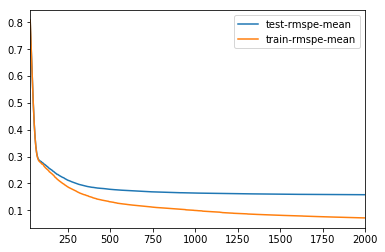

In [112]:
res.loc[30:,["test-rmspe-mean", "train-rmspe-mean"]].plot()
plt.show()

In [113]:
print(res.shape[0])

2000
